У нас появился запрос из отдела продаж и маркетинга. Как вы знаете «МегаФон»
предлагает обширный набор различных услуг своим абонентам. При этом разным
пользователям интересны разные услуги. Поэтому необходимо построить
алгоритм, который для каждой пары пользователь-услуга определит вероятность
подключения услуги.

## Данные

В качестве исходных данных вам будет доступна информация об отклике
абонентов на предложение подключения одной из услуг. Каждому пользователю
может быть сделано несколько предложений в разное время, каждое из которых он
может или принять, или отклонить.

Отдельным набором данных будет являться нормализованный
анонимизированный набор признаков, характеризующий профиль потребления
абонента. Эти данные привязаны к определенному времени, поскольку профиль
абонента может меняться с течением времени.

Данные train и test разбиты по периодам – на train доступно 4 месяцев, а на test
отложен последующий месяц.

Итого, в качестве входных данных будут представлены:

 - data_train.csv: id, vas_id, buy_time, target
 - features.csv.zip: id, <feature_list>

И тестовый набор:

- data_test.csv: id, vas_id, buy_time
    target - целевая переменная, где 1 означает подключение услуги, 0 - абонент
    не подключил услугу соответственно.
    
    buy_time - время покупки, представлено в формате timestamp, для работы с
    этим столбцом понадобится функция datetime.fromtimestamp из модуля
    datetime.
    
    id - идентификатор абонента
    
    vas_id - подключаемая услуга

Примечание: Размер файла features.csv в распакованном виде весит 20 гб, для
работы с ним можно воспользоваться pandas.read_csv, либо можно воспользоваться
библиотекой Dask.

### Метрика

Скоринг будет осуществляться функцией f1, невзвешенным образом, как например
делает функция sklearn.metrics.f1_score(…, average=’macro’)

### Формат представления результата

1. Работающая модель в формате pickle, которая принимает файл data_test.csv
из корневой папки и записывает в эту же папку файл answers_test.csv. В этом
файле должны находится 4 столбца: buy_time, id, vas_id и target. Target можно
записать как вероятность подключения услуги.
2. Код модели можно представить в виде jupyter-ноутбука.
 
3. Презентация в формате .pdf, в которой необходимо отразить:

 - Информация о модели, ее параметрах, особенностях и основных результатах.
 
 - Обоснование выбора модели и ее сравнение с альтернативами.
 
 - Принцип составления индивидуальных предложений для выбранных абонентов.

Рекомендуемое количество слайдов – 5 – 10.
Файл answers_test.csv с результатами работы модели, презентацию, ноутбуки и
резюме необходимо прикрепить ко второму уроку “курсовой проект”

## Решение

### 1. Обзор данных

#### Подключение библиотек и скриптов

In [1]:
import os
import pickle
import time
import random
import datetime as dt

import pandas as pd; pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import make_column_transformer
from sklearn.pipeline import FeatureUnion, make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc, confusion_matrix

from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LogisticRegression

from catboost import CatBoostClassifier

import dask.dataframe as dd
from dask.distributed import Client, LocalCluster, progress

In [132]:
def plot_roc_curve(fpr, tpr, model_name="", color=None):
    """
    График ROC-кривой
    """
    plt.plot(fpr, tpr, label='%s: ROC curve (area = %0.2f)' %
             (model_name, auc(fpr, tpr)), color=color)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('%s: Receiver operating characteristic curve' % model_name)
    plt.legend(loc="lower right")
    
def plot_precision_recall_curve(precision, recall, model_name="", color=None):
    """
    График Precision-Recall кривой
    """    
    plt.plot(recall, precision, label='%s: Precision-Recall curve (area = %0.2f)' %
             (model_name, auc(recall, precision)), color=color)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title("%s: Precision-Recall curve" % model_name)
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.legend(loc="lower left")

#### Загрузка данных

Загрузим исходные .csv-файлы в dask.dataframe и посмотрим состав столбцов.

In [2]:
features_dask = dd.read_csv('features.csv',sep='\t')
train_dask = dd.read_csv('data_train.csv')
test_dask = dd.read_csv('data_test.csv')

In [3]:
train_dask.head()

,Unnamed: 0,id,vas_id,buy_time,target
0,0,540968,8.0,1537131600,0.0
1,1,1454121,4.0,1531688400,0.0
2,2,2458816,1.0,1534107600,0.0
3,3,3535012,5.0,1535922000,0.0
4,4,1693214,1.0,1535922000,0.0


In [4]:
test_dask.head()

,Unnamed: 0,id,vas_id,buy_time
0,0,3130519,2.0,1548018000
1,1,2000860,4.0,1548018000
2,2,1099444,2.0,1546808400
3,3,1343255,5.0,1547413200
4,4,1277040,2.0,1546808400


In [5]:
features_dask.head()

,Unnamed: 0,id,buy_time,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252
0,0,2013026,1531688400,18.910029,46.980888,4.969214,-1.386798,3.791754,-14.01179,-16.08618,-65.076097,-6.783660,-30.006538,-2.736081,-4.007526,-2.558912,49.520873,38.19189,-0.000725,-0.016435,-0.107041,-1.17746,-3.178521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.65939,-0.065583,-0.700765,-42.026959,-2841.496068,-1085.821501,-1755.674564,-89.504287,-119.724355,-70.712019,-54.069191,-16.642826,-7.896282,-5.634035,-10.717958,-28.571103,57.869716,52.911014,26.828289,26.668705,-4.958702,38.254749,-1.671324,-0.001656,1.318354,2.117335,-0.265234,0.331838,0.078356,-0.237576,0.254338,-0.028454,-0.044465,3.698872,26.411990,-0.036834,3.869969,-2.783592,-2.60662,-5.390212,-4.022547,0.0,-2.824022,-10.706438,-1.2015,-0.998268,-0.203232,0.0,-0.248755,-0.222852,-0.134088,0.0,-0.030537,-0.125866,-0.096986,-0.679774,-0.626985,-0.691912,-0.506613,-0.185299,-0.598716,-0.000115,-0.250188,-0.348913,-0.828382,-42.275915,-3.950157,-0.253037,-0.318148,-2.29064,-3.447583,-0.040043,-9.408469,4.027863,-11.955314,-1.019293,-0.473446,-2.62084,-1087.017387,-1757.811263,-0.36799,0.396143,-2844.828651,-2298.725139,-0.343415,-0.08972,-0.278878,-0.433135,-0.024048,-89.211948,-119.674411,-208.886358,-0.058077,0.129549,0.274871,-3.618164,-11.681641,-0.573283,0.531557,0.582717,-190.670372,1.856777,3.277409,2.174027,4.064012,0.0,-1.276187,-0.020137,-0.042636,-29.797016,-70.470802,-14.96363,-34.888325,-3.861461,-0.317164,-0.007024,-0.143269,60.582329,-0.212646,-0.019562,-0.000044,-0.000379,-2.548856,-0.261309,-0.536315,-0.061481,-0.152157,-0.002595,-4.678214,-0.014542,0.280492,-21.183166,-44.376426,-25.320085,-51.984826,-23.961228,-54.128903,-11.614497,-30.288386,-0.028857,-0.063214,-0.019198,-0.033778,-0.003149,-0.005184,-0.001431,-0.00189,-1.257363,-2.793637,-1.932758,-5.008096,-9.978121,-16.684052,4.645192,13.112964,-0.034569,-0.163184,-109.036398,0.533317,-1.929048,0.376263,-0.228106,-0.251959,-0.000567,0.566264,-0.000708,-0.02921,0.895335,-0.001358,0.0,0.039208,0.665644,-0.008999,-11953.712824,-45175.257711,0.377099,-30.716053,-61790.157098,-0.243136,-42051.166127,-9239.707081,-2.10805,-0.000083,0.377104,-0.00004,0.379228,-0.012257,-0.107878,9.595373e+08,-42.014078,-4.405604e+08,1.356414e+09,5.565998,-1.465191,-33.302382,-249.128986,-36.772492,-0.364694,-0.133771,-0.209468,-32.356505,-109.884564,-876.69102,-5.368281,-247.110707,-108.409742,-512.437331,-84.617978,-17.295406,-977.373846,-613.770792,-25.996269,-37.630448,-301.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1,1,2014722,1539550800,36.690029,152.400888,448.069214,563.833202,463.841754,568.99821,-16.08618,-53.216097,-6.783660,-26.544905,-2.736081,-4.007526,-2.558912,67.300873,55.97189,-0.000725,-0.016435,-0.107041,15.77254,-3.178521,411.379185,-10.744164,-0.094251,-0.001733,-0.009327,131.407791,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.65939,-0.065583,-0.700765,-192.026959,-2937.657200,-1181.982633,-1755.674564,447.193953,1258.981645,-119.662019,-54.6025

В датасете features.csv имеется столбец buy_time - столбец с аналогичны именем имеется в датасетах data_train.csv, data_test.csv

Загрузим исходные .csv-файлы в dask.dataframe c одновременным переименованием столбцов:
* индексов
* buy_time

In [6]:
def mapper(name):
    return {'Unnamed: 0': f'index_{name}', 
            'buy_time': f'buy_time_{name}'}


features_df = dd.read_csv('features.csv',sep='\t').rename(columns=mapper('feat'))
train_df = dd.read_csv('data_train.csv').rename(columns=mapper('vas'))
test_df = dd.read_csv('data_test.csv').rename(columns=mapper('vas'))

In [7]:
train_df.head()

,index_vas,id,vas_id,buy_time_vas,target
0,0,540968,8.0,1537131600,0.0
1,1,1454121,4.0,1531688400,0.0
2,2,2458816,1.0,1534107600,0.0
3,3,3535012,5.0,1535922000,0.0
4,4,1693214,1.0,1535922000,0.0


In [8]:
test_df.head()

,index_vas,id,vas_id,buy_time_vas
0,0,3130519,2.0,1548018000
1,1,2000860,4.0,1548018000
2,2,1099444,2.0,1546808400
3,3,1343255,5.0,1547413200
4,4,1277040,2.0,1546808400


In [9]:
features_df.head()

,index_feat,id,buy_time_feat,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252
0,0,2013026,1531688400,18.910029,46.980888,4.969214,-1.386798,3.791754,-14.01179,-16.08618,-65.076097,-6.783660,-30.006538,-2.736081,-4.007526,-2.558912,49.520873,38.19189,-0.000725,-0.016435,-0.107041,-1.17746,-3.178521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.65939,-0.065583,-0.700765,-42.026959,-2841.496068,-1085.821501,-1755.674564,-89.504287,-119.724355,-70.712019,-54.069191,-16.642826,-7.896282,-5.634035,-10.717958,-28.571103,57.869716,52.911014,26.828289,26.668705,-4.958702,38.254749,-1.671324,-0.001656,1.318354,2.117335,-0.265234,0.331838,0.078356,-0.237576,0.254338,-0.028454,-0.044465,3.698872,26.411990,-0.036834,3.869969,-2.783592,-2.60662,-5.390212,-4.022547,0.0,-2.824022,-10.706438,-1.2015,-0.998268,-0.203232,0.0,-0.248755,-0.222852,-0.134088,0.0,-0.030537,-0.125866,-0.096986,-0.679774,-0.626985,-0.691912,-0.506613,-0.185299,-0.598716,-0.000115,-0.250188,-0.348913,-0.828382,-42.275915,-3.950157,-0.253037,-0.318148,-2.29064,-3.447583,-0.040043,-9.408469,4.027863,-11.955314,-1.019293,-0.473446,-2.62084,-1087.017387,-1757.811263,-0.36799,0.396143,-2844.828651,-2298.725139,-0.343415,-0.08972,-0.278878,-0.433135,-0.024048,-89.211948,-119.674411,-208.886358,-0.058077,0.129549,0.274871,-3.618164,-11.681641,-0.573283,0.531557,0.582717,-190.670372,1.856777,3.277409,2.174027,4.064012,0.0,-1.276187,-0.020137,-0.042636,-29.797016,-70.470802,-14.96363,-34.888325,-3.861461,-0.317164,-0.007024,-0.143269,60.582329,-0.212646,-0.019562,-0.000044,-0.000379,-2.548856,-0.261309,-0.536315,-0.061481,-0.152157,-0.002595,-4.678214,-0.014542,0.280492,-21.183166,-44.376426,-25.320085,-51.984826,-23.961228,-54.128903,-11.614497,-30.288386,-0.028857,-0.063214,-0.019198,-0.033778,-0.003149,-0.005184,-0.001431,-0.00189,-1.257363,-2.793637,-1.932758,-5.008096,-9.978121,-16.684052,4.645192,13.112964,-0.034569,-0.163184,-109.036398,0.533317,-1.929048,0.376263,-0.228106,-0.251959,-0.000567,0.566264,-0.000708,-0.02921,0.895335,-0.001358,0.0,0.039208,0.665644,-0.008999,-11953.712824,-45175.257711,0.377099,-30.716053,-61790.157098,-0.243136,-42051.166127,-9239.707081,-2.10805,-0.000083,0.377104,-0.00004,0.379228,-0.012257,-0.107878,9.595373e+08,-42.014078,-4.405604e+08,1.356414e+09,5.565998,-1.465191,-33.302382,-249.128986,-36.772492,-0.364694,-0.133771,-0.209468,-32.356505,-109.884564,-876.69102,-5.368281,-247.110707,-108.409742,-512.437331,-84.617978,-17.295406,-977.373846,-613.770792,-25.996269,-37.630448,-301.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1,1,2014722,1539550800,36.690029,152.400888,448.069214,563.833202,463.841754,568.99821,-16.08618,-53.216097,-6.783660,-26.544905,-2.736081,-4.007526,-2.558912,67.300873,55.97189,-0.000725,-0.016435,-0.107041,15.77254,-3.178521,411.379185,-10.744164,-0.094251,-0.001733,-0.009327,131.407791,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.65939,-0.065583,-0.700765,-192.026959,-2937.657200,-1181.982633,-1755.674564,447.193953,1258.981645,-119.662019,-54

In [10]:
LEN_TRAIN = len(train_df.index)
print(f'Наблюдений в "data_train.csv": {LEN_TRAIN}')

Наблюдений в "data_train.csv": 831653


In [11]:
LEN_TEST = len(test_df.index)
print(f'Наблюдений в "data_test.csv": {LEN_TEST}')

Наблюдений в "data_test.csv": 71231


#### Слияние тренировочной выборки и набора данных с профилем абонента

Предположим, что в features.csv имеются данные для всех id, которые имеются в тренировочной и тестовой выборках.

Проведем слияние методом пересечения (how='inner') по столбцу id.

In [12]:
train_merge = dd.merge(train_df, features_df, on=['id'], how='inner')

In [13]:
train_feat = train_merge.compute()

In [14]:
train_feat.head()

,index_vas,id,vas_id,buy_time_vas,target,index_feat,buy_time_feat,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252
0,140,4130548,2.0,1544389200,0.0,8832,1548018000,11.700029,17.790888,4.429214,-10.646798,-0.988246,-31.75179,7.85382,29.933903,-3.863189,-14.606532,-2.736081,17.012004,-2.558912,18.370873,7.04189,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-7.270815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,20.71061,-0.065583,-0.700765,-43.026959,-598.379904,-1068.177947,469.798136,-89.504287,-119.724355,-47.728685,-23.919190,-23.809498,-7.896282,-6.822342,-10.707745,-28.565596,-17.130284,-21.088986,-22.171711,-1.331295,-3.958702,0.254749,-0.671324,-0.001656,50.318354,7.117335,0.114766,-0.098162,0.038356,0.192424,0.044338,-0.028454,-0.044465,-0.301128,-0.554677,-0.036834,-0.130031,-2.783592,-2.60662,-5.390212,-4.022547,0.0,-0.324022,9.293562,-1.2015,-0.998268,-0.203232,0.0,-0.248755,-0.222852,-0.134088,0.0,-0.030537,-0.125866,-0.096986,-0.679774,-0.626985,-0.691912,-0.506613,-0.185299,-0.598716,-0.000115,-0.250188,-0.348913,-0.828382,-42.275915,-3.950157,-0.253037,-0.318148,-2.29064,-0.947583,-0.040043,-9.408469,-0.212137,-11.955314,-1.019293,-1.473446,-4.62084,-1069.373833,467.661437,0.30201,-0.203857,-601.712487,44.862861,-0.343415,-0.08972,-0.278878,-0.433135,-0.024048,-89.211948,-119.674411,-208.886358,0.011923,-0.060451,-0.265129,18.381836,17.318359,1.426717,-0.468443,-0.417283,-190.670372,15.856777,22.277409,8.174027,13.064012,0.0,-1.276187,-0.020137,-0.042636,11.452984,105.979198,-19.96363,-9.888325,-2.861461,0.282836,-0.007024,0.456731,-14.417671,-0.212646,-0.019562,-0.000044,-0.000379,-2.548856,-0.261309,-0.536315,-0.061481,-0.152157,-0.002595,-3.678214,-0.014542,-0.029508,4.816834,-29.009759,0.679915,-33.001492,23.038772,-23.978902,-11.614497,-28.471719,-0.028857,-0.063214,-0.019198,-0.033778,-0.003149,-0.005184,-0.001431,-0.00189,-1.257363,-2.793637,-1.932758,-5.008096,30.021879,-23.850720,-16.354808,-35.303704,-0.034569,-0.163184,-109.036398,0.533317,-1.929048,-0.623737,-0.228106,-0.251959,-0.000567,0.566264,-0.000708,-0.02921,-0.104665,-0.001358,0.0,0.039208,0.665644,-0.008999,-11953.712824,-45053.257711,0.377099,-34.616053,-61798.157098,-0.243136,-42051.166127,-9239.707081,-2.10805,-0.000083,0.377104,-0.00004,0.379228,-0.012257,-0.107878,9.758669e+08,-46.464078,-4.405604e+08,-1.204418e+08,-11.580668,-1.465191,-33.302382,-225.128986,0.227508,-0.364694,-0.133771,-0.209468,-4.356505,-109.884564,1082.30898,-1.368281,703.889293,-108.409742,491.562669,-105.617978,-17.295406,-943.373846,-598.770792,-25.996269,-22.630448,-220.747724,-14.832889,-0.694428,-12.175933,-0.45614,1.0
1,842,540997,1.0,1541365200,0.0,11897,1545598800,-96.799971,-69.199112,-108.200786,-112.916798,-113.618246,-134.02179,-16.08618,-65.076097,-6.783660,-30.006538,-2.736081,-4.007526,-2.558912,-66.189127,-77.51811,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-11.400815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.65939,-0.065583,-0.700765,-1

In [15]:
LEN_TRAIN_FEAT = train_feat.shape[0]
print(f'Наблюдений в датасете после слияния": {LEN_TRAIN_FEAT}')

Наблюдений в датасете после слияния": 860052


После слияния тренировочный датасет имеет больше наблюдей (860052), чем исходный (831653). 

* Это связано с тем, что для некоторых клиентов в данных профиля потребления имеются несколько записей, зафиксированных в разное время. 
* Для таких случаев произошло дублирование некоторых наблюдений из data_train.csv с разными записями признков из features.csv. Дублированными строками считаются те, которые имеют одинаковое значение index_vas.

Избавляться от дубликатов будем с учетом актуальности по временни. 
* Среди дубликатов будем оставлять только те наблдения, у которых разница между временными штампами отклика на услугу ('buy_time_vas') и фиксации записи по признакам профиля потребления ('buy_time_feat') минимальна. 
* Введем новый столбец 'time_delta', который будет отражать указанную разницу во времени.

In [16]:
def buy_time_clear(df):
    df['time_delta'] = abs(df['buy_time_vas'] - df['buy_time_feat'])
    
    # Отсортируем наблюдения в порядке возрастания 'time_delta'
    df.sort_values(['time_delta'], inplace=True, ignore_index=True)
    
    # удалим по порядку все дубликаты, оставляя лишь те, которые встречаются в датафрейме первыми (keep='first')
    df.drop_duplicates(['index_vas'], keep='first', inplace=True)
    
    # Отсортируем датасет по возрастанию index_vas.
    df.sort_values(['index_vas'], inplace=True, ignore_index=True)
    
    return df    

In [17]:
buy_time_clear(train_feat)

,index_vas,id,vas_id,buy_time_vas,target,index_feat,buy_time_feat,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,time_delta
0,0,540968,8.0,1537131600,0.0,3756522,1541970000,-31.559971,327.360888,-45.500786,274.753202,-50.918246,253.64821,49.15382,195.883903,-1.835267,-12.831245,-2.736081,56.284081,-2.558912,-66.189127,-77.51811,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-13.940815,54.495836,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,2.648138,0.785634,0.788392,-0.001884,-0.000023,-0.00003,62.58061,-0.065583,-0.700765,-192.026959,239.787096,-1005.230677,1245.017836,-89.504287,-119.724355,-3.512019,33.247476,-36.759494,-7.896282,-7.997875,-10.697457,-28.551694,-17.130284,-16.088986,-26.171711,-5.331295,1.041298,-3.745251,-1.671324,-0.001656,9.318354,15.117335,0.174766,-0.108162,0.028356,-0.017576,-0.165662,-0.028454,-0.044465,-0.301128,-0.554677,-0.036834,-0.130031,-2.783592,-2.60662,-5.390212,-4.022547,0.0,-2.824022,-10.706438,-1.2015,-0.998268,-0.203232,0.0,-0.248755,-0.222852,-0.134088,0.0,-0.030537,-0.125866,-0.096986,-0.679774,-0.626985,-0.691912,-0.506613,-0.185299,-0.598716,-0.000115,-0.250188,-0.348913,-0.828382,-42.275915,-3.950157,-0.253037,-0.318148,-2.29064,-3.447583,-0.040043,-9.408469,-0.212137,-11.955314,-1.019293,-1.473446,0.37916,-1006.426563,1242.881137,0.03201,0.196143,236.454513,848.953561,-0.343415,-0.08972,-0.278878,-0.433135,-0.024048,-89.211948,-119.674411,-208.886358,0.031923,-0.030451,0.104871,1.381836,5.318359,1.426717,-0.468443,-0.017283,-190.670372,5.856777,7.277409,2.174027,5.064012,0.0,-1.276187,-0.020137,-0.042636,-11.480350,-59.370804,34.03637,-17.888325,0.138539,-0.317164,-0.007024,-0.143269,-14.417671,-0.212646,-0.019562,-0.000044,-0.000379,-2.548856,-0.261309,-0.536315,-0.061481,-0.152157,-0.002595,1.321786,-0.014542,-0.009508,-8.183166,35.756904,-14.320085,-40.801492,-5.961228,33.187764,-12.614497,-26.671719,-0.028857,-0.063214,-0.019198,-0.033778,-0.003149,-0.005184,-0.001431,-0.00189,-1.257363,-2.793637,-1.932758,-5.008096,-15.978121,-36.800720,-9.354808,-25.320370,-0.034569,-0.163184,-109.036398,0.533317,-1.929048,-0.623737,-0.228106,-0.251959,-0.000567,0.566264,-0.000708,-0.02921,-0.104665,-0.001358,0.0,0.039208,0.665644,-0.008999,-11953.712824,-45175.257711,-0.622901,-30.716053,-61790.157098,-0.243136,-42051.166127,-9239.707081,-2.10805,-0.000083,-0.622896,-0.00004,-0.620772,-0.012257,-0.107878,9.698189e+08,-49.224078,-4.405604e+08,-1.204418e+08,-8.634002,-1.465191,-33.302382,810.871014,270.227508,-0.364694,-0.133771,-0.209468,269.643495,-109.884564,364.30898,41.631719,938.889293,-108.409742,-504.437331,-53.617978,-12.295406,-845.373846,-613.770792,-20.996269,-37.630448,-28.747724,4.167111,7.305572,-12.175933,21.54386,0.0,4838400
1,1,1454121,4.0,1531688400,0.0,2735973,1531083600,547.270029,238.430888,533.329214,274.803202,527.911754,253.69821,-16.08618,-65.076097,-6.783660,-30.006538,-2.736081,-4.007526,-2.558912,577.880873,566.55189,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.65939,-0

Проверим нарушилась ли индексация index_vas путем сравнения со сброшенным на предыдущем этапе индеском датасета.

In [18]:
(train_feat.index == train_feat['index_vas']).all()

True

Индексы совпадают, индексация не нарушена.

Сравним количество наблюдений полученного датасета с data_train.csv

In [19]:
print(f'Наблюдений   в   исходном  "data_train.csv": {LEN_TRAIN}')
print(f'Наблюдений в новом тренирвоочном датафрейме: {train_feat.shape[0]}')

Наблюдений   в   исходном  "data_train.csv": 831653
Наблюдений в новом тренирвоочном датафрейме: 831653


Индексация и количество наблюдений после извлечения и добавления признаков потребления в новом тренировочном датасете НЕ НАРУШЕНЫ.

Удалим лишние стобцы с индексами и признаком buy_time из features.csv. 
Признак time_delta оставим, так как он несет в себе информацию об актуальности признаков профиля потребления на момент отклика клиента на услугу. 


In [20]:
train_feat.drop(['index_vas', 'index_feat', 'buy_time_feat'], axis=1, inplace=True)

#### Слияние тестовой выборки и набора данных с профилем абонента

In [171]:
test_merge = dd.merge(test_df, features_df, on=['id'], how='inner')
test_feat = test_merge.compute()

In [172]:
buy_time_clear(test_feat)

,index_vas,id,vas_id,buy_time_vas,index_feat,buy_time_feat,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,time_delta
0,0,3130519,2.0,1548018000,1871362,1536526800,-62.899971,-374.279112,-72.600786,-418.406798,-78.018246,-439.51179,17.81382,-31.176097,-6.78366,-30.006538,31.163919,-4.007526,-2.558912,-66.189127,-77.51811,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-9.700815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.65939,-0.065583,-0.700765,-92.026959,-2847.354464,-1091.679897,-1755.674564,-89.504287,-119.724355,-88.778686,-35.052524,-53.726160,-7.896282,-7.997875,-10.361439,-28.563689,-17.130284,-22.088986,-48.171711,-25.331295,-4.958702,-8.745251,-1.671324,-0.001656,-24.681646,-3.882665,0.524766,0.421838,-0.021644,0.552424,0.584338,-0.028454,-0.044465,-0.301128,-0.554677,-0.036834,-0.130031,31.116408,-2.60662,28.509788,29.877453,0.0,-2.824022,-10.706438,-1.2015,-0.998268,-0.203232,0.0,-0.248755,-0.222852,-0.134088,0.0,-0.030537,-0.125866,-0.096986,-0.679774,-0.626985,-0.691912,-0.506613,-0.185299,-0.598716,-0.000115,-0.250188,-0.348913,-0.828382,-42.275915,-3.950157,-0.253037,-0.318148,-2.29064,-3.447583,-0.040043,-9.408469,-0.212137,-11.955314,-1.019293,-2.473446,-1.62084,-1092.875783,-1757.811263,-0.36799,-0.033857,-2850.687047,-2203.639199,-0.343415,-0.08972,-0.278878,-0.433135,-0.024048,-89.211948,-119.674411,-208.886358,-0.058077,-0.060451,-0.075129,-5.618164,-10.681641,-1.573283,0.531557,0.582717,-190.670372,-1.143223,-2.722591,-0.825973,-1.935988,0.0,-1.276187,-0.020137,-0.042636,-29.797016,-116.020802,-3.96363,-5.888325,-3.861461,-0.317164,-0.007024,-0.143269,-14.417671,-0.212646,-0.019562,-0.000044,-0.000379,-2.548856,-0.261309,-0.536315,-0.061481,-0.152157,-0.002595,-4.678214,-0.014542,-0.079508,-2.183166,-24.826426,-9.320085,-40.651493,-6.961228,-35.112236,5.385503,-11.271719,-0.028857,-0.063214,-0.019198,-0.033778,-0.003149,-0.005184,-0.001431,-0.00189,-1.257363,-2.793637,-1.932758,-5.008096,-14.978121,-53.767387,-0.354808,-23.970371,-0.034569,-0.163184,-109.036398,-0.466683,-2.929048,0.376263,-0.228106,-0.251959,-0.000567,-0.433736,-0.000708,-0.02921,-0.104665,-0.001358,0.0,0.039208,-0.334356,-0.008999,-11953.712824,10384.742289,0.377099,-30.716053,-61790.157098,-0.243136,-42051.166127,-9239.707081,-2.10805,-0.000083,0.377104,-0.00004,0.379228,-0.012257,-0.107878,-5.726695e+08,-58.544078,-4.405604e+08,-1.204418e+08,6.899332,-1.465191,-32.302382,-252.128986,-39.772492,-0.364694,-0.133771,-0.209468,-35.356505,-109.884564,-876.69102,-5.368281,-247.110707,-108.409742,-512.437331,-84.617978,-17.295406,-970.373846,-613.770792,-25.996269,-37.630448,-258.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0,11491200
1,1,2000860,4.0,1548018000,2024591,1532293200,-96.799971,100.290888,-110.740786,140.903202,-116.158246,119.79821,-16.08618,-65.076097,-6.78366,-30.006538,-2.736081,-4.007526,-2.558912,-66.189127,-77.51811,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023

In [173]:
(test_feat.index == test_feat['index_vas']).all()

True

In [174]:
print(f'Наблюдений в исходном  "data_test.csv": {LEN_TEST}')
print(f'Наблюдений в новом тестовом датафрейме: {test_feat.shape[0]}')

Наблюдений в исходном  "data_test.csv": 71231
Наблюдений в новом тестовом датафрейме: 71231


Индексация и количество наблюдений после извлечения и добавления признаков потребления в новом тестовом датасете НЕ НАРУШЕНЫ.

In [175]:
test_feat.drop(['index_vas', 'index_feat'], axis=1, inplace=True)

### 2. Анализ признаков

#### target

Целевая переменная, определяет отклик клиента на услугу.

* 0 - клиент отказался от услуги
* 1 - клиент подключил услугу

Рассмотрим распределение переменной в обучающей выборке:

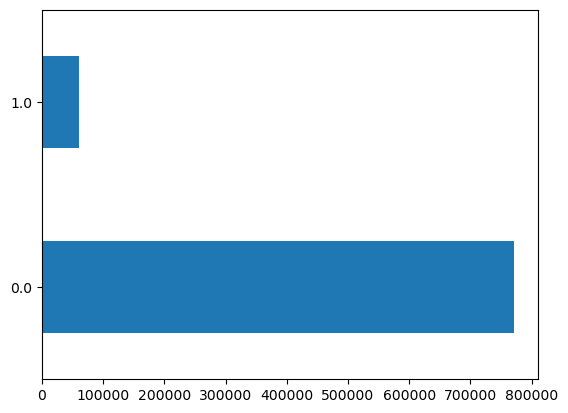

In [21]:
train_feat['target'].value_counts().plot(kind='barh')
plt.show()

Наблюдается сильная несбалансированность классов. Это необходимо будет учесть при построении моделей.

#### vas_id

Идентификатор услуги. Рассмотрим распределение признака.

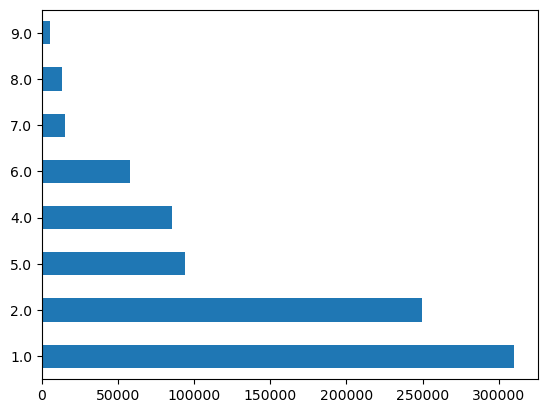

In [22]:
train_feat['vas_id'].value_counts().plot(kind='barh')
plt.show()

Будем использовать этот признак в качестве категориального.

#### id

Использование id в модели нецелесообразно. id - уникальный идентификатор клиента: как число исползовать нельзя, а как категорию практически невозможно, так как появляются новые клиенты. Поэтому id не будем использовать в обучающей выборке.

#### buy_time_vas

In [23]:
date = pd.to_datetime(train_feat['buy_time_vas'], unit='s').dt.tz_localize('UTC').dt.tz_convert('Europe/Moscow')
date.sample(5)

504941   2018-07-30 00:00:00+03:00
722672   2018-12-24 00:00:00+03:00
331232   2018-08-06 00:00:00+03:00
512815   2018-10-01 00:00:00+03:00
717775   2018-10-01 00:00:00+03:00
Name: buy_time_vas, dtype: datetime64[ns, Europe/Moscow]

Присутствует только информация по дате. Рассмотрим количество уникальных составляющих даты по всему признаку:

In [24]:
date_features = pd.DataFrame()
date_features['month'] = date.dt.month
date_features['day'] = date.dt.day
date_features['dayofyear'] = date.dt.dayofyear
date_features['dayofweek'] = date.dt.dayofweek
date_features['weekofyear'] = date.dt.weekofyear
date_features.nunique()

C:\Users\pc\AppData\Local\Temp\ipykernel_11328\1783271646.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  date_features['weekofyear'] = date.dt.weekofyear


month          6
day           22
dayofyear     26
dayofweek      1
weekofyear    26
dtype: int64

* Имеются наблюдения за 6 месяцев.
* Все наблюдения относятся к одному дню недели, соответственно, данные day, dayofyear не несут никакой полезной информации.
* Признаки month и weekofyear по логике сильно коррелированы.

Рассмотрим влияние номера недели в году на относительную частоту положительного отклика клиентов на услугу.

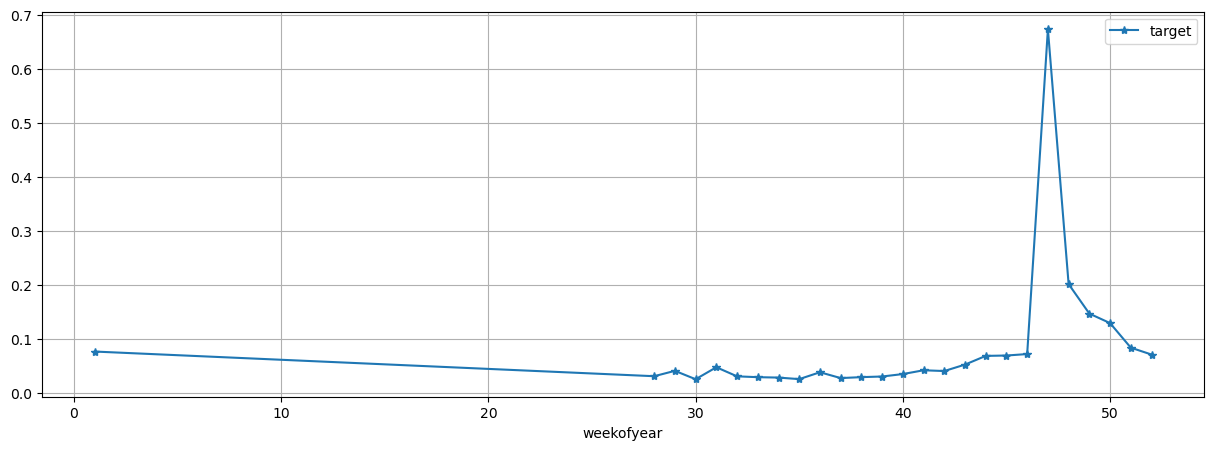

In [25]:
week_target = pd.concat([train_feat['target'], date, date_features['weekofyear']], axis=1).sort_values('buy_time_vas')
week_target.groupby('weekofyear').mean().plot(style='-*', figsize=(15,5), grid=True)
plt.show()

Наблюдения weekofyear, имеющие значение 1, на самом деле относятся к самому концу года. Дело в том, что это дата 31 декабря 2018 года. И это понедельник - поэтому алгоритм определяет эту дату как первую неделю 2019 года. Но это не имеет значения.

На графике наблюдается аномальный скачок частоты положительных откликов на 47 неделе. Это 19-25 ноября 2018 г., обычная рабочая неделя. Возможно, данная аномалия может объясняться запуском в этот период особых маркетинговых акций или рекламных кампаний, так как рост скачка резкий, а спад чуть медленнее, инертнее. В любом случае, такие аномалии будут только ухудшать модель, поэтому не будем использовать временные данные buy_time_vas в обучении.

#### time_delta

Значения в секундах. Трансформируем данный признак в диапазоне значений от 0 до 1 и применим экспоненту от отрицательного значения. Чем больше временная разница, тем меньше вес. В конце проверим значения на пропуски.

In [26]:
w_sc = StandardScaler().fit_transform(train_feat['time_delta'].values.reshape(-1,1))
w = 1 / (1 + np.exp(w_sc))

assert not np.isnan(w).any()

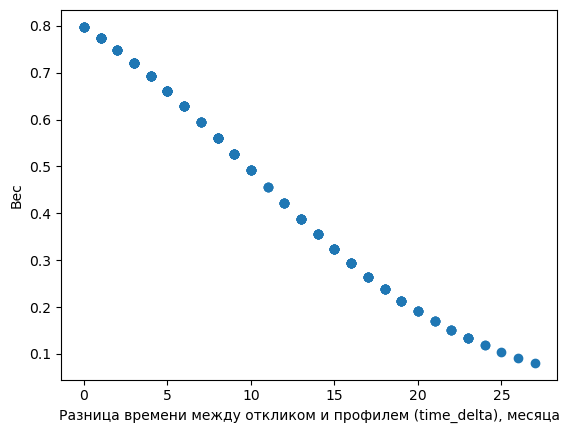

In [27]:
plt.scatter(train_feat['time_delta'].values.reshape(-1,1)[:200]/(60*60*24*7),w[:200])
plt.xlabel('Разница времени между откликом и профилем (time_delta), месяца')
plt.ylabel('Вес')
plt.show()

#### Выделение целевой переменнной

In [28]:
X = train_feat.drop(['id','target','buy_time_vas'], axis=1)
y = train_feat['target']

### Определение типов признаков

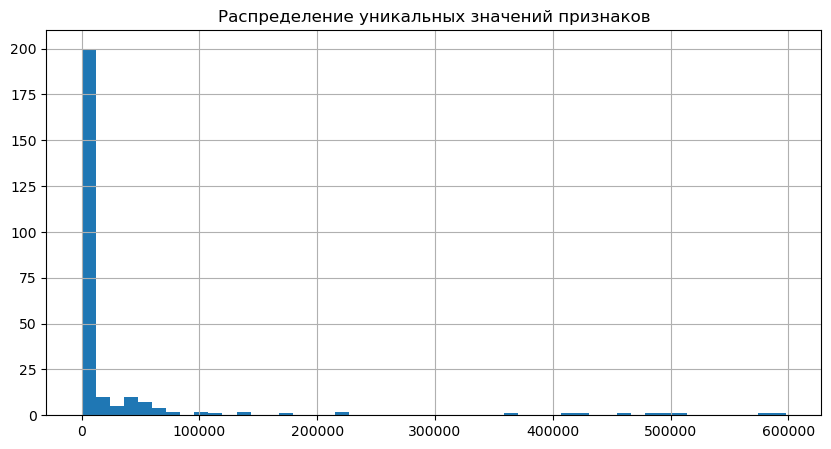

In [29]:
X_nunique = X.apply(lambda x: x.nunique(dropna=False))
plt.title("Распределение уникальных значений признаков");
X_nunique.hist(bins=50, figsize=(10, 5));

In [30]:
X_nunique.shape

(255,)

#### Всего признаков

In [31]:
f_all = set(X_nunique.index.tolist())
len(f_all)

255

#### Константные признаки

In [32]:
f_const = set(X_nunique[X_nunique == 1].index.tolist())
len(f_const)

5

#### Вещественные признаки

In [33]:
f_numeric = (X.fillna(0).astype(int).sum() - X.fillna(0).sum()).abs()
f_numeric = set(f_numeric[f_numeric > 0].index.tolist())
len(f_numeric)

247

In [34]:
f_other = f_all - (f_numeric | f_const)
len(f_other)

3

#### Бинарные признаки

In [35]:
f_binary = set(X.loc[:, f_other].columns[(
                      (X.loc[:, f_other].max() == 1) & \
                      (X.loc[:, f_other].min() == 0) & \
                      (X.loc[:, f_other].isnull().sum() == 0))])
len(f_binary)

C:\Users\pc\AppData\Local\Temp\ipykernel_11328\548895597.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f_binary = set(X.loc[:, f_other].columns[(
C:\Users\pc\AppData\Local\Temp\ipykernel_11328\548895597.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  (X.loc[:, f_other].max() == 1) & \
C:\Users\pc\AppData\Local\Temp\ipykernel_11328\548895597.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  (X.loc[:, f_other].min() == 0) & \
C:\Users\pc\AppData\Local\Temp\ipykernel_11328\548895597.py:4: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  (X.loc[:, f_other].isnull().sum() == 0))])


0

In [36]:
f_other = f_other - f_binary
len(f_other)

3

#### Категориальные признаки

Определим максимальное количество уникальных значений среди категориальных признаков = 20

In [37]:
f_categorical = set(X_nunique.loc[f_other][X_nunique.loc[f_other] <= 20].index.tolist())
f_categorical

C:\Users\pc\AppData\Local\Temp\ipykernel_11328\4203168968.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f_categorical = set(X_nunique.loc[f_other][X_nunique.loc[f_other] <= 20].index.tolist())
C:\Users\pc\AppData\Local\Temp\ipykernel_11328\4203168968.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f_categorical = set(X_nunique.loc[f_other][X_nunique.loc[f_other] <= 20].index.tolist())


{'vas_id'}

#### Прочие признаки

In [38]:
f_other = f_other - f_categorical
f_other

{'252', 'time_delta'}

Рассмотрим признак '252'.

In [39]:
train_feat['252'].value_counts()

0.0       620789
1.0       210821
2.0            5
3.0            3
8.0            3
10.0           3
4.0            2
7.0            2
11.0           2
13.0           2
5.0            2
251.0          1
299.0          1
68.0           1
77.0           1
182.0          1
223.0          1
283.0          1
195.0          1
6.0            1
22.0           1
18.0           1
44.0           1
19.0           1
42.0           1
84.0           1
1743.0         1
16.0           1
24.0           1
284.0          1
Name: 252, dtype: int64

In [ ]:
#Видно, что признак 252 практически бинарный. Удалим (=nan) все значения, кроме 0 и 1.

X.loc[X['252']>1,:] = X['252'].value_counts().argmax()

Отнесем признак '252' к категориальным

In [40]:
f_categorical = f_categorical | {'252'}
f_other = f_other - {'252'}
len(f_other)

1

Признак time_delta обозначим как весовой тип.

In [41]:
f_weight = {'time_delta'}
f_numeric = (f_numeric | f_other ) - f_weight

Проверка: не осталось ли пропущенных стобцов

In [42]:
assert(X_nunique.shape[0] == len(f_const) + len(f_numeric) + len(f_binary) + len(f_categorical) + len(f_weight))

#### Итог

In [43]:
print('f_all:', X.shape[1])
print()
print('f_const:', len(f_const))
print('f_categorical:', len(f_categorical))
print('f_numeric:', len(f_numeric))
print('f_binary:', len(f_binary))
print('f_weight:', len(f_weight))

f_ok = list(f_categorical | f_numeric | f_weight)
f_categorical, f_numeric, f_weight = list(f_categorical), list(f_numeric), list(f_weight)

f_all: 255

f_const: 5
f_categorical: 2
f_numeric: 247
f_binary: 0
f_weight: 1


In [44]:
print("ID уникален? ", X.index.is_unique)
print("Есть ли дубли в строках?", X.duplicated().sum())
print("Сколько процент признаков могут принимать null-значениями? %d%%" % float((X.isnull().sum() > 0).sum()/X.shape[1]*100))

ID уникален?  True
Есть ли дубли в строках? 677
Сколько процент признаков могут принимать null-значениями? 0%


In [45]:
%%script false
X.drop_duplicates(inplace=True)

Couldn't find program: 'false'


In [46]:
%%script false
X.duplicated().sum()

Couldn't find program: 'false'


### 3. Логистическая регрессия

#### 3.1 Разделяем на train и test

0.0    0.927631
1.0    0.072369
Name: target, dtype: float64

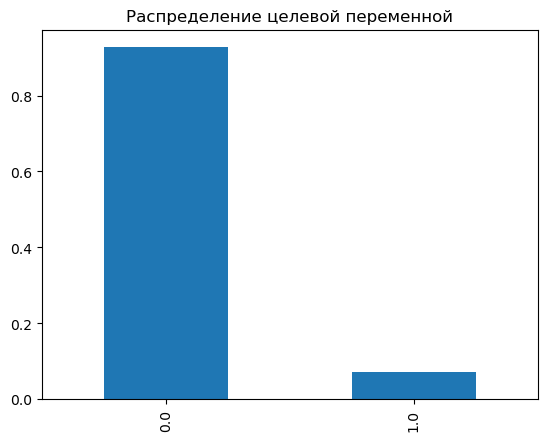

In [47]:
(y.value_counts()/y.shape[0]).plot(kind='bar', title='Распределение целевой переменной');
y.value_counts()/y.shape

In [48]:
from sklearn.model_selection import train_test_split

# Зафиксируем значение random_state для воспроизводимости результатов.
RANDOM_STATE = 42

train_idx, test_idx = train_test_split(X[f_ok].index, train_size=0.1, test_size=0.033, random_state=RANDOM_STATE)

y_train, y_test = y.loc[train_idx], y.loc[test_idx]
X_train, X_test = X.loc[train_idx], X.loc[test_idx]

print("Train")
print(y.loc[train_idx].value_counts()/train_idx.shape[0])
print()
print("Test")
print(y.loc[test_idx].value_counts()/test_idx.shape[0])

Train
0.0    0.928095
1.0    0.071905
Name: target, dtype: float64

Test
0.0    0.925925
1.0    0.074075
Name: target, dtype: float64


In [49]:
X_train.shape

(83165, 255)

In [50]:
X_test.shape

(27445, 255)

#### 3.2 Pipeline для baseline модели

Для построения baseline модели будем использовать логистическую регрессию.

Логистическая регрессия требует отмасштабированные числовые признаки и перекодированные в числовые категориальные признаки.

Базовый пайплайн будет состоять из трех шагов:

- Масштабирование числовых признаков
- Перекодирование в числовые категориальных признаков
- Логистическая регрессия с базовыми параметрами

In [51]:
from sklearn.linear_model import LogisticRegression

# назовем этот шаг пайплайна log_reg
# параметр n_jobs = сколько процессоров будем использовать.
# -1 означает, что мы будем использовать все процессоры нашего ПК
step_log_reg = ('log_reg', LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1, max_iter=200))

In [52]:
# пайплайн для числовых признаков
f_num_pipepline = make_pipeline(
    SimpleImputer(strategy="mean"),
    StandardScaler()
)

# пайплайн для категориальных признаков
f_cat_pipepline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown='ignore')
)

# объединяющий пайплайн
preproc_pipeline = make_column_transformer(
    (f_num_pipepline, f_numeric),
    (f_cat_pipepline, f_categorical)
)

In [53]:
# назовем этот шаг пайплайна preproc
step_preproc = ("preproc", preproc_pipeline)

In [54]:
from sklearn.pipeline import Pipeline

bl_estimator = Pipeline([
    step_preproc,
    step_log_reg
])

#### Кросс-валидация

Для оценки качества модели будем использовать кросс-валидацию по 3-ем фолдам.

* Folds: 1 2 3
    * Train: 1,2 Val: 3
    * Train: 1,3 Val: 2
    * Train: 2,3 Val: 1


Варианты:
- **‘precision’, ‘recall’, ‘accuracy’, ‘f1’** - используем эти метрики, когда наш алгоритм выдает 0 или 1
- **‘average_precision’, ‘roc_auc’** - используем эти метрики, когда наш алгоритм выдает значения от 0 до 1. Это веротяность того, что объект принадлежит классу 1.

In [55]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

# класс KFolf разделит выборку на три фолда, перед разделение премешает данные, так как мы выставили shuffle=True
kfold_cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

def run_cv(estimator, cv, X, y, scoring='roc_auc', model_name=""):
    """
    Процедура вычисляет кросс-валидацию и выводит её на экрнан
    Метод cross_validate делает расчет метрики на кросс-валидации. Он разбивает выборку на фолды,
    на каждом фитит модель и предиктит на валидационном датасете.
    По всем фолдам усредняет значение метрики.
    """
    cv_res = cross_validate(estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    print("%s: %s = %0.2f (+/- %0.2f)" % (model_name,
                                         scoring,
                                         cv_res['test_score'].mean(),
                                         cv_res['test_score'].std() * 2))

Посмотрим на значение метрики на кросс-валидации, оно понадобится для сравнения с последующими моделями.

In [56]:
run_cv(bl_estimator, kfold_cv, X_train, y_train, model_name="Baseline");

Baseline: roc_auc = 0.84 (+/- 0.01)


In [57]:
# фитим пайплайн на трейновом множестве 
bl_estimator.fit(X_train, y_train)

# предиктим пайпланй на тестовом множестве. Лог.регрессия выдает значения от 0 до 1.
bl_y_pred = bl_estimator.predict_proba(X_test)[:,1]
# bl_predict = bl_estimator.predict_proba(X_test)

In [136]:
bl_predict = bl_estimator.predict_proba(X_test)

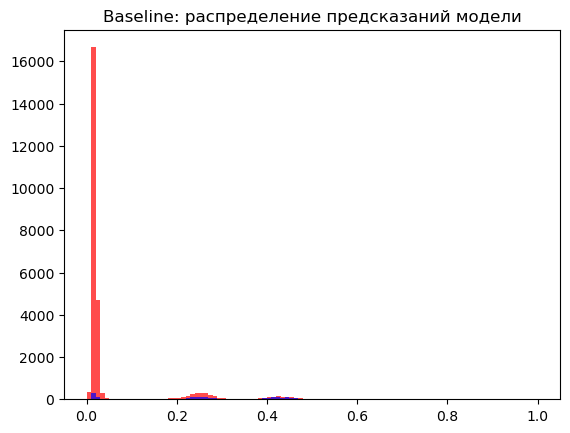

In [58]:
plt.title("Baseline: распределение предсказаний модели")
plt.hist(bl_y_pred[~y_test.astype(bool)], bins=100, color='r', alpha=0.7);
plt.hist(bl_y_pred[y_test.astype(bool)], bins=100, color='b', alpha=0.7);

#### Roc и PR Кривые

In [59]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc

fpr, tpr, roc_thresholds = roc_curve(y_test, bl_y_pred)
precision, recall, pr_thresholds = precision_recall_curve(y_test, bl_y_pred)

Baseline: AUC_ROC = 0.844


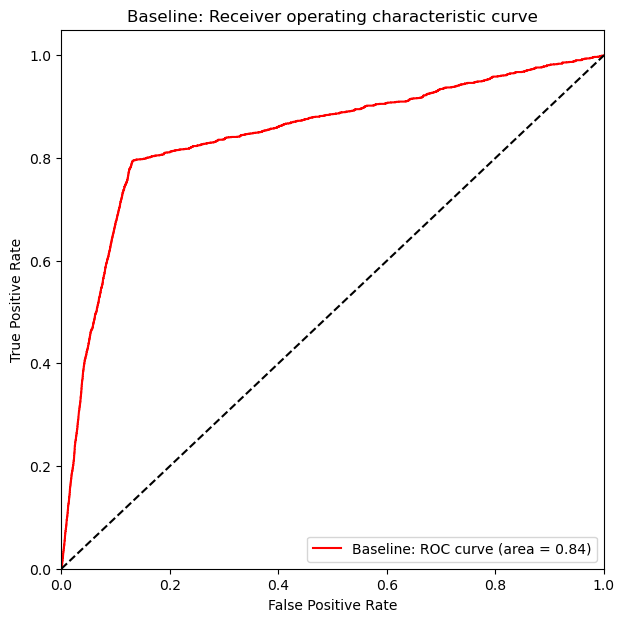

In [60]:
def plot_roc_curve(fpr, tpr, model_name="", color=None):
    plt.plot(fpr, tpr, label='%s: ROC curve (area = %0.2f)' %
             (model_name, auc(fpr, tpr)), color=color)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('%s: Receiver operating characteristic curve' % model_name)
    plt.legend(loc="lower right")

plt.figure(figsize=(7, 7))
plot_roc_curve(fpr, tpr, "Baseline", color='r')
print("Baseline: AUC_ROC = %.3f" % auc(fpr, tpr))

Baseline: AUC_PR = 0.344


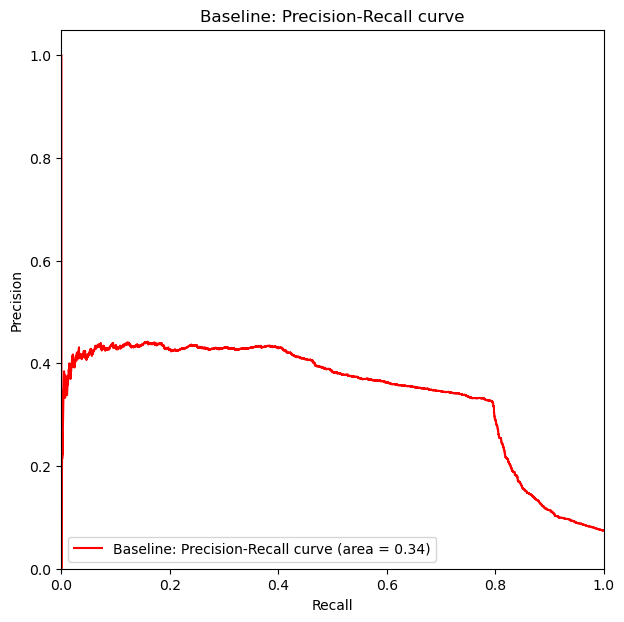

In [61]:
def plot_precision_recall_curve(recall, precision, model_name="", color=None):
    plt.plot(recall, precision, label='%s: Precision-Recall curve (area = %0.2f)' %
             (model_name, auc(recall, precision)), color=color)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title("%s: Precision-Recall curve" % model_name)
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.legend(loc="lower left")

plt.figure(figsize=(7, 7))
    
plot_precision_recall_curve(recall, precision, "Baseline", color='r')
print("Baseline: AUC_PR = %.3f" % auc(recall, precision))

**Далее рассмотрим метрики, когда наш классфикатор говорит 0 или 1**

Эти метрики строятся на матрице смежности.

0 - абонент не подключил услугу

1 - абонент подключил услугу

#### Матрица смежности

In [62]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          model_name="",
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest',  cmap=cmap)
    
    plt.grid(False)
    plt.title('%s: confusion matrix' % model_name)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[25354    58]
 [ 1999    34]]


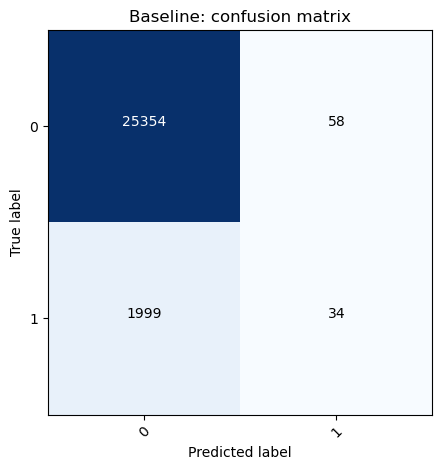

In [63]:
# TN                FP(Type II error)
# 
# FN(Type I error)  TP

cm = confusion_matrix(y_test, bl_y_pred > 0.5)
plot_confusion_matrix(cm, classes=["0", "1"], model_name="Baseline");

#### classification_report

In [64]:
from sklearn.metrics import classification_report

# выбирем порог 0.5
print(classification_report(y_test, bl_y_pred > 0.5))

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     25412
         1.0       0.37      0.02      0.03      2033

    accuracy                           0.93     27445
   macro avg       0.65      0.51      0.50     27445
weighted avg       0.89      0.93      0.89     27445



## 4 sklearn.Pipeline

### 4.1 Column Selector

In [65]:
from sklearn.base import BaseEstimator, TransformerMixin

In [66]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("DataFrame не содердит следующие колонки: %s" % cols_error)

### 4.2 Пайплайн обработки признаков

In [67]:
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [68]:
f_prep_pipeline = make_pipeline(
    ColumnSelector(columns=f_ok),
    FeatureUnion(transformer_list=[
        ("numeric_features", make_pipeline(
            ColumnSelector(f_numeric),
            SimpleImputer(strategy="mean"),
            StandardScaler()
        )),
        ("categorical_features", make_pipeline(
            ColumnSelector(f_categorical),
            SimpleImputer(strategy="most_frequent"),
            OneHotEncoder(handle_unknown='ignore')
        ))
    ])
)

In [69]:
X_test.shape[1]

255

In [70]:
f_prep_pipeline.fit(X_train)

n_features = f_prep_pipeline.transform(X_test).shape[1]
n_features

260

### 4.3 Gridsearch для пайплайнов

In [71]:
lg_pipe = make_pipeline(
    f_prep_pipeline,
    LogisticRegression(random_state=RANDOM_STATE)
)

In [72]:
from sklearn.model_selection import GridSearchCV

In [73]:
def run_grid_search(estimator, X, y, params_grid, cv, scoring='roc_auc'):
    gsc = GridSearchCV(estimator, params_grid, scoring=scoring, cv=cv, n_jobs=-1)

    gsc.fit(X, y)
    print("Best %s score: %.2f" % (scoring, gsc.best_score_))
    print()
    print("Best parameters set found on development set:")
    print()
    print(gsc.best_params_)
    print()
    print("Grid scores on development set:")
    print()

    for i, params in enumerate(gsc.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (gsc.cv_results_['mean_test_score'][i], gsc.cv_results_['std_test_score'][i] * 2, params))

    print()
    
    return gsc

Поиск имен параметров:

In [74]:
[k for k in lg_pipe.get_params().keys() if 'imputer' in k]

['pipeline__featureunion__numeric_features__simpleimputer',
 'pipeline__featureunion__numeric_features__simpleimputer__add_indicator',
 'pipeline__featureunion__numeric_features__simpleimputer__copy',
 'pipeline__featureunion__numeric_features__simpleimputer__fill_value',
 'pipeline__featureunion__numeric_features__simpleimputer__missing_values',
 'pipeline__featureunion__numeric_features__simpleimputer__strategy',
 'pipeline__featureunion__numeric_features__simpleimputer__verbose',
 'pipeline__featureunion__categorical_features__simpleimputer',
 'pipeline__featureunion__categorical_features__simpleimputer__add_indicator',
 'pipeline__featureunion__categorical_features__simpleimputer__copy',
 'pipeline__featureunion__categorical_features__simpleimputer__fill_value',
 'pipeline__featureunion__categorical_features__simpleimputer__missing_values',
 'pipeline__featureunion__categorical_features__simpleimputer__strategy',
 'pipeline__featureunion__categorical_features__simpleimputer__verbos

Сравним с baseline моделью, у которой roc_auc = 0.84 (+/- 0.01)

In [75]:
param_grid = {
    "logisticregression__penalty": ['l1', 'l2'],
    "logisticregression__C": [0.01, 0.1, 5.0]
}

lg_gsc = run_grid_search(lg_pipe, X_train, y_train, param_grid, kfold_cv)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
9 fits failed out of a total of 18.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, se

Best roc_auc score: 0.84

Best parameters set found on development set:

{'logisticregression__C': 5.0, 'logisticregression__penalty': 'l2'}

Grid scores on development set:

nan (+/-nan) for {'logisticregression__C': 0.01, 'logisticregression__penalty': 'l1'}
0.837 (+/-0.006) for {'logisticregression__C': 0.01, 'logisticregression__penalty': 'l2'}
nan (+/-nan) for {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l1'}
0.837 (+/-0.004) for {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l2'}
nan (+/-nan) for {'logisticregression__C': 5.0, 'logisticregression__penalty': 'l1'}
0.838 (+/-0.005) for {'logisticregression__C': 5.0, 'logisticregression__penalty': 'l2'}



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [76]:
lg_gsc.best_params_

{'logisticregression__C': 5.0, 'logisticregression__penalty': 'l2'}

#### остановимся на том, что коэф С=5.0, регуляризация l2

### 4.4 Отбор признаков в пайплайнах

In [77]:
from sklearn.feature_selection import SelectFromModel

Атрибут estimator класса SelectFromModel должен иметь хотя бы один из атрибутов feature_importances_ или coef_ после выполнения метода fit.

In [78]:
#  Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.
# по атрибуту threshold будет отрезаться признак, если он меньше заданного значения этого атрибута
fs_pipe = make_pipeline(
    f_prep_pipeline,
    SelectFromModel(LogisticRegression(penalty='l2', random_state=RANDOM_STATE), threshold=1e-5),
)

In [79]:
f_prep_pipeline.fit(X_train)
f_prep_pipeline.transform(X_test).shape

(27445, 260)

In [80]:
fs_pipe.fit(X_train, y_train)
fs_pipe.transform(X_test).shape

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(27445, 257)

In [81]:
lg_fs_pipe = make_pipeline(
    f_prep_pipeline,
    SelectFromModel(LogisticRegression(penalty='l2', random_state=RANDOM_STATE), threshold=1e-5),
    LogisticRegression(random_state=RANDOM_STATE)
)

In [82]:
# исследуем при разных количествах признаков, независимо от threshold
param_grid = [
    {"selectfrommodel__max_features": [None, 5, 10, 50, 100, 150], "selectfrommodel__threshold": [-np.inf]},
    {"selectfrommodel__threshold": [1e-5]},
]

lg_fs_gsc = run_grid_search(lg_fs_pipe, X_train, y_train, param_grid, kfold_cv)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best roc_auc score: 0.84

Best parameters set found on development set:

{'selectfrommodel__max_features': 10, 'selectfrommodel__threshold': -inf}

Grid scores on development set:

0.838 (+/-0.005) for {'selectfrommodel__max_features': None, 'selectfrommodel__threshold': -inf}
0.840 (+/-0.009) for {'selectfrommodel__max_features': 5, 'selectfrommodel__threshold': -inf}
0.842 (+/-0.012) for {'selectfrommodel__max_features': 10, 'selectfrommodel__threshold': -inf}
0.840 (+/-0.009) for {'selectfrommodel__max_features': 50, 'selectfrommodel__threshold': -inf}
0.840 (+/-0.006) for {'selectfrommodel__max_features': 100, 'selectfrommodel__threshold': -inf}
0.839 (+/-0.004) for {'selectfrommodel__max_features': 150, 'selectfrommodel__threshold': -inf}
0.838 (+/-0.005) for {'selectfrommodel__threshold': 1e-05}



**Вывод:** при количестве признаков 5, 10 roc_auc незначительно отличается от максимального значения. Если возьмем 10 признаков, то сэкономим 250 признаков и не потеряем нашей метрики.

### 5. пайплан  GradientBoosting

In [83]:
from sklearn.ensemble import GradientBoostingClassifier

In [84]:
# создадим пайплайн с отбром признаков через лог.регрессию с регуляризаией l2, в конце эстимейтром  GradientBoostingClassifier
gb_fs_pipe = make_pipeline(
    f_prep_pipeline,
    SelectFromModel(LogisticRegression(penalty='l2', random_state=RANDOM_STATE), threshold=1e-5),
    GradientBoostingClassifier()
)

In [85]:
[k for k in gb_fs_pipe.get_params().keys() if 'grad' in k]

['gradientboostingclassifier',
 'gradientboostingclassifier__ccp_alpha',
 'gradientboostingclassifier__criterion',
 'gradientboostingclassifier__init',
 'gradientboostingclassifier__learning_rate',
 'gradientboostingclassifier__loss',
 'gradientboostingclassifier__max_depth',
 'gradientboostingclassifier__max_features',
 'gradientboostingclassifier__max_leaf_nodes',
 'gradientboostingclassifier__min_impurity_decrease',
 'gradientboostingclassifier__min_samples_leaf',
 'gradientboostingclassifier__min_samples_split',
 'gradientboostingclassifier__min_weight_fraction_leaf',
 'gradientboostingclassifier__n_estimators',
 'gradientboostingclassifier__n_iter_no_change',
 'gradientboostingclassifier__random_state',
 'gradientboostingclassifier__subsample',
 'gradientboostingclassifier__tol',
 'gradientboostingclassifier__validation_fraction',
 'gradientboostingclassifier__verbose',
 'gradientboostingclassifier__warm_start']

In [86]:
param_grid = {
    "selectfrommodel__threshold": [-np.inf, 1e-05],
    
    "gradientboostingclassifier__max_depth": [1, 5],
    "gradientboostingclassifier__n_estimators": [10, 100]
}

gb_fs_gsc = run_grid_search(gb_fs_pipe, X_train, y_train, param_grid, kfold_cv)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best roc_auc score: 0.84

Best parameters set found on development set:

{'gradientboostingclassifier__max_depth': 5, 'gradientboostingclassifier__n_estimators': 10, 'selectfrommodel__threshold': 1e-05}

Grid scores on development set:

0.833 (+/-0.008) for {'gradientboostingclassifier__max_depth': 1, 'gradientboostingclassifier__n_estimators': 10, 'selectfrommodel__threshold': -inf}
0.833 (+/-0.008) for {'gradientboostingclassifier__max_depth': 1, 'gradientboostingclassifier__n_estimators': 10, 'selectfrommodel__threshold': 1e-05}
0.840 (+/-0.010) for {'gradientboostingclassifier__max_depth': 1, 'gradientboostingclassifier__n_estimators': 100, 'selectfrommodel__threshold': -inf}
0.840 (+/-0.010) for {'gradientboostingclassifier__max_depth': 1, 'gradientboostingclassifier__n_estimators': 100, 'selectfrommodel__threshold': 1e-05}
0.841 (+/-0.013) for {'gradientboostingclassifier__max_depth': 5, 'gradientboostingclassifier__n_estimators': 10, 'selectfrommodel__threshold': -inf}
0.841 (+/

### 5.1 Сравнение моделей  с лог.регрессией и с градиентным бустингом

In [87]:
lg_fs_pipe_final = lg_fs_gsc.best_estimator_

lg_fs_pipe_final.fit(X_train, y_train)

lg_fs_pred = lg_fs_pipe_final.predict_proba(X_test)[:,1]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [88]:
print(classification_report(y_test, lg_fs_pred > 0.5))

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     25412
         1.0       0.00      0.00      0.00      2033

    accuracy                           0.93     27445
   macro avg       0.46      0.50      0.48     27445
weighted avg       0.86      0.93      0.89     27445



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [89]:
gb_fs_pipe_final = gb_fs_gsc.best_estimator_

gb_fs_pipe_final.fit(X_train, y_train)

gb_fs_pred = gb_fs_pipe_final.predict_proba(X_test)[:,1]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [90]:
print(classification_report(y_test, gb_fs_pred > 0.5))

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     25412
         1.0       0.33      0.00      0.00      2033

    accuracy                           0.93     27445
   macro avg       0.63      0.50      0.48     27445
weighted avg       0.88      0.93      0.89     27445



Вывод: модель с градиентым бустингом дает значения precision (0.93=0.93), recall (1=1) и f1-score(0.96=0.96). То есть с точки зрения бизнеса она не лучше.

Baseline: AUC_PR = 0.344
Baseline: AUC_ROC = 0.844
lg_fs_pred: AUC_PR = 0.439
lg_fs_pred: AUC_ROC = 0.842
gb_fs_pred: AUC_PR = 0.356
gb_fs_pred: AUC_ROC = 0.845


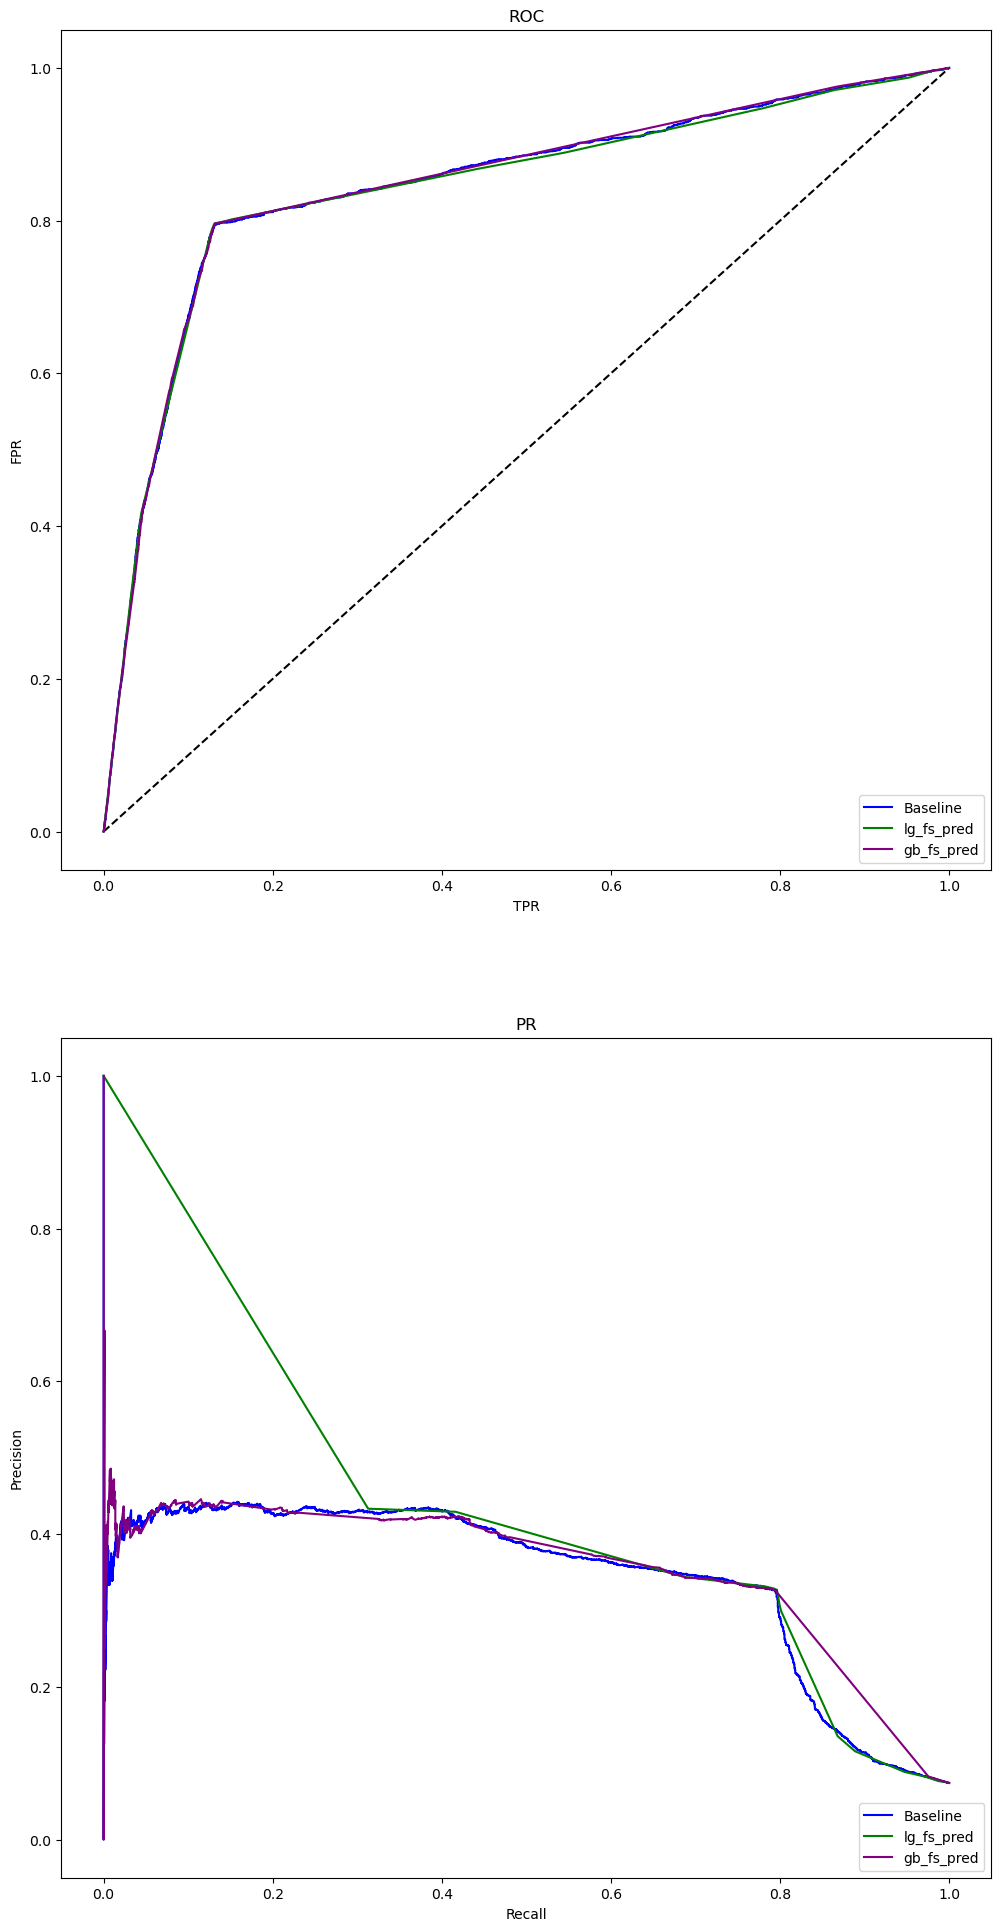

In [91]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

f.set_figheight(24)
f.set_figwidth(12)

ax1 = plt.subplot(211)
ax1.set_title('ROC')
ax1.set_xlabel('TPR')
ax1.set_ylabel('FPR')


ax2 = plt.subplot(212)
ax2.set_title('PR')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')

ax1.plot([0, 1], [0, 1], 'k--')

fpr, tpr, roc_thresholds = roc_curve(y_test, bl_y_pred)
precision, recall, pr_thresholds = precision_recall_curve(y_test, bl_y_pred)
ax1.plot(fpr, tpr, label='Baseline', color='b')
ax2.plot(recall, precision, label='Baseline', color='b')
print("Baseline: AUC_PR = %.3f" % auc(recall, precision))
print("Baseline: AUC_ROC = %.3f" % auc(fpr, tpr))


fpr, tpr, roc_thresholds = roc_curve(y_test, lg_fs_pred)
precision, recall, pr_thresholds = precision_recall_curve(y_test, lg_fs_pred)
ax1.plot(fpr, tpr, label="lg_fs_pred", color='g')
ax2.plot(recall, precision, label="lg_fs_pred", color='g')
print("lg_fs_pred: AUC_PR = %.3f" % auc(recall, precision))
print("lg_fs_pred: AUC_ROC = %.3f" % auc(fpr, tpr))


fpr, tpr, roc_thresholds = roc_curve(y_test, gb_fs_pred)
precision, recall, pr_thresholds = precision_recall_curve(y_test, gb_fs_pred)
ax1.plot(fpr, tpr, label="gb_fs_pred", color='purple')
ax2.plot(recall, precision, label="gb_fs_pred", color='purple')
print("gb_fs_pred: AUC_PR = %.3f" % auc(recall, precision))
print("gb_fs_pred: AUC_ROC = %.3f" % auc(fpr, tpr))
ax1.legend(loc="lower right")
ax2.legend(loc="lower right");

### 6. Библиотека LogisticRegression

#### 6.1 Разделяем на на тренировочную, валидационную выборки и веса

0.0    0.927631
1.0    0.072369
Name: target, dtype: float64

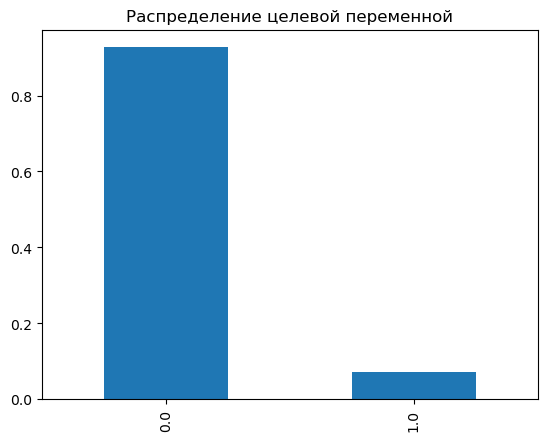

In [138]:
(y.value_counts()/y.shape[0]).plot(kind='bar', title='Распределение целевой переменной');
y.value_counts()/y.shape

In [139]:
RANDOM_STATE = 42

X_train, X_valid, y_train, y_valid = train_test_split(X[f_ok], y, train_size=0.1, test_size=0.033, random_state=RANDOM_STATE)

columns_data = X_train.columns.drop(f_weight)

X_train_weight = X_train[f_weight].values.flatten()
X_valid_weight = X_valid[f_weight].values.flatten()

X_train = X_train.drop(f_weight, axis=1)
X_valid = X_valid.drop(f_weight, axis=1)

In [140]:
print("Train")
print(y_train.value_counts()/y_train.shape)
print()
print("Test")
print(y_valid.value_counts()/y_valid.shape)

Train
0.0    0.928095
1.0    0.071905
Name: target, dtype: float64

Test
0.0    0.925925
1.0    0.074075
Name: target, dtype: float64


#### 6.2 Пайплайн для обработки признаков

Логистическая регрессия требует отмасштабированные числовые признаки и перекодированные в числовые категориальные признаки.

In [141]:
# пайплайн для числовых признаков
f_num_pipepline = make_pipeline(
    SimpleImputer(strategy="mean"),
    StandardScaler()
)

# пайплайн для категориальных признаков
f_cat_pipepline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown='ignore')
)

# объединяющий пайплайн
preproc_pipeline = make_column_transformer(
    (f_num_pipepline, f_numeric),
    (f_cat_pipepline, f_categorical)
)

#### 6.3 Поиск и обучение модели с применением пайплайнов

Схема пайплайна:

**|Предобработка данных| >>> |Селекция признаков| >>> |Модель логистической регрессии|**

Селектор признаков - SelectPercentile() отбирает задаваемый процент лучших признаков.

Модель логистической регрессии с автоматической балансировкой классов class_weight='balanced'.

In [142]:
logreg_pp = Pipeline([
    ('prepoc', preproc_pipeline),
    ('selector', SelectPercentile()),
    ('model', LogisticRegression(n_jobs=-1,
                                 random_state=RANDOM_STATE,
                                 class_weight='balanced',
                                 max_iter=200))
])

##### Cетка гиперпараметров

In [143]:
params = {
    'selector__percentile': [5, 10],
    'model__C': [0.01, 0.1, 5]   
}

##### Поиск наилучшей модели по сетке гиперпараметров с использованием кросс-валидации

In [144]:
logreg_model = GridSearchCV(estimator=logreg_pp,
                            param_grid=params,
                            cv=3,
                            scoring='roc_auc',
                            n_jobs=-1,
                            verbose=1,
                            refit=True)

In [145]:
%%time

_ = logreg_model.fit(X_train, y_train, model__sample_weight=X_train_weight)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Wall time: 27.2 s


##### Параметры наилучшей модели

In [146]:
pd.Series(logreg_model.best_params_)

model__C                 0.01
selector__percentile    10.00
dtype: float64

##### Предсказание на валидационной выборке

* вероятность класса 1
* метки

In [148]:
logreg_proba_1 = logreg_model.predict_proba(X_valid)[:,1]
logreg_pred = logreg_model.predict(X_valid)

#### 6.4 Анализ результатов предсказания

##### ROC-кривая

LogisticRegression: AUC_ROC = 0.847


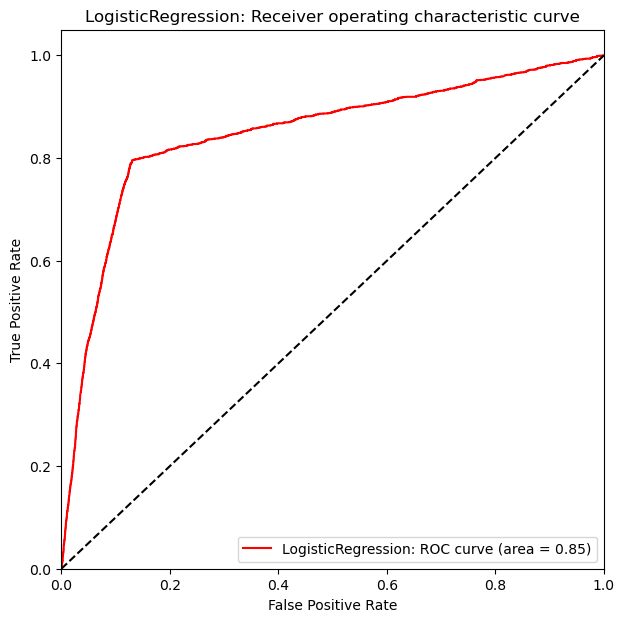

In [150]:
fpr, tpr, _ = roc_curve(y_valid, logreg_proba_1)
plt.figure(figsize=(7, 7))
plot_roc_curve(fpr, tpr, "LogisticRegression", color='r')
print("LogisticRegression: AUC_ROC = %.3f" % auc(fpr, tpr))

Достаточно хороший показатель метркии ROC AUC

##### Precision-Recall-кривая

LogisticRegression: AUC_PR = 0.350


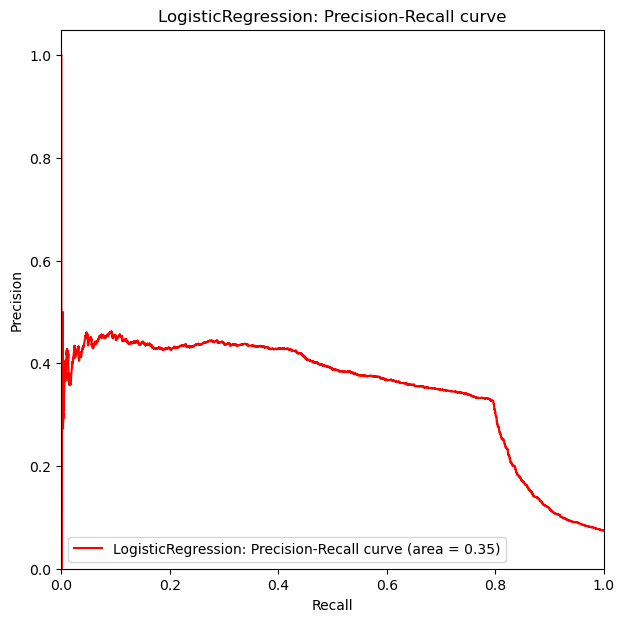

In [151]:
precision, recall, _ = precision_recall_curve(y_valid, logreg_proba_1)

plt.figure(figsize=(7, 7))    
plot_precision_recall_curve(precision, recall, "LogisticRegression", color='r')
print("LogisticRegression: AUC_PR = %.3f" % auc(recall, precision))

##### Матрица смежности

In [152]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          model_name="",
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest',  cmap=cmap)
    
    plt.grid(False)
    plt.title('%s: confusion matrix' % model_name)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[22078  3334]
 [  415  1618]]


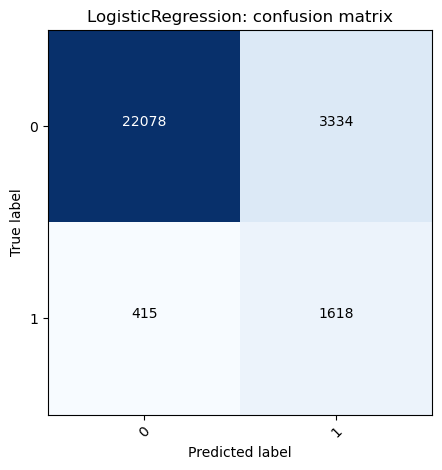

In [153]:
# TN                FP(Type II error)
# 
# FN(Type I error)  TP

cm = confusion_matrix(y_valid, logreg_pred > 0.5)
plot_confusion_matrix(cm, classes=["0", "1"], model_name="LogisticRegression");

Матрица смежности показывает

* в левом верхнем углу количество истинных предсказаний класса 0
* в правом верхнем углу количество ложных предсказаний класса 1 (ошибка второго рода)
* в левом нижнем углу количество ложных предсказаний класса 0 (ошибка первого рода)
* в правом нижнем углу количество истинных предсказаний класса 1

Если принять за нулевую гипотезу - положительный отклик клиента на услугу (класс 1), и осуществлять клиентам рассылку предложений по подключению услуги согласно предсказаниям модели, то

* количество ошибок первого рода характеризует сколько клиентов не получили предложения, хотя потенцаильно они готовы совершить подключение;
* количество ошибок второго рода характеризует сколько клиентов получили предложения, хотя они не собираются совершать подключение.

##### classification_report

In [154]:
# выбирем порог 0.5
print(classification_report(y_valid, logreg_pred > 0.5))

              precision    recall  f1-score   support

         0.0       0.98      0.87      0.92     25412
         1.0       0.33      0.80      0.46      2033

    accuracy                           0.86     27445
   macro avg       0.65      0.83      0.69     27445
weighted avg       0.93      0.86      0.89     27445



### 7. Библиотека Catboost

#### 7.1 Предобработка данных

Catboost не требует масштабировать числовые признаки и кодировать категориальные.

In [155]:
selector = SelectPercentile()
X_cat = selector.fit_transform(X[f_ok], y)
columns = X[f_ok].columns
support = selector.get_support()
selected_columns = columns[support]

for feat in f_categorical+f_weight:
    assert feat in selected_columns

X_cat = pd.DataFrame(X_cat, columns=selected_columns)

X_cat[f_categorical] = X_cat[f_categorical].astype('int').astype('category')

In [156]:
# Зафиксируем значение random_state для воспроизводимости результатов.
RANDOM_STATE = 42

X_train_cat, X_valid_cat, y_train_cat, y_valid_cat = train_test_split(X_cat, y,
                                                                      train_size=0.1,
                                                                      test_size=0.033,
                                                                      random_state=RANDOM_STATE)

#### 7.2 Модель CatBoostClassifier

* Функция потерь: Logloss
* Автобалансировка классов

**Определение гиперпараметров**

Константные параметры:

- loss_function='Logloss' - показатель, используемый для обучения
- eval_metric='F1' - метрика, используемая для обнаружения переобучения
- auto_class_weights='Balanced' - автоматический подбор весов для балансировки классов
- random_seed или random_state – случайное зерно, используемое для обучения
- logging_level='Verbose' - вывод оптимизированных метрик, затраченного и оставшегося времени обучения
- task_type='GPU' – используется CPU или GPU. По умолчанию стоит CPU
- cat_features=f_categorical - массив с категориальными признаками
- one_hot_max_size=20 - максимальное количество уникальных значений среди категориальных признаков
- early_stopping_rounds=50 - отслеживание переобучения


Подбираемые параметры (сетка гиперпараметров):

- depth - глубина дерева
- learning_rate - скорость обучения
- iterations (n_estimators) - максимальное количество построенных деревьев
- l2_leaf_reg - коэффициент при члене регуляризации L2 функции потерь
- bagging_temperature - настройка интенсивности байесовского бутстрапа, по умолчанию=1

In [111]:
frozen_params = {
    'loss_function':'Logloss',
    'eval_metric': 'F1',
    'auto_class_weights': 'Balanced',
    'random_state': 42,
    'logging_level': 'Verbose',
    'task_type': 'CPU',
    'cat_features': f_categorical,
    'one_hot_max_size': 20,
    'early_stopping_rounds': 50,
}

In [112]:
%%time

cat_model = CatBoostClassifier(**frozen_params)

params_grid = {
    'iterations': [100, 200, 500],
    'learning_rate': [0.03, 0.1, 0.3],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 5, 10, 20],
    'bagging_temperature': [1, 1.5, 2]
}

Wall time: 0 ns


##### Рандомизированный поиск по сетке с применением кросс-валидации

Случайным образом по сетке параметров выбирается и проверяется 30 наборов гиперпараметров.

In [113]:
%%time

search_result = cat_model.randomized_search(params_grid,
                                            X=X_train_cat,
                                            y=y_train_cat,
                                            cv=3,
                                            stratified=True,
                                            search_by_train_test_split=False,
                                            n_iter=30)

Training on fold [0/3]
0:	learn: 0.8237767	test: 0.8219937	best: 0.8219937 (0)	total: 178ms	remaining: 17.6s
1:	learn: 0.8163424	test: 0.8145254	best: 0.8219937 (0)	total: 199ms	remaining: 9.76s
2:	learn: 0.8238016	test: 0.8220104	best: 0.8220104 (2)	total: 221ms	remaining: 7.15s
3:	learn: 0.8165627	test: 0.8144586	best: 0.8220104 (2)	total: 249ms	remaining: 5.97s
4:	learn: 0.8155387	test: 0.8134535	best: 0.8220104 (2)	total: 270ms	remaining: 5.13s
5:	learn: 0.8155387	test: 0.8134535	best: 0.8220104 (2)	total: 292ms	remaining: 4.57s
6:	learn: 0.8155387	test: 0.8134535	best: 0.8220104 (2)	total: 314ms	remaining: 4.18s
7:	learn: 0.8155387	test: 0.8134535	best: 0.8220104 (2)	total: 334ms	remaining: 3.84s
8:	learn: 0.8155387	test: 0.8134535	best: 0.8220104 (2)	total: 358ms	remaining: 3.61s
9:	learn: 0.8155387	test: 0.8134535	best: 0.8220104 (2)	total: 382ms	remaining: 3.44s
10:	learn: 0.8155387	test: 0.8134535	best: 0.8220104 (2)	total: 407ms	remaining: 3.29s
11:	learn: 0.8155387	test: 0.8

16:	learn: 0.8121916	test: 0.8201163	best: 0.8272849 (2)	total: 374ms	remaining: 1.82s
17:	learn: 0.8121916	test: 0.8201163	best: 0.8272849 (2)	total: 396ms	remaining: 1.8s
18:	learn: 0.8126466	test: 0.8201163	best: 0.8272849 (2)	total: 416ms	remaining: 1.77s
19:	learn: 0.8159976	test: 0.8211146	best: 0.8272849 (2)	total: 434ms	remaining: 1.74s
20:	learn: 0.8205786	test: 0.8261352	best: 0.8272849 (2)	total: 455ms	remaining: 1.71s
21:	learn: 0.8215348	test: 0.8264134	best: 0.8272849 (2)	total: 476ms	remaining: 1.69s
22:	learn: 0.8213719	test: 0.8259183	best: 0.8272849 (2)	total: 497ms	remaining: 1.66s
23:	learn: 0.8201052	test: 0.8242053	best: 0.8272849 (2)	total: 518ms	remaining: 1.64s
24:	learn: 0.8177737	test: 0.8217084	best: 0.8272849 (2)	total: 537ms	remaining: 1.61s
25:	learn: 0.8214802	test: 0.8256788	best: 0.8272849 (2)	total: 556ms	remaining: 1.58s
26:	learn: 0.8213140	test: 0.8266690	best: 0.8272849 (2)	total: 575ms	remaining: 1.55s
27:	learn: 0.8213513	test: 0.8258516	best: 0

23:	learn: 0.8173702	test: 0.8113927	best: 0.8195279 (2)	total: 475ms	remaining: 1.5s
24:	learn: 0.8174036	test: 0.8111945	best: 0.8195279 (2)	total: 503ms	remaining: 1.51s
25:	learn: 0.8187053	test: 0.8117886	best: 0.8195279 (2)	total: 522ms	remaining: 1.49s
26:	learn: 0.8216546	test: 0.8148149	best: 0.8195279 (2)	total: 541ms	remaining: 1.46s
27:	learn: 0.8198617	test: 0.8129916	best: 0.8195279 (2)	total: 559ms	remaining: 1.44s
28:	learn: 0.8232852	test: 0.8168294	best: 0.8195279 (2)	total: 578ms	remaining: 1.42s
29:	learn: 0.8221182	test: 0.8148981	best: 0.8195279 (2)	total: 599ms	remaining: 1.4s
30:	learn: 0.8235097	test: 0.8180720	best: 0.8195279 (2)	total: 618ms	remaining: 1.38s
31:	learn: 0.8220514	test: 0.8148648	best: 0.8195279 (2)	total: 640ms	remaining: 1.36s
32:	learn: 0.8237127	test: 0.8188294	best: 0.8195279 (2)	total: 659ms	remaining: 1.34s
33:	learn: 0.8250103	test: 0.8196177	best: 0.8196177 (33)	total: 679ms	remaining: 1.32s
34:	learn: 0.8245299	test: 0.8191823	best: 0

34:	learn: 0.8241761	test: 0.8219687	best: 0.8222937 (20)	total: 776ms	remaining: 1.44s
35:	learn: 0.8241761	test: 0.8219687	best: 0.8222937 (20)	total: 795ms	remaining: 1.41s
36:	learn: 0.8241844	test: 0.8219187	best: 0.8222937 (20)	total: 816ms	remaining: 1.39s
37:	learn: 0.8241595	test: 0.8219687	best: 0.8222937 (20)	total: 839ms	remaining: 1.37s
38:	learn: 0.8241511	test: 0.8219687	best: 0.8222937 (20)	total: 859ms	remaining: 1.34s
39:	learn: 0.8241428	test: 0.8219854	best: 0.8222937 (20)	total: 886ms	remaining: 1.33s
40:	learn: 0.8241511	test: 0.8219854	best: 0.8222937 (20)	total: 904ms	remaining: 1.3s
41:	learn: 0.8241678	test: 0.8219520	best: 0.8222937 (20)	total: 929ms	remaining: 1.28s
42:	learn: 0.8241678	test: 0.8219520	best: 0.8222937 (20)	total: 954ms	remaining: 1.26s
43:	learn: 0.8241345	test: 0.8219354	best: 0.8222937 (20)	total: 975ms	remaining: 1.24s
44:	learn: 0.8241262	test: 0.8219354	best: 0.8222937 (20)	total: 1s	remaining: 1.23s
45:	learn: 0.8241345	test: 0.8219354

61:	learn: 0.8213145	test: 0.8273182	best: 0.8275184 (12)	total: 1.32s	remaining: 808ms
62:	learn: 0.8213145	test: 0.8273182	best: 0.8275184 (12)	total: 1.34s	remaining: 787ms

bestTest = 0.8275183564
bestIteration = 12

Training on fold [2/3]
0:	learn: 0.8168128	test: 0.8106645	best: 0.8106645 (0)	total: 20.6ms	remaining: 2.04s
1:	learn: 0.8167961	test: 0.8109295	best: 0.8109295 (1)	total: 39.5ms	remaining: 1.94s
2:	learn: 0.8246767	test: 0.8195279	best: 0.8195279 (2)	total: 58.3ms	remaining: 1.88s
3:	learn: 0.8224516	test: 0.8164804	best: 0.8195279 (2)	total: 80.2ms	remaining: 1.93s
4:	learn: 0.8167877	test: 0.8109295	best: 0.8195279 (2)	total: 108ms	remaining: 2.05s
5:	learn: 0.8167961	test: 0.8109295	best: 0.8195279 (2)	total: 131ms	remaining: 2.05s
6:	learn: 0.8183744	test: 0.8125475	best: 0.8195279 (2)	total: 155ms	remaining: 2.06s
7:	learn: 0.8169438	test: 0.8109129	best: 0.8195279 (2)	total: 178ms	remaining: 2.05s
8:	learn: 0.8233011	test: 0.8162524	best: 0.8195279 (2)	total: 1

32:	learn: 0.8259883	test: 0.8218854	best: 0.8221437 (7)	total: 691ms	remaining: 3.5s
33:	learn: 0.8259883	test: 0.8218687	best: 0.8221437 (7)	total: 714ms	remaining: 3.48s
34:	learn: 0.8261578	test: 0.8215603	best: 0.8221437 (7)	total: 734ms	remaining: 3.46s
35:	learn: 0.8266494	test: 0.8212350	best: 0.8221437 (7)	total: 752ms	remaining: 3.43s
36:	learn: 0.8270656	test: 0.8212183	best: 0.8221437 (7)	total: 770ms	remaining: 3.39s
37:	learn: 0.8274815	test: 0.8212183	best: 0.8221437 (7)	total: 791ms	remaining: 3.37s
38:	learn: 0.8274982	test: 0.8212017	best: 0.8221437 (7)	total: 811ms	remaining: 3.35s
39:	learn: 0.8280744	test: 0.8211517	best: 0.8221437 (7)	total: 830ms	remaining: 3.32s
40:	learn: 0.8282517	test: 0.8208929	best: 0.8221437 (7)	total: 850ms	remaining: 3.29s
41:	learn: 0.8280994	test: 0.8208263	best: 0.8221437 (7)	total: 869ms	remaining: 3.27s
42:	learn: 0.8281244	test: 0.8208596	best: 0.8221437 (7)	total: 889ms	remaining: 3.25s
43:	learn: 0.8278781	test: 0.8208596	best: 0

78:	learn: 0.8379450	test: 0.8249788	best: 0.8274183 (43)	total: 1.62s	remaining: 2.48s
79:	learn: 0.8385529	test: 0.8249622	best: 0.8274183 (43)	total: 1.64s	remaining: 2.46s
80:	learn: 0.8391350	test: 0.8248956	best: 0.8274183 (43)	total: 1.67s	remaining: 2.45s
81:	learn: 0.8384952	test: 0.8246226	best: 0.8274183 (43)	total: 1.69s	remaining: 2.42s
82:	learn: 0.8397094	test: 0.8243662	best: 0.8274183 (43)	total: 1.71s	remaining: 2.4s
83:	learn: 0.8402081	test: 0.8247059	best: 0.8274183 (43)	total: 1.73s	remaining: 2.38s
84:	learn: 0.8406730	test: 0.8247891	best: 0.8274183 (43)	total: 1.74s	remaining: 2.36s
85:	learn: 0.8415764	test: 0.8244994	best: 0.8274183 (43)	total: 1.76s	remaining: 2.34s
86:	learn: 0.8422311	test: 0.8247725	best: 0.8274183 (43)	total: 1.78s	remaining: 2.31s
87:	learn: 0.8434464	test: 0.8244661	best: 0.8274183 (43)	total: 1.8s	remaining: 2.29s
88:	learn: 0.8436202	test: 0.8250954	best: 0.8274183 (43)	total: 1.82s	remaining: 2.27s
89:	learn: 0.8442562	test: 0.82429

33:	learn: 0.8242094	test: 0.8223437	best: 0.8223437 (31)	total: 685ms	remaining: 9.38s
34:	learn: 0.8242094	test: 0.8223437	best: 0.8223437 (31)	total: 709ms	remaining: 9.42s
35:	learn: 0.8242261	test: 0.8223437	best: 0.8223437 (31)	total: 730ms	remaining: 9.41s
36:	learn: 0.8242094	test: 0.8223270	best: 0.8223437 (31)	total: 751ms	remaining: 9.39s
37:	learn: 0.8242178	test: 0.8223437	best: 0.8223437 (31)	total: 769ms	remaining: 9.35s
38:	learn: 0.8242511	test: 0.8223437	best: 0.8223437 (31)	total: 790ms	remaining: 9.33s
39:	learn: 0.8241761	test: 0.8223270	best: 0.8223437 (31)	total: 808ms	remaining: 9.29s
40:	learn: 0.8243211	test: 0.8223270	best: 0.8223437 (31)	total: 826ms	remaining: 9.25s
41:	learn: 0.8243627	test: 0.8223270	best: 0.8223437 (31)	total: 845ms	remaining: 9.22s
42:	learn: 0.8243544	test: 0.8223270	best: 0.8223437 (31)	total: 865ms	remaining: 9.19s
43:	learn: 0.8243711	test: 0.8220187	best: 0.8223437 (31)	total: 885ms	remaining: 9.17s
44:	learn: 0.8243627	test: 0.822

47:	learn: 0.8214975	test: 0.8271965	best: 0.8274683 (31)	total: 981ms	remaining: 9.23s
48:	learn: 0.8214975	test: 0.8271965	best: 0.8274683 (31)	total: 1s	remaining: 9.22s
49:	learn: 0.8214975	test: 0.8271965	best: 0.8274683 (31)	total: 1.02s	remaining: 9.21s
50:	learn: 0.8215058	test: 0.8272298	best: 0.8274683 (31)	total: 1.04s	remaining: 9.18s
51:	learn: 0.8214809	test: 0.8269078	best: 0.8274683 (31)	total: 1.06s	remaining: 9.15s
52:	learn: 0.8214725	test: 0.8269078	best: 0.8274683 (31)	total: 1.08s	remaining: 9.12s
53:	learn: 0.8214892	test: 0.8269078	best: 0.8274683 (31)	total: 1.1s	remaining: 9.1s
54:	learn: 0.8214892	test: 0.8269078	best: 0.8274683 (31)	total: 1.12s	remaining: 9.08s
55:	learn: 0.8214892	test: 0.8269245	best: 0.8274683 (31)	total: 1.14s	remaining: 9.05s
56:	learn: 0.8214393	test: 0.8272132	best: 0.8274683 (31)	total: 1.16s	remaining: 9.03s
57:	learn: 0.8214476	test: 0.8272132	best: 0.8274683 (31)	total: 1.18s	remaining: 9s
58:	learn: 0.8214642	test: 0.8272298	bes

60:	learn: 0.8255317	test: 0.8195346	best: 0.8198268 (48)	total: 1.23s	remaining: 8.86s
61:	learn: 0.8255317	test: 0.8195346	best: 0.8198268 (48)	total: 1.26s	remaining: 8.88s
62:	learn: 0.8255401	test: 0.8195346	best: 0.8198268 (48)	total: 1.28s	remaining: 8.86s
63:	learn: 0.8256933	test: 0.8195346	best: 0.8198268 (48)	total: 1.29s	remaining: 8.83s
64:	learn: 0.8256849	test: 0.8192256	best: 0.8198268 (48)	total: 1.31s	remaining: 8.8s
65:	learn: 0.8256849	test: 0.8195346	best: 0.8198268 (48)	total: 1.33s	remaining: 8.77s
66:	learn: 0.8256849	test: 0.8192256	best: 0.8198268 (48)	total: 1.35s	remaining: 8.74s
67:	learn: 0.8258381	test: 0.8192256	best: 0.8198268 (48)	total: 1.37s	remaining: 8.72s
68:	learn: 0.8258548	test: 0.8192422	best: 0.8198268 (48)	total: 1.39s	remaining: 8.69s
69:	learn: 0.8258548	test: 0.8192422	best: 0.8198268 (48)	total: 1.41s	remaining: 8.66s
70:	learn: 0.8261610	test: 0.8192422	best: 0.8198268 (48)	total: 1.43s	remaining: 8.64s
71:	learn: 0.8261693	test: 0.8192

7:	learn: 0.8212812	test: 0.8272682	best: 0.8274516 (3)	total: 258ms	remaining: 2.97s
8:	learn: 0.8212812	test: 0.8272849	best: 0.8274516 (3)	total: 293ms	remaining: 2.96s
9:	learn: 0.8213145	test: 0.8273349	best: 0.8274516 (3)	total: 323ms	remaining: 2.91s
10:	learn: 0.8215101	test: 0.8273516	best: 0.8274516 (3)	total: 356ms	remaining: 2.88s
11:	learn: 0.8215684	test: 0.8273849	best: 0.8274516 (3)	total: 387ms	remaining: 2.84s
12:	learn: 0.8215268	test: 0.8273849	best: 0.8274516 (3)	total: 418ms	remaining: 2.8s
13:	learn: 0.8216892	test: 0.8274016	best: 0.8274516 (3)	total: 450ms	remaining: 2.76s
14:	learn: 0.8218598	test: 0.8274183	best: 0.8274516 (3)	total: 490ms	remaining: 2.78s
15:	learn: 0.8218764	test: 0.8271465	best: 0.8274516 (3)	total: 522ms	remaining: 2.74s
16:	learn: 0.8217058	test: 0.8271465	best: 0.8274516 (3)	total: 555ms	remaining: 2.71s
17:	learn: 0.8221510	test: 0.8271465	best: 0.8274516 (3)	total: 584ms	remaining: 2.66s
18:	learn: 0.8229950	test: 0.8268911	best: 0.82

49:	learn: 0.8500346	test: 0.8150068	best: 0.8197271 (2)	total: 1.65s	remaining: 1.65s
50:	learn: 0.8512448	test: 0.8145455	best: 0.8197271 (2)	total: 1.68s	remaining: 1.62s
51:	learn: 0.8517326	test: 0.8142502	best: 0.8197271 (2)	total: 1.71s	remaining: 1.58s
52:	learn: 0.8520515	test: 0.8136423	best: 0.8197271 (2)	total: 1.75s	remaining: 1.55s

bestTest = 0.8197271265
bestIteration = 2

4:	loss: 0.8152321	best: 0.8230464 (0)	total: 26.8s	remaining: 2m 13s
Training on fold [0/3]
0:	learn: 0.8238515	test: 0.8211684	best: 0.8211684 (0)	total: 38.4ms	remaining: 7.63s
1:	learn: 0.8240346	test: 0.8209595	best: 0.8211684 (0)	total: 68.7ms	remaining: 6.8s
2:	learn: 0.8242295	test: 0.8207339	best: 0.8211684 (0)	total: 100ms	remaining: 6.59s
3:	learn: 0.8243711	test: 0.8204581	best: 0.8211684 (0)	total: 132ms	remaining: 6.48s
4:	learn: 0.8242760	test: 0.8201488	best: 0.8211684 (0)	total: 164ms	remaining: 6.4s
5:	learn: 0.8244710	test: 0.8202321	best: 0.8211684 (0)	total: 196ms	remaining: 6.34s

38:	learn: 0.8368890	test: 0.8231661	best: 0.8274850 (6)	total: 1.3s	remaining: 5.36s
39:	learn: 0.8378500	test: 0.8231827	best: 0.8274850 (6)	total: 1.33s	remaining: 5.34s
40:	learn: 0.8394263	test: 0.8220005	best: 0.8274850 (6)	total: 1.37s	remaining: 5.31s
41:	learn: 0.8411147	test: 0.8223255	best: 0.8274850 (6)	total: 1.4s	remaining: 5.27s
42:	learn: 0.8427250	test: 0.8229083	best: 0.8274850 (6)	total: 1.43s	remaining: 5.24s
43:	learn: 0.8436777	test: 0.8222588	best: 0.8274850 (6)	total: 1.47s	remaining: 5.2s
44:	learn: 0.8446374	test: 0.8220672	best: 0.8274850 (6)	total: 1.5s	remaining: 5.17s
45:	learn: 0.8449093	test: 0.8211413	best: 0.8274850 (6)	total: 1.54s	remaining: 5.16s
46:	learn: 0.8465024	test: 0.8218088	best: 0.8274850 (6)	total: 1.57s	remaining: 5.13s
47:	learn: 0.8481636	test: 0.8212080	best: 0.8274850 (6)	total: 1.61s	remaining: 5.1s
48:	learn: 0.8493950	test: 0.8208657	best: 0.8274850 (6)	total: 1.64s	remaining: 5.06s
49:	learn: 0.8507375	test: 0.8205732	best: 0.827

22:	learn: 0.8458257	test: 0.8146813	best: 0.8203582 (0)	total: 2.38s	remaining: 7.97s
23:	learn: 0.8479081	test: 0.8142384	best: 0.8203582 (0)	total: 2.5s	remaining: 7.93s
24:	learn: 0.8486433	test: 0.8136782	best: 0.8203582 (0)	total: 2.69s	remaining: 8.08s
25:	learn: 0.8501246	test: 0.8134478	best: 0.8203582 (0)	total: 2.82s	remaining: 8.02s
26:	learn: 0.8524062	test: 0.8133173	best: 0.8203582 (0)	total: 2.94s	remaining: 7.95s
27:	learn: 0.8531632	test: 0.8131199	best: 0.8203582 (0)	total: 3.04s	remaining: 7.83s
28:	learn: 0.8557393	test: 0.8125413	best: 0.8203582 (0)	total: 3.16s	remaining: 7.73s
29:	learn: 0.8560740	test: 0.8122101	best: 0.8203582 (0)	total: 3.27s	remaining: 7.62s
30:	learn: 0.8603293	test: 0.8110667	best: 0.8203582 (0)	total: 3.4s	remaining: 7.56s
31:	learn: 0.8616495	test: 0.8088884	best: 0.8203582 (0)	total: 3.5s	remaining: 7.45s
32:	learn: 0.8636167	test: 0.8079874	best: 0.8203582 (0)	total: 3.6s	remaining: 7.31s
33:	learn: 0.8640673	test: 0.8073193	best: 0.82

11:	learn: 0.8295228	test: 0.8143332	best: 0.8182812 (3)	total: 1.25s	remaining: 9.15s
12:	learn: 0.8296819	test: 0.8147282	best: 0.8182812 (3)	total: 1.38s	remaining: 9.25s
13:	learn: 0.8316435	test: 0.8142203	best: 0.8182812 (3)	total: 1.5s	remaining: 9.21s
14:	learn: 0.8317106	test: 0.8143498	best: 0.8182812 (3)	total: 1.6s	remaining: 9.06s
15:	learn: 0.8328663	test: 0.8148278	best: 0.8182812 (3)	total: 1.7s	remaining: 8.92s
16:	learn: 0.8334564	test: 0.8144826	best: 0.8182812 (3)	total: 1.81s	remaining: 8.86s
17:	learn: 0.8356848	test: 0.8133990	best: 0.8182812 (3)	total: 1.96s	remaining: 8.92s
18:	learn: 0.8386175	test: 0.8140076	best: 0.8182812 (3)	total: 2.06s	remaining: 8.79s
19:	learn: 0.8399292	test: 0.8139910	best: 0.8182812 (3)	total: 2.16s	remaining: 8.65s
20:	learn: 0.8410839	test: 0.8138144	best: 0.8182812 (3)	total: 2.26s	remaining: 8.52s
21:	learn: 0.8450771	test: 0.8100820	best: 0.8182812 (3)	total: 2.37s	remaining: 8.39s
22:	learn: 0.8499333	test: 0.8088544	best: 0.8

50:	learn: 0.8340561	test: 0.8176466	best: 0.8210172 (8)	total: 5.3s	remaining: 46.7s
51:	learn: 0.8344170	test: 0.8176466	best: 0.8210172 (8)	total: 5.4s	remaining: 46.6s
52:	learn: 0.8345848	test: 0.8171075	best: 0.8210172 (8)	total: 5.51s	remaining: 46.5s
53:	learn: 0.8349287	test: 0.8162059	best: 0.8210172 (8)	total: 5.63s	remaining: 46.5s
54:	learn: 0.8361770	test: 0.8168793	best: 0.8210172 (8)	total: 5.75s	remaining: 46.5s
55:	learn: 0.8364618	test: 0.8166343	best: 0.8210172 (8)	total: 5.87s	remaining: 46.6s
56:	learn: 0.8367629	test: 0.8166343	best: 0.8210172 (8)	total: 5.98s	remaining: 46.5s
57:	learn: 0.8374738	test: 0.8159772	best: 0.8210172 (8)	total: 6.09s	remaining: 46.4s
58:	learn: 0.8379416	test: 0.8160439	best: 0.8210172 (8)	total: 6.18s	remaining: 46.2s

bestTest = 0.821017227
bestIteration = 8

Training on fold [1/3]
0:	learn: 0.8124072	test: 0.8193182	best: 0.8193182 (0)	total: 95ms	remaining: 47.4s
1:	learn: 0.8181598	test: 0.8230186	best: 0.8230186 (1)	total: 191ms

12:	learn: 0.8256228	test: 0.8168527	best: 0.8182539 (11)	total: 1.43s	remaining: 53.5s
13:	learn: 0.8257147	test: 0.8161029	best: 0.8182539 (11)	total: 1.56s	remaining: 54.1s
14:	learn: 0.8256198	test: 0.8155469	best: 0.8182539 (11)	total: 1.68s	remaining: 54.3s
15:	learn: 0.8257033	test: 0.8153018	best: 0.8182539 (11)	total: 1.79s	remaining: 54.3s
16:	learn: 0.8257732	test: 0.8163641	best: 0.8182539 (11)	total: 1.91s	remaining: 54.3s
17:	learn: 0.8256478	test: 0.8181601	best: 0.8182539 (11)	total: 2.09s	remaining: 55.9s
18:	learn: 0.8256228	test: 0.8184699	best: 0.8184699 (18)	total: 2.23s	remaining: 56.4s
19:	learn: 0.8258012	test: 0.8178667	best: 0.8184699 (18)	total: 2.35s	remaining: 56.4s
20:	learn: 0.8257594	test: 0.8169357	best: 0.8184699 (18)	total: 2.46s	remaining: 56.2s
21:	learn: 0.8258346	test: 0.8169689	best: 0.8184699 (18)	total: 2.58s	remaining: 56s
22:	learn: 0.8258012	test: 0.8172130	best: 0.8184699 (18)	total: 2.68s	remaining: 55.6s
23:	learn: 0.8257511	test: 0.81792

19:	learn: 0.8243192	test: 0.8204821	best: 0.8204821 (19)	total: 2.25s	remaining: 54.1s
20:	learn: 0.8243510	test: 0.8213262	best: 0.8213262 (20)	total: 2.36s	remaining: 53.9s
21:	learn: 0.8244142	test: 0.8204488	best: 0.8213262 (20)	total: 2.5s	remaining: 54.2s
22:	learn: 0.8243760	test: 0.8210339	best: 0.8213262 (20)	total: 2.62s	remaining: 54.3s
23:	learn: 0.8242844	test: 0.8215516	best: 0.8215516 (23)	total: 2.73s	remaining: 54.3s
24:	learn: 0.8242393	test: 0.8213095	best: 0.8215516 (23)	total: 2.85s	remaining: 54.2s
25:	learn: 0.8244642	test: 0.8204655	best: 0.8215516 (23)	total: 2.97s	remaining: 54.2s
26:	learn: 0.8243760	test: 0.8210172	best: 0.8215516 (23)	total: 3.09s	remaining: 54.1s
27:	learn: 0.8245093	test: 0.8207914	best: 0.8215516 (23)	total: 3.21s	remaining: 54.1s
28:	learn: 0.8243760	test: 0.8212762	best: 0.8215516 (23)	total: 3.28s	remaining: 53.2s
29:	learn: 0.8242261	test: 0.8214850	best: 0.8215516 (23)	total: 3.4s	remaining: 53.2s
30:	learn: 0.8241678	test: 0.82200

29:	learn: 0.8220221	test: 0.8244124	best: 0.8251597 (10)	total: 3.36s	remaining: 52.6s
30:	learn: 0.8221138	test: 0.8250994	best: 0.8251597 (10)	total: 3.46s	remaining: 52.4s
31:	learn: 0.8220513	test: 0.8252662	best: 0.8252662 (31)	total: 3.57s	remaining: 52.2s
32:	learn: 0.8220138	test: 0.8250994	best: 0.8252662 (31)	total: 3.67s	remaining: 51.9s
33:	learn: 0.8219596	test: 0.8251661	best: 0.8252662 (31)	total: 3.69s	remaining: 50.5s
34:	learn: 0.8220180	test: 0.8253162	best: 0.8253162 (34)	total: 3.8s	remaining: 50.5s
35:	learn: 0.8220304	test: 0.8254225	best: 0.8254225 (35)	total: 3.9s	remaining: 50.3s
36:	learn: 0.8219221	test: 0.8255788	best: 0.8255788 (36)	total: 4s	remaining: 50.1s
37:	learn: 0.8218139	test: 0.8257849	best: 0.8257849 (37)	total: 4.12s	remaining: 50.1s
38:	learn: 0.8217556	test: 0.8263133	best: 0.8263133 (38)	total: 4.25s	remaining: 50.2s
39:	learn: 0.8216224	test: 0.8262633	best: 0.8263133 (38)	total: 4.37s	remaining: 50.3s
40:	learn: 0.8215807	test: 0.8265523	

123:	learn: 0.8216890	test: 0.8271965	best: 0.8271965 (103)	total: 14.1s	remaining: 42.6s
124:	learn: 0.8216890	test: 0.8271965	best: 0.8271965 (103)	total: 14.2s	remaining: 42.5s
125:	learn: 0.8216890	test: 0.8271965	best: 0.8271965 (103)	total: 14.3s	remaining: 42.4s
126:	learn: 0.8216723	test: 0.8271965	best: 0.8271965 (103)	total: 14.4s	remaining: 42.3s
127:	learn: 0.8216890	test: 0.8272132	best: 0.8272132 (127)	total: 14.5s	remaining: 42.2s
128:	learn: 0.8216973	test: 0.8271965	best: 0.8272132 (127)	total: 14.7s	remaining: 42.1s
129:	learn: 0.8217056	test: 0.8272132	best: 0.8272132 (127)	total: 14.8s	remaining: 42.1s
130:	learn: 0.8217139	test: 0.8271965	best: 0.8272132 (127)	total: 14.9s	remaining: 42s
131:	learn: 0.8217223	test: 0.8271965	best: 0.8272132 (127)	total: 15.1s	remaining: 42s
132:	learn: 0.8217389	test: 0.8271965	best: 0.8272132 (127)	total: 15.3s	remaining: 42.2s
133:	learn: 0.8217139	test: 0.8272132	best: 0.8272132 (127)	total: 15.4s	remaining: 42.1s
134:	learn: 0.

19:	learn: 0.8216207	test: 0.8126140	best: 0.8133215 (11)	total: 2.13s	remaining: 51.2s
20:	learn: 0.8246200	test: 0.8135847	best: 0.8135847 (20)	total: 2.24s	remaining: 51.1s
21:	learn: 0.8221560	test: 0.8131911	best: 0.8135847 (20)	total: 2.35s	remaining: 51s
22:	learn: 0.8249813	test: 0.8137812	best: 0.8137812 (22)	total: 2.46s	remaining: 51.1s
23:	learn: 0.8253986	test: 0.8162903	best: 0.8162903 (23)	total: 2.53s	remaining: 50.2s
24:	learn: 0.8251550	test: 0.8136648	best: 0.8162903 (23)	total: 2.65s	remaining: 50.3s
25:	learn: 0.8250231	test: 0.8135015	best: 0.8162903 (23)	total: 2.76s	remaining: 50.4s
26:	learn: 0.8240792	test: 0.8130415	best: 0.8162903 (23)	total: 2.89s	remaining: 50.6s
27:	learn: 0.8253422	test: 0.8137313	best: 0.8162903 (23)	total: 3.04s	remaining: 51.2s
28:	learn: 0.8258424	test: 0.8157007	best: 0.8162903 (23)	total: 3.15s	remaining: 51.2s
29:	learn: 0.8257535	test: 0.8163688	best: 0.8163688 (29)	total: 3.26s	remaining: 51s
30:	learn: 0.8257230	test: 0.8171683

16:	learn: 0.8242046	test: 0.8218520	best: 0.8222603 (1)	total: 303ms	remaining: 1.48s
17:	learn: 0.8242046	test: 0.8218520	best: 0.8222603 (1)	total: 320ms	remaining: 1.46s
18:	learn: 0.8242129	test: 0.8218687	best: 0.8222603 (1)	total: 339ms	remaining: 1.45s
19:	learn: 0.8242295	test: 0.8218687	best: 0.8222603 (1)	total: 356ms	remaining: 1.43s
20:	learn: 0.8242129	test: 0.8218687	best: 0.8222603 (1)	total: 375ms	remaining: 1.41s
21:	learn: 0.8242462	test: 0.8218687	best: 0.8222603 (1)	total: 392ms	remaining: 1.39s
22:	learn: 0.8242545	test: 0.8216103	best: 0.8222603 (1)	total: 410ms	remaining: 1.37s
23:	learn: 0.8242795	test: 0.8216103	best: 0.8222603 (1)	total: 428ms	remaining: 1.35s
24:	learn: 0.8242878	test: 0.8213016	best: 0.8222603 (1)	total: 447ms	remaining: 1.34s
25:	learn: 0.8242961	test: 0.8212850	best: 0.8222603 (1)	total: 474ms	remaining: 1.35s
26:	learn: 0.8242545	test: 0.8216269	best: 0.8222603 (1)	total: 503ms	remaining: 1.36s
27:	learn: 0.8242545	test: 0.8216269	best: 

60:	learn: 0.8247801	test: 0.8251724	best: 0.8276185 (38)	total: 1.17s	remaining: 749ms
61:	learn: 0.8249334	test: 0.8254954	best: 0.8276185 (38)	total: 1.19s	remaining: 728ms
62:	learn: 0.8250950	test: 0.8251724	best: 0.8276185 (38)	total: 1.21s	remaining: 708ms
63:	learn: 0.8254180	test: 0.8254954	best: 0.8276185 (38)	total: 1.22s	remaining: 688ms
64:	learn: 0.8254180	test: 0.8255121	best: 0.8276185 (38)	total: 1.24s	remaining: 669ms
65:	learn: 0.8255879	test: 0.8252057	best: 0.8276185 (38)	total: 1.26s	remaining: 649ms
66:	learn: 0.8257576	test: 0.8252057	best: 0.8276185 (38)	total: 1.28s	remaining: 629ms
67:	learn: 0.8257660	test: 0.8249159	best: 0.8276185 (38)	total: 1.29s	remaining: 609ms
68:	learn: 0.8260887	test: 0.8248993	best: 0.8276185 (38)	total: 1.31s	remaining: 588ms
69:	learn: 0.8260804	test: 0.8245426	best: 0.8276185 (38)	total: 1.32s	remaining: 567ms
70:	learn: 0.8260887	test: 0.8245426	best: 0.8276185 (38)	total: 1.34s	remaining: 547ms
71:	learn: 0.8262417	test: 0.824

4:	learn: 0.8155387	test: 0.8134535	best: 0.8219937 (0)	total: 95.3ms	remaining: 1.81s
5:	learn: 0.8155387	test: 0.8134535	best: 0.8219937 (0)	total: 114ms	remaining: 1.78s
6:	learn: 0.8155304	test: 0.8134535	best: 0.8219937 (0)	total: 132ms	remaining: 1.75s
7:	learn: 0.8155387	test: 0.8134535	best: 0.8219937 (0)	total: 149ms	remaining: 1.71s
8:	learn: 0.8200080	test: 0.8188521	best: 0.8219937 (0)	total: 165ms	remaining: 1.67s
9:	learn: 0.8238016	test: 0.8217188	best: 0.8219937 (0)	total: 182ms	remaining: 1.63s
10:	learn: 0.8234996	test: 0.8206340	best: 0.8219937 (0)	total: 198ms	remaining: 1.6s
11:	learn: 0.8237684	test: 0.8219937	best: 0.8219937 (0)	total: 215ms	remaining: 1.57s
12:	learn: 0.8237850	test: 0.8217021	best: 0.8219937 (0)	total: 234ms	remaining: 1.57s
13:	learn: 0.8235495	test: 0.8212350	best: 0.8219937 (0)	total: 249ms	remaining: 1.53s
14:	learn: 0.8234219	test: 0.8202655	best: 0.8219937 (0)	total: 267ms	remaining: 1.51s
15:	learn: 0.8229366	test: 0.8204821	best: 0.8219

28:	learn: 0.8212064	test: 0.8273349	best: 0.8275517 (18)	total: 485ms	remaining: 1.19s
29:	learn: 0.8211731	test: 0.8273182	best: 0.8275517 (18)	total: 503ms	remaining: 1.17s
30:	learn: 0.8211648	test: 0.8273016	best: 0.8275517 (18)	total: 520ms	remaining: 1.16s
31:	learn: 0.8211648	test: 0.8272849	best: 0.8275517 (18)	total: 536ms	remaining: 1.14s
32:	learn: 0.8211648	test: 0.8272849	best: 0.8275517 (18)	total: 558ms	remaining: 1.13s
33:	learn: 0.8211565	test: 0.8272849	best: 0.8275517 (18)	total: 580ms	remaining: 1.13s
34:	learn: 0.8211565	test: 0.8273016	best: 0.8275517 (18)	total: 603ms	remaining: 1.12s
35:	learn: 0.8211565	test: 0.8273016	best: 0.8275517 (18)	total: 623ms	remaining: 1.11s
36:	learn: 0.8211481	test: 0.8272849	best: 0.8275517 (18)	total: 645ms	remaining: 1.1s
37:	learn: 0.8211565	test: 0.8272849	best: 0.8275517 (18)	total: 667ms	remaining: 1.09s
38:	learn: 0.8211565	test: 0.8272849	best: 0.8275517 (18)	total: 689ms	remaining: 1.08s
39:	learn: 0.8211648	test: 0.8273

55:	learn: 0.8248801	test: 0.8203276	best: 0.8203608 (45)	total: 1.11s	remaining: 875ms
56:	learn: 0.8248801	test: 0.8203276	best: 0.8203608 (45)	total: 1.14s	remaining: 857ms
57:	learn: 0.8248801	test: 0.8203276	best: 0.8203608 (45)	total: 1.15s	remaining: 836ms
58:	learn: 0.8248801	test: 0.8203442	best: 0.8203608 (45)	total: 1.18s	remaining: 819ms
59:	learn: 0.8248801	test: 0.8203276	best: 0.8203608 (45)	total: 1.2s	remaining: 798ms
60:	learn: 0.8248884	test: 0.8203608	best: 0.8203608 (45)	total: 1.22s	remaining: 777ms
61:	learn: 0.8248884	test: 0.8203442	best: 0.8203608 (45)	total: 1.23s	remaining: 757ms
62:	learn: 0.8248801	test: 0.8203276	best: 0.8203608 (45)	total: 1.25s	remaining: 737ms
63:	learn: 0.8248801	test: 0.8203276	best: 0.8203608 (45)	total: 1.27s	remaining: 716ms
64:	learn: 0.8248801	test: 0.8203276	best: 0.8203608 (45)	total: 1.29s	remaining: 695ms
65:	learn: 0.8248801	test: 0.8203276	best: 0.8203608 (45)	total: 1.31s	remaining: 675ms
66:	learn: 0.8248801	test: 0.8203

55:	learn: 0.8240762	test: 0.8215436	best: 0.8219354 (48)	total: 2.03s	remaining: 5.21s
56:	learn: 0.8240845	test: 0.8215603	best: 0.8219354 (48)	total: 2.09s	remaining: 5.23s
57:	learn: 0.8240679	test: 0.8215269	best: 0.8219354 (48)	total: 2.14s	remaining: 5.23s
58:	learn: 0.8240762	test: 0.8215269	best: 0.8219354 (48)	total: 2.18s	remaining: 5.21s
59:	learn: 0.8241178	test: 0.8215436	best: 0.8219354 (48)	total: 2.23s	remaining: 5.19s
60:	learn: 0.8241095	test: 0.8215769	best: 0.8219354 (48)	total: 2.28s	remaining: 5.19s
61:	learn: 0.8241095	test: 0.8215769	best: 0.8219354 (48)	total: 2.32s	remaining: 5.17s
62:	learn: 0.8241095	test: 0.8215769	best: 0.8219354 (48)	total: 2.37s	remaining: 5.15s
63:	learn: 0.8240845	test: 0.8215603	best: 0.8219354 (48)	total: 2.41s	remaining: 5.12s
64:	learn: 0.8241012	test: 0.8218687	best: 0.8219354 (48)	total: 2.45s	remaining: 5.09s
65:	learn: 0.8241012	test: 0.8215769	best: 0.8219354 (48)	total: 2.49s	remaining: 5.06s
66:	learn: 0.8241095	test: 0.821

51:	learn: 0.8215142	test: 0.8274850	best: 0.8274850 (46)	total: 2.15s	remaining: 6.13s
52:	learn: 0.8214892	test: 0.8274516	best: 0.8274850 (46)	total: 2.19s	remaining: 6.08s
53:	learn: 0.8214642	test: 0.8274183	best: 0.8274850 (46)	total: 2.23s	remaining: 6.03s
54:	learn: 0.8214226	test: 0.8274183	best: 0.8274850 (46)	total: 2.27s	remaining: 5.98s
55:	learn: 0.8214226	test: 0.8274183	best: 0.8274850 (46)	total: 2.31s	remaining: 5.94s
56:	learn: 0.8214393	test: 0.8274350	best: 0.8274850 (46)	total: 2.35s	remaining: 5.88s
57:	learn: 0.8214725	test: 0.8274350	best: 0.8274850 (46)	total: 2.38s	remaining: 5.83s
58:	learn: 0.8214975	test: 0.8274350	best: 0.8274850 (46)	total: 2.42s	remaining: 5.79s
59:	learn: 0.8214559	test: 0.8274350	best: 0.8274850 (46)	total: 2.46s	remaining: 5.73s
60:	learn: 0.8214725	test: 0.8274350	best: 0.8274850 (46)	total: 2.49s	remaining: 5.68s
61:	learn: 0.8214642	test: 0.8274350	best: 0.8274850 (46)	total: 2.53s	remaining: 5.63s
62:	learn: 0.8214559	test: 0.827

51:	learn: 0.8254892	test: 0.8180603	best: 0.8180770 (49)	total: 1.87s	remaining: 5.32s
52:	learn: 0.8254474	test: 0.8189727	best: 0.8189727 (52)	total: 1.9s	remaining: 5.28s
53:	learn: 0.8253723	test: 0.8192488	best: 0.8192488 (53)	total: 1.94s	remaining: 5.25s
54:	learn: 0.8253556	test: 0.8195247	best: 0.8195247 (54)	total: 1.98s	remaining: 5.23s
55:	learn: 0.8252721	test: 0.8194582	best: 0.8195247 (54)	total: 2.02s	remaining: 5.2s
56:	learn: 0.8252888	test: 0.8194749	best: 0.8195247 (54)	total: 2.06s	remaining: 5.17s
57:	learn: 0.8252721	test: 0.8194749	best: 0.8195247 (54)	total: 2.1s	remaining: 5.15s
58:	learn: 0.8252972	test: 0.8194749	best: 0.8195247 (54)	total: 2.14s	remaining: 5.12s
59:	learn: 0.8252388	test: 0.8194250	best: 0.8195247 (54)	total: 2.18s	remaining: 5.1s
60:	learn: 0.8252137	test: 0.8193751	best: 0.8195247 (54)	total: 2.22s	remaining: 5.07s
61:	learn: 0.8251553	test: 0.8193751	best: 0.8195247 (54)	total: 2.26s	remaining: 5.03s
62:	learn: 0.8251303	test: 0.8190162

147:	learn: 0.8254285	test: 0.8199099	best: 0.8199265 (140)	total: 5.59s	remaining: 1.96s
148:	learn: 0.8255818	test: 0.8196177	best: 0.8199265 (140)	total: 5.63s	remaining: 1.93s
149:	learn: 0.8255818	test: 0.8196177	best: 0.8199265 (140)	total: 5.67s	remaining: 1.89s
150:	learn: 0.8255985	test: 0.8196343	best: 0.8199265 (140)	total: 5.7s	remaining: 1.85s
151:	learn: 0.8256068	test: 0.8196343	best: 0.8199265 (140)	total: 5.74s	remaining: 1.81s
152:	learn: 0.8256068	test: 0.8196343	best: 0.8199265 (140)	total: 5.77s	remaining: 1.77s
153:	learn: 0.8256068	test: 0.8196343	best: 0.8199265 (140)	total: 5.82s	remaining: 1.74s
154:	learn: 0.8256152	test: 0.8196343	best: 0.8199265 (140)	total: 5.86s	remaining: 1.7s
155:	learn: 0.8256068	test: 0.8196177	best: 0.8199265 (140)	total: 5.9s	remaining: 1.67s
156:	learn: 0.8257600	test: 0.8196177	best: 0.8199265 (140)	total: 5.94s	remaining: 1.63s
157:	learn: 0.8255985	test: 0.8196177	best: 0.8199265 (140)	total: 5.98s	remaining: 1.59s
158:	learn: 0

49:	learn: 0.9202120	test: 0.7633242	best: 0.8203582 (0)	total: 5.42s	remaining: 5.42s
50:	learn: 0.9218534	test: 0.7619100	best: 0.8203582 (0)	total: 5.52s	remaining: 5.31s

bestTest = 0.8203581697
bestIteration = 0

Training on fold [1/3]
0:	learn: 0.8124072	test: 0.8193182	best: 0.8193182 (0)	total: 103ms	remaining: 10.2s
1:	learn: 0.8203803	test: 0.8240077	best: 0.8240077 (1)	total: 203ms	remaining: 9.95s
2:	learn: 0.8164396	test: 0.8187067	best: 0.8240077 (1)	total: 307ms	remaining: 9.92s
3:	learn: 0.8219555	test: 0.8241956	best: 0.8241956 (3)	total: 355ms	remaining: 8.51s
4:	learn: 0.8221388	test: 0.8227249	best: 0.8241956 (3)	total: 452ms	remaining: 8.59s
5:	learn: 0.8227389	test: 0.8228416	best: 0.8241956 (3)	total: 558ms	remaining: 8.75s
6:	learn: 0.8233019	test: 0.8220756	best: 0.8241956 (3)	total: 659ms	remaining: 8.76s
7:	learn: 0.8242221	test: 0.8216082	best: 0.8241956 (3)	total: 762ms	remaining: 8.76s
8:	learn: 0.8249993	test: 0.8219671	best: 0.8241956 (3)	total: 873ms	re

39:	learn: 0.8856303	test: 0.7785941	best: 0.8172741 (3)	total: 4.67s	remaining: 7s
40:	learn: 0.8881257	test: 0.7777057	best: 0.8172741 (3)	total: 4.77s	remaining: 6.87s
41:	learn: 0.8914338	test: 0.7776892	best: 0.8172741 (3)	total: 4.88s	remaining: 6.75s
42:	learn: 0.8955236	test: 0.7769311	best: 0.8172741 (3)	total: 4.99s	remaining: 6.62s
43:	learn: 0.8985420	test: 0.7739623	best: 0.8172741 (3)	total: 5.11s	remaining: 6.5s
44:	learn: 0.9011077	test: 0.7728090	best: 0.8172741 (3)	total: 5.22s	remaining: 6.39s
45:	learn: 0.9018136	test: 0.7707433	best: 0.8172741 (3)	total: 5.33s	remaining: 6.26s
46:	learn: 0.9043795	test: 0.7664147	best: 0.8172741 (3)	total: 5.45s	remaining: 6.14s
47:	learn: 0.9093640	test: 0.7630199	best: 0.8172741 (3)	total: 5.56s	remaining: 6.02s
48:	learn: 0.9118409	test: 0.7610360	best: 0.8172741 (3)	total: 5.67s	remaining: 5.9s
49:	learn: 0.9163450	test: 0.7583485	best: 0.8172741 (3)	total: 5.79s	remaining: 5.79s
50:	learn: 0.9189838	test: 0.7561448	best: 0.817

27:	learn: 0.8512568	test: 0.8234237	best: 0.8273133 (3)	total: 2.79s	remaining: 17.2s
28:	learn: 0.8539872	test: 0.8232661	best: 0.8273133 (3)	total: 2.9s	remaining: 17.1s
29:	learn: 0.8567227	test: 0.8238312	best: 0.8273133 (3)	total: 3s	remaining: 17s
30:	learn: 0.8576612	test: 0.8226670	best: 0.8273133 (3)	total: 3.1s	remaining: 16.9s
31:	learn: 0.8579857	test: 0.8213834	best: 0.8273133 (3)	total: 3.21s	remaining: 16.8s
32:	learn: 0.8594271	test: 0.8214834	best: 0.8273133 (3)	total: 3.31s	remaining: 16.7s
33:	learn: 0.8608312	test: 0.8203473	best: 0.8273133 (3)	total: 3.42s	remaining: 16.7s
34:	learn: 0.8638955	test: 0.8195684	best: 0.8273133 (3)	total: 3.54s	remaining: 16.7s
35:	learn: 0.8665496	test: 0.8180836	best: 0.8273133 (3)	total: 3.65s	remaining: 16.6s
36:	learn: 0.8686564	test: 0.8191150	best: 0.8273133 (3)	total: 3.76s	remaining: 16.6s
37:	learn: 0.8713160	test: 0.8174006	best: 0.8273133 (3)	total: 3.87s	remaining: 16.5s
38:	learn: 0.8750226	test: 0.8174506	best: 0.82731

5:	learn: 0.8239647	test: 0.8181743	best: 0.8203582 (0)	total: 609ms	remaining: 19.7s
6:	learn: 0.8244010	test: 0.8210339	best: 0.8210339 (6)	total: 674ms	remaining: 18.6s
7:	learn: 0.8242004	test: 0.8192165	best: 0.8210339 (6)	total: 779ms	remaining: 18.7s
8:	learn: 0.8243843	test: 0.8213095	best: 0.8213095 (8)	total: 890ms	remaining: 18.9s
9:	learn: 0.8241761	test: 0.8208006	best: 0.8213095 (8)	total: 997ms	remaining: 18.9s
10:	learn: 0.8245510	test: 0.8197797	best: 0.8213095 (8)	total: 1.11s	remaining: 19s
11:	learn: 0.8244609	test: 0.8193599	best: 0.8213095 (8)	total: 1.22s	remaining: 19.2s
12:	learn: 0.8244843	test: 0.8207081	best: 0.8213095 (8)	total: 1.33s	remaining: 19.2s
13:	learn: 0.8242760	test: 0.8208839	best: 0.8213095 (8)	total: 1.44s	remaining: 19.1s
14:	learn: 0.8243427	test: 0.8210339	best: 0.8213095 (8)	total: 1.55s	remaining: 19.1s
15:	learn: 0.8242261	test: 0.8209505	best: 0.8213095 (8)	total: 1.66s	remaining: 19.1s
16:	learn: 0.8243260	test: 0.8206581	best: 0.82130

40:	learn: 0.8220887	test: 0.8270079	best: 0.8275017 (12)	total: 4.67s	remaining: 18.1s
41:	learn: 0.8225757	test: 0.8264134	best: 0.8275017 (12)	total: 4.78s	remaining: 18s
42:	learn: 0.8225757	test: 0.8267357	best: 0.8275017 (12)	total: 4.9s	remaining: 17.9s
43:	learn: 0.8229001	test: 0.8267357	best: 0.8275017 (12)	total: 5.01s	remaining: 17.8s
44:	learn: 0.8232244	test: 0.8264301	best: 0.8275017 (12)	total: 5.11s	remaining: 17.6s
45:	learn: 0.8230789	test: 0.8264467	best: 0.8275017 (12)	total: 5.24s	remaining: 17.6s
46:	learn: 0.8232077	test: 0.8264301	best: 0.8275017 (12)	total: 5.37s	remaining: 17.5s
47:	learn: 0.8241546	test: 0.8261242	best: 0.8275017 (12)	total: 5.48s	remaining: 17.3s
48:	learn: 0.8243165	test: 0.8264634	best: 0.8275017 (12)	total: 5.59s	remaining: 17.2s
49:	learn: 0.8245033	test: 0.8261576	best: 0.8275017 (12)	total: 5.7s	remaining: 17.1s
50:	learn: 0.8249718	test: 0.8261909	best: 0.8275017 (12)	total: 5.82s	remaining: 17s
51:	learn: 0.8257547	test: 0.8265301	b

70:	learn: 0.8347198	test: 0.8191491	best: 0.8199099 (28)	total: 7.78s	remaining: 14.1s
71:	learn: 0.8354659	test: 0.8188398	best: 0.8199099 (28)	total: 7.88s	remaining: 14s
72:	learn: 0.8357842	test: 0.8191491	best: 0.8199099 (28)	total: 7.99s	remaining: 13.9s
73:	learn: 0.8359265	test: 0.8191823	best: 0.8199099 (28)	total: 8.1s	remaining: 13.8s
74:	learn: 0.8360771	test: 0.8188231	best: 0.8199099 (28)	total: 8.21s	remaining: 13.7s
75:	learn: 0.8367129	test: 0.8187733	best: 0.8199099 (28)	total: 8.4s	remaining: 13.7s
76:	learn: 0.8369053	test: 0.8188231	best: 0.8199099 (28)	total: 8.54s	remaining: 13.7s
77:	learn: 0.8370557	test: 0.8188231	best: 0.8199099 (28)	total: 8.66s	remaining: 13.5s
78:	learn: 0.8367800	test: 0.8188398	best: 0.8199099 (28)	total: 8.77s	remaining: 13.4s

bestTest = 0.8199098651
bestIteration = 28

14:	loss: 0.8218086	best: 0.8232632 (10)	total: 3m 22s	remaining: 3m 22s
Training on fold [0/3]
0:	learn: 0.8240013	test: 0.8203582	best: 0.8203582 (0)	total: 116ms	re

25:	learn: 0.8223763	test: 0.8266636	best: 0.8270027 (22)	total: 2.73s	remaining: 49.7s
26:	learn: 0.8223846	test: 0.8266803	best: 0.8270027 (22)	total: 2.83s	remaining: 49.7s
27:	learn: 0.8223596	test: 0.8260851	best: 0.8270027 (22)	total: 2.94s	remaining: 49.6s
28:	learn: 0.8223346	test: 0.8260684	best: 0.8270027 (22)	total: 3.05s	remaining: 49.6s
29:	learn: 0.8223596	test: 0.8260684	best: 0.8270027 (22)	total: 3.16s	remaining: 49.6s
30:	learn: 0.8225387	test: 0.8257289	best: 0.8270027 (22)	total: 3.27s	remaining: 49.5s
31:	learn: 0.8230091	test: 0.8257289	best: 0.8270027 (22)	total: 3.37s	remaining: 49.3s
32:	learn: 0.8231463	test: 0.8260351	best: 0.8270027 (22)	total: 3.48s	remaining: 49.2s
33:	learn: 0.8231630	test: 0.8260184	best: 0.8270027 (22)	total: 3.58s	remaining: 49.1s
34:	learn: 0.8235125	test: 0.8260017	best: 0.8270027 (22)	total: 3.7s	remaining: 49.1s
35:	learn: 0.8234874	test: 0.8260017	best: 0.8270027 (22)	total: 3.81s	remaining: 49.1s
36:	learn: 0.8236746	test: 0.8256

46:	learn: 0.8302880	test: 0.8177338	best: 0.8187131 (37)	total: 5.25s	remaining: 50.6s
47:	learn: 0.8302796	test: 0.8177338	best: 0.8187131 (37)	total: 5.37s	remaining: 50.6s
48:	learn: 0.8307528	test: 0.8177504	best: 0.8187131 (37)	total: 5.5s	remaining: 50.6s
49:	learn: 0.8318836	test: 0.8177670	best: 0.8187131 (37)	total: 5.62s	remaining: 50.6s
50:	learn: 0.8328107	test: 0.8175233	best: 0.8187131 (37)	total: 5.74s	remaining: 50.5s
51:	learn: 0.8331557	test: 0.8175233	best: 0.8187131 (37)	total: 5.86s	remaining: 50.5s
52:	learn: 0.8336101	test: 0.8175067	best: 0.8187131 (37)	total: 5.98s	remaining: 50.4s
53:	learn: 0.8336101	test: 0.8175233	best: 0.8187131 (37)	total: 6.01s	remaining: 49.6s
54:	learn: 0.8335849	test: 0.8174402	best: 0.8187131 (37)	total: 6.04s	remaining: 48.9s
55:	learn: 0.8340557	test: 0.8177836	best: 0.8187131 (37)	total: 6.16s	remaining: 48.8s
56:	learn: 0.8345178	test: 0.8178002	best: 0.8187131 (37)	total: 6.28s	remaining: 48.8s
57:	learn: 0.8354660	test: 0.8178

0:	learn: 0.8121916	test: 0.8201163	best: 0.8201163 (0)	total: 15.1ms	remaining: 3s
1:	learn: 0.8211481	test: 0.8272682	best: 0.8272682 (1)	total: 31.3ms	remaining: 3.1s
2:	learn: 0.8121916	test: 0.8201163	best: 0.8272682 (1)	total: 48.1ms	remaining: 3.16s
3:	learn: 0.8121916	test: 0.8201163	best: 0.8272682 (1)	total: 64.9ms	remaining: 3.18s
4:	learn: 0.8211481	test: 0.8272682	best: 0.8272682 (1)	total: 80.9ms	remaining: 3.15s
5:	learn: 0.8211481	test: 0.8272682	best: 0.8272682 (1)	total: 97.8ms	remaining: 3.16s
6:	learn: 0.8211897	test: 0.8273516	best: 0.8273516 (6)	total: 114ms	remaining: 3.15s
7:	learn: 0.8211980	test: 0.8273516	best: 0.8273516 (6)	total: 128ms	remaining: 3.08s
8:	learn: 0.8211980	test: 0.8273516	best: 0.8273516 (6)	total: 143ms	remaining: 3.03s
9:	learn: 0.8213727	test: 0.8275017	best: 0.8275017 (9)	total: 160ms	remaining: 3.03s
10:	learn: 0.8213727	test: 0.8275017	best: 0.8275017 (9)	total: 176ms	remaining: 3.03s
11:	learn: 0.8213893	test: 0.8275017	best: 0.827501

12:	learn: 0.8249885	test: 0.8203442	best: 0.8203442 (12)	total: 217ms	remaining: 3.11s
13:	learn: 0.8250052	test: 0.8200191	best: 0.8203442 (12)	total: 241ms	remaining: 3.2s
14:	learn: 0.8249968	test: 0.8200690	best: 0.8203442 (12)	total: 258ms	remaining: 3.18s
15:	learn: 0.8249968	test: 0.8200690	best: 0.8203442 (12)	total: 275ms	remaining: 3.16s
16:	learn: 0.8248884	test: 0.8203110	best: 0.8203442 (12)	total: 289ms	remaining: 3.11s
17:	learn: 0.8248884	test: 0.8203110	best: 0.8203442 (12)	total: 303ms	remaining: 3.06s
18:	learn: 0.8248884	test: 0.8202944	best: 0.8203442 (12)	total: 320ms	remaining: 3.04s
19:	learn: 0.8250668	test: 0.8203442	best: 0.8203442 (12)	total: 337ms	remaining: 3.03s
20:	learn: 0.8250751	test: 0.8203442	best: 0.8203442 (12)	total: 351ms	remaining: 2.99s
21:	learn: 0.8250751	test: 0.8203442	best: 0.8203442 (12)	total: 367ms	remaining: 2.97s
22:	learn: 0.8250834	test: 0.8203442	best: 0.8203442 (12)	total: 382ms	remaining: 2.94s
23:	learn: 0.8253566	test: 0.8203

51:	learn: 0.8251985	test: 0.8216602	best: 0.8222770 (18)	total: 996ms	remaining: 2.83s
52:	learn: 0.8253266	test: 0.8216602	best: 0.8222770 (18)	total: 1.01s	remaining: 2.82s
53:	learn: 0.8254962	test: 0.8216602	best: 0.8222770 (18)	total: 1.04s	remaining: 2.81s
54:	learn: 0.8251819	test: 0.8213516	best: 0.8222770 (18)	total: 1.05s	remaining: 2.78s
55:	learn: 0.8251902	test: 0.8213683	best: 0.8222770 (18)	total: 1.07s	remaining: 2.76s
56:	learn: 0.8255901	test: 0.8201227	best: 0.8222770 (18)	total: 1.09s	remaining: 2.75s
57:	learn: 0.8259129	test: 0.8201227	best: 0.8222770 (18)	total: 1.11s	remaining: 2.72s
58:	learn: 0.8260575	test: 0.8201060	best: 0.8222770 (18)	total: 1.13s	remaining: 2.7s
59:	learn: 0.8260408	test: 0.8201393	best: 0.8222770 (18)	total: 1.15s	remaining: 2.69s
60:	learn: 0.8260408	test: 0.8201560	best: 0.8222770 (18)	total: 1.17s	remaining: 2.67s
61:	learn: 0.8257098	test: 0.8201393	best: 0.8222770 (18)	total: 1.19s	remaining: 2.65s
62:	learn: 0.8257265	test: 0.8198

27:	learn: 0.8249051	test: 0.8197271	best: 0.8202944 (4)	total: 540ms	remaining: 3.32s
28:	learn: 0.8249051	test: 0.8197271	best: 0.8202944 (4)	total: 562ms	remaining: 3.32s
29:	learn: 0.8249051	test: 0.8197437	best: 0.8202944 (4)	total: 581ms	remaining: 3.29s
30:	learn: 0.8248968	test: 0.8197105	best: 0.8202944 (4)	total: 597ms	remaining: 3.25s
31:	learn: 0.8248884	test: 0.8197105	best: 0.8202944 (4)	total: 616ms	remaining: 3.23s
32:	learn: 0.8248968	test: 0.8197271	best: 0.8202944 (4)	total: 631ms	remaining: 3.19s
33:	learn: 0.8248968	test: 0.8199859	best: 0.8202944 (4)	total: 648ms	remaining: 3.16s
34:	learn: 0.8248968	test: 0.8199859	best: 0.8202944 (4)	total: 666ms	remaining: 3.14s
35:	learn: 0.8249051	test: 0.8200025	best: 0.8202944 (4)	total: 683ms	remaining: 3.11s
36:	learn: 0.8248968	test: 0.8197271	best: 0.8202944 (4)	total: 699ms	remaining: 3.08s
37:	learn: 0.8248968	test: 0.8197271	best: 0.8202944 (4)	total: 714ms	remaining: 3.04s
38:	learn: 0.8248884	test: 0.8197271	best: 

68:	learn: 0.8240013	test: 0.8221603	best: 0.8222437 (18)	total: 1.17s	remaining: 7.31s

bestTest = 0.8222436639
bestIteration = 18

Training on fold [1/3]
0:	learn: 0.8121916	test: 0.8201163	best: 0.8201163 (0)	total: 17.5ms	remaining: 8.72s
1:	learn: 0.8121416	test: 0.8201163	best: 0.8201163 (0)	total: 34ms	remaining: 8.47s
2:	learn: 0.8121916	test: 0.8201163	best: 0.8201163 (0)	total: 48.6ms	remaining: 8.05s
3:	learn: 0.8121916	test: 0.8201163	best: 0.8201163 (0)	total: 64.1ms	remaining: 7.95s
4:	learn: 0.8121916	test: 0.8201163	best: 0.8201163 (0)	total: 81.2ms	remaining: 8.04s
5:	learn: 0.8121916	test: 0.8201163	best: 0.8201163 (0)	total: 97.1ms	remaining: 7.99s
6:	learn: 0.8121916	test: 0.8201163	best: 0.8201163 (0)	total: 117ms	remaining: 8.24s
7:	learn: 0.8121916	test: 0.8201163	best: 0.8201163 (0)	total: 135ms	remaining: 8.3s
8:	learn: 0.8212935	test: 0.8274683	best: 0.8274683 (8)	total: 150ms	remaining: 8.2s
9:	learn: 0.8211936	test: 0.8274350	best: 0.8274683 (8)	total: 166ms

37:	learn: 0.8248968	test: 0.8197271	best: 0.8197437 (16)	total: 663ms	remaining: 8.07s
38:	learn: 0.8248968	test: 0.8197271	best: 0.8197437 (16)	total: 688ms	remaining: 8.13s
39:	learn: 0.8248968	test: 0.8197271	best: 0.8197437 (16)	total: 705ms	remaining: 8.11s
40:	learn: 0.8248968	test: 0.8197271	best: 0.8197437 (16)	total: 721ms	remaining: 8.07s
41:	learn: 0.8248968	test: 0.8197271	best: 0.8197437 (16)	total: 737ms	remaining: 8.04s
42:	learn: 0.8248968	test: 0.8197271	best: 0.8197437 (16)	total: 754ms	remaining: 8.01s
43:	learn: 0.8248968	test: 0.8197271	best: 0.8197437 (16)	total: 770ms	remaining: 7.98s
44:	learn: 0.8248968	test: 0.8197271	best: 0.8197437 (16)	total: 783ms	remaining: 7.92s
45:	learn: 0.8249051	test: 0.8197603	best: 0.8197603 (45)	total: 799ms	remaining: 7.89s
46:	learn: 0.8249051	test: 0.8197437	best: 0.8197603 (45)	total: 819ms	remaining: 7.89s
47:	learn: 0.8249051	test: 0.8197603	best: 0.8197603 (45)	total: 834ms	remaining: 7.86s
48:	learn: 0.8249051	test: 0.819

36:	learn: 0.8238729	test: 0.8221937	best: 0.8223103 (12)	total: 911ms	remaining: 1.55s
37:	learn: 0.8238729	test: 0.8221937	best: 0.8223103 (12)	total: 940ms	remaining: 1.53s
38:	learn: 0.8238729	test: 0.8221937	best: 0.8223103 (12)	total: 965ms	remaining: 1.51s
39:	learn: 0.8238729	test: 0.8221937	best: 0.8223103 (12)	total: 987ms	remaining: 1.48s
40:	learn: 0.8238896	test: 0.8221937	best: 0.8223103 (12)	total: 1.01s	remaining: 1.45s
41:	learn: 0.8240513	test: 0.8222103	best: 0.8223103 (12)	total: 1.03s	remaining: 1.43s
42:	learn: 0.8240429	test: 0.8222103	best: 0.8223103 (12)	total: 1.05s	remaining: 1.4s
43:	learn: 0.8240096	test: 0.8221937	best: 0.8223103 (12)	total: 1.07s	remaining: 1.37s
44:	learn: 0.8240180	test: 0.8221770	best: 0.8223103 (12)	total: 1.1s	remaining: 1.34s
45:	learn: 0.8240263	test: 0.8221770	best: 0.8223103 (12)	total: 1.12s	remaining: 1.32s
46:	learn: 0.8240346	test: 0.8221937	best: 0.8223103 (12)	total: 1.15s	remaining: 1.29s
47:	learn: 0.8240346	test: 0.82221

10:	learn: 0.8242811	test: 0.8185469	best: 0.8195279 (2)	total: 233ms	remaining: 1.88s
11:	learn: 0.8249968	test: 0.8196773	best: 0.8196773 (11)	total: 264ms	remaining: 1.93s
12:	learn: 0.8250802	test: 0.8198102	best: 0.8198102 (12)	total: 285ms	remaining: 1.91s
13:	learn: 0.8248551	test: 0.8199029	best: 0.8199029 (13)	total: 306ms	remaining: 1.88s
14:	learn: 0.8248384	test: 0.8201283	best: 0.8201283 (14)	total: 328ms	remaining: 1.86s
15:	learn: 0.8247967	test: 0.8201283	best: 0.8201283 (14)	total: 350ms	remaining: 1.84s
16:	learn: 0.8248384	test: 0.8201283	best: 0.8201283 (14)	total: 370ms	remaining: 1.81s
17:	learn: 0.8248551	test: 0.8198697	best: 0.8201283 (14)	total: 391ms	remaining: 1.78s
18:	learn: 0.8248801	test: 0.8199859	best: 0.8201283 (14)	total: 413ms	remaining: 1.76s
19:	learn: 0.8249051	test: 0.8200191	best: 0.8201283 (14)	total: 434ms	remaining: 1.74s
20:	learn: 0.8249051	test: 0.8197437	best: 0.8201283 (14)	total: 460ms	remaining: 1.73s
21:	learn: 0.8249051	test: 0.8197

43:	learn: 0.8244593	test: 0.8213095	best: 0.8213095 (43)	total: 1.47s	remaining: 1.88s
44:	learn: 0.8244343	test: 0.8212929	best: 0.8213095 (43)	total: 1.51s	remaining: 1.84s
45:	learn: 0.8243760	test: 0.8212262	best: 0.8213095 (43)	total: 1.54s	remaining: 1.81s
46:	learn: 0.8243510	test: 0.8211762	best: 0.8213095 (43)	total: 1.58s	remaining: 1.78s
47:	learn: 0.8243343	test: 0.8214516	best: 0.8214516 (47)	total: 1.61s	remaining: 1.75s
48:	learn: 0.8242927	test: 0.8214016	best: 0.8214516 (47)	total: 1.64s	remaining: 1.71s
49:	learn: 0.8242261	test: 0.8213683	best: 0.8214516 (47)	total: 1.68s	remaining: 1.68s
50:	learn: 0.8242011	test: 0.8213350	best: 0.8214516 (47)	total: 1.72s	remaining: 1.65s
51:	learn: 0.8242094	test: 0.8213350	best: 0.8214516 (47)	total: 1.75s	remaining: 1.62s
52:	learn: 0.8242094	test: 0.8213350	best: 0.8214516 (47)	total: 1.79s	remaining: 1.58s
53:	learn: 0.8242011	test: 0.8213350	best: 0.8214516 (47)	total: 1.82s	remaining: 1.55s
54:	learn: 0.8241928	test: 0.821

41:	learn: 0.8216224	test: 0.8269745	best: 0.8269912 (35)	total: 1.4s	remaining: 1.94s
42:	learn: 0.8215558	test: 0.8269412	best: 0.8269912 (35)	total: 1.44s	remaining: 1.91s
43:	learn: 0.8215891	test: 0.8269745	best: 0.8269912 (35)	total: 1.47s	remaining: 1.87s
44:	learn: 0.8216140	test: 0.8269745	best: 0.8269912 (35)	total: 1.49s	remaining: 1.82s
45:	learn: 0.8216890	test: 0.8270413	best: 0.8270413 (45)	total: 1.52s	remaining: 1.78s
46:	learn: 0.8216390	test: 0.8270079	best: 0.8270413 (45)	total: 1.56s	remaining: 1.76s
47:	learn: 0.8215974	test: 0.8269745	best: 0.8270413 (45)	total: 1.59s	remaining: 1.73s
48:	learn: 0.8215142	test: 0.8269078	best: 0.8270413 (45)	total: 1.61s	remaining: 1.68s
49:	learn: 0.8214809	test: 0.8268745	best: 0.8270413 (45)	total: 1.65s	remaining: 1.65s
50:	learn: 0.8214892	test: 0.8268911	best: 0.8270413 (45)	total: 1.69s	remaining: 1.63s
51:	learn: 0.8214226	test: 0.8268578	best: 0.8270413 (45)	total: 1.73s	remaining: 1.6s
52:	learn: 0.8214892	test: 0.82689

39:	learn: 0.8259570	test: 0.8164851	best: 0.8164851 (39)	total: 1.35s	remaining: 2.03s
40:	learn: 0.8258484	test: 0.8164186	best: 0.8164851 (39)	total: 1.39s	remaining: 2s
41:	learn: 0.8258734	test: 0.8164685	best: 0.8164851 (39)	total: 1.43s	remaining: 1.97s
42:	learn: 0.8258149	test: 0.8169740	best: 0.8169740 (42)	total: 1.46s	remaining: 1.93s
43:	learn: 0.8256980	test: 0.8175454	best: 0.8175454 (43)	total: 1.49s	remaining: 1.9s
44:	learn: 0.8257314	test: 0.8172515	best: 0.8175454 (43)	total: 1.52s	remaining: 1.86s
45:	learn: 0.8256729	test: 0.8168909	best: 0.8175454 (43)	total: 1.56s	remaining: 1.84s
46:	learn: 0.8257230	test: 0.8172348	best: 0.8175454 (43)	total: 1.6s	remaining: 1.81s
47:	learn: 0.8257648	test: 0.8166798	best: 0.8175454 (43)	total: 1.64s	remaining: 1.77s
48:	learn: 0.8258066	test: 0.8167297	best: 0.8175454 (43)	total: 1.67s	remaining: 1.74s
49:	learn: 0.8257063	test: 0.8171683	best: 0.8175454 (43)	total: 1.7s	remaining: 1.7s
50:	learn: 0.8255810	test: 0.8180163	be

34:	learn: 0.8253663	test: 0.8170242	best: 0.8211684 (0)	total: 1.26s	remaining: 2.34s
35:	learn: 0.8253746	test: 0.8167294	best: 0.8211684 (0)	total: 1.3s	remaining: 2.31s
36:	learn: 0.8253913	test: 0.8167294	best: 0.8211684 (0)	total: 1.34s	remaining: 2.28s
37:	learn: 0.8255196	test: 0.8173521	best: 0.8211684 (0)	total: 1.38s	remaining: 2.25s
38:	learn: 0.8254080	test: 0.8173521	best: 0.8211684 (0)	total: 1.42s	remaining: 2.22s
39:	learn: 0.8255947	test: 0.8173855	best: 0.8211684 (0)	total: 1.45s	remaining: 2.18s
40:	learn: 0.8256030	test: 0.8173855	best: 0.8211684 (0)	total: 1.49s	remaining: 2.15s
41:	learn: 0.8256114	test: 0.8173688	best: 0.8211684 (0)	total: 1.54s	remaining: 2.12s
42:	learn: 0.8256364	test: 0.8164677	best: 0.8211684 (0)	total: 1.58s	remaining: 2.09s
43:	learn: 0.8258064	test: 0.8165010	best: 0.8211684 (0)	total: 1.62s	remaining: 2.06s
44:	learn: 0.8258481	test: 0.8168293	best: 0.8211684 (0)	total: 1.66s	remaining: 2.03s
45:	learn: 0.8261767	test: 0.8176188	best: 0

78:	learn: 0.8286508	test: 0.8256728	best: 0.8276185 (29)	total: 3.12s	remaining: 831ms
79:	learn: 0.8287511	test: 0.8256895	best: 0.8276185 (29)	total: 3.17s	remaining: 793ms

bestTest = 0.8276184562
bestIteration = 29

Training on fold [2/3]
0:	learn: 0.8168128	test: 0.8106645	best: 0.8106645 (0)	total: 33.3ms	remaining: 3.3s
1:	learn: 0.8168211	test: 0.8106645	best: 0.8106645 (0)	total: 70.5ms	remaining: 3.46s
2:	learn: 0.8168044	test: 0.8108963	best: 0.8108963 (2)	total: 107ms	remaining: 3.46s
3:	learn: 0.8231266	test: 0.8155635	best: 0.8155635 (3)	total: 141ms	remaining: 3.37s
4:	learn: 0.8177961	test: 0.8114592	best: 0.8155635 (3)	total: 175ms	remaining: 3.33s
5:	learn: 0.8167961	test: 0.8109295	best: 0.8155635 (3)	total: 214ms	remaining: 3.36s
6:	learn: 0.8226066	test: 0.8140274	best: 0.8155635 (3)	total: 253ms	remaining: 3.36s
7:	learn: 0.8185163	test: 0.8116073	best: 0.8155635 (3)	total: 277ms	remaining: 3.18s
8:	learn: 0.8238725	test: 0.8154056	best: 0.8155635 (3)	total: 319m

7:	learn: 0.8158596	test: 0.8134368	best: 0.8211684 (0)	total: 305ms	remaining: 7.32s
8:	learn: 0.8169021	test: 0.8137176	best: 0.8211684 (0)	total: 347ms	remaining: 7.37s
9:	learn: 0.8160158	test: 0.8134368	best: 0.8211684 (0)	total: 380ms	remaining: 7.21s
10:	learn: 0.8157033	test: 0.8134535	best: 0.8211684 (0)	total: 413ms	remaining: 7.1s
11:	learn: 0.8157033	test: 0.8134535	best: 0.8211684 (0)	total: 448ms	remaining: 7.02s
12:	learn: 0.8158596	test: 0.8134535	best: 0.8211684 (0)	total: 482ms	remaining: 6.93s
13:	learn: 0.8155470	test: 0.8134535	best: 0.8211684 (0)	total: 524ms	remaining: 6.96s
14:	learn: 0.8158596	test: 0.8134034	best: 0.8211684 (0)	total: 561ms	remaining: 6.92s
15:	learn: 0.8157033	test: 0.8134535	best: 0.8211684 (0)	total: 596ms	remaining: 6.85s
16:	learn: 0.8161636	test: 0.8137176	best: 0.8211684 (0)	total: 629ms	remaining: 6.78s
17:	learn: 0.8183425	test: 0.8148221	best: 0.8211684 (0)	total: 662ms	remaining: 6.69s
18:	learn: 0.8221508	test: 0.8159194	best: 0.82

104:	learn: 0.8243010	test: 0.8214850	best: 0.8214850 (72)	total: 4.17s	remaining: 3.77s
105:	learn: 0.8242927	test: 0.8214850	best: 0.8214850 (72)	total: 4.2s	remaining: 3.73s
106:	learn: 0.8243177	test: 0.8214850	best: 0.8214850 (72)	total: 4.24s	remaining: 3.68s
107:	learn: 0.8243177	test: 0.8214850	best: 0.8214850 (72)	total: 4.28s	remaining: 3.64s
108:	learn: 0.8243343	test: 0.8215016	best: 0.8215016 (108)	total: 4.31s	remaining: 3.6s
109:	learn: 0.8243427	test: 0.8215016	best: 0.8215016 (108)	total: 4.34s	remaining: 3.55s
110:	learn: 0.8243260	test: 0.8215016	best: 0.8215016 (108)	total: 4.38s	remaining: 3.52s
111:	learn: 0.8243260	test: 0.8215016	best: 0.8215016 (108)	total: 4.43s	remaining: 3.48s
112:	learn: 0.8243260	test: 0.8215016	best: 0.8215016 (108)	total: 4.49s	remaining: 3.46s
113:	learn: 0.8243343	test: 0.8211928	best: 0.8215016 (108)	total: 4.54s	remaining: 3.43s
114:	learn: 0.8245043	test: 0.8211928	best: 0.8215016 (108)	total: 4.6s	remaining: 3.4s
115:	learn: 0.8244

40:	learn: 0.8215391	test: 0.8269245	best: 0.8269912 (35)	total: 1.44s	remaining: 5.57s
41:	learn: 0.8216224	test: 0.8269745	best: 0.8269912 (35)	total: 1.47s	remaining: 5.53s
42:	learn: 0.8215558	test: 0.8269412	best: 0.8269912 (35)	total: 1.52s	remaining: 5.56s
43:	learn: 0.8215891	test: 0.8269745	best: 0.8269912 (35)	total: 1.57s	remaining: 5.55s
44:	learn: 0.8216140	test: 0.8269745	best: 0.8269912 (35)	total: 1.59s	remaining: 5.48s
45:	learn: 0.8216890	test: 0.8270413	best: 0.8270413 (45)	total: 1.64s	remaining: 5.48s
46:	learn: 0.8216390	test: 0.8270079	best: 0.8270413 (45)	total: 1.69s	remaining: 5.5s
47:	learn: 0.8215974	test: 0.8269745	best: 0.8270413 (45)	total: 1.73s	remaining: 5.49s
48:	learn: 0.8215142	test: 0.8269078	best: 0.8270413 (45)	total: 1.75s	remaining: 5.39s
49:	learn: 0.8214809	test: 0.8268745	best: 0.8270413 (45)	total: 1.79s	remaining: 5.37s
50:	learn: 0.8214892	test: 0.8268911	best: 0.8270413 (45)	total: 1.82s	remaining: 5.33s
51:	learn: 0.8214226	test: 0.8268

23:	learn: 0.8197433	test: 0.8121193	best: 0.8122503 (22)	total: 961ms	remaining: 7.04s
24:	learn: 0.8193942	test: 0.8116406	best: 0.8122503 (22)	total: 981ms	remaining: 6.87s
25:	learn: 0.8212023	test: 0.8119697	best: 0.8122503 (22)	total: 1.02s	remaining: 6.82s
26:	learn: 0.8207245	test: 0.8115741	best: 0.8122503 (22)	total: 1.05s	remaining: 6.76s
27:	learn: 0.8232078	test: 0.8131246	best: 0.8131246 (27)	total: 1.09s	remaining: 6.71s
28:	learn: 0.8212357	test: 0.8123169	best: 0.8131246 (27)	total: 1.13s	remaining: 6.67s
29:	learn: 0.8207245	test: 0.8118717	best: 0.8131246 (27)	total: 1.18s	remaining: 6.66s
30:	learn: 0.8216918	test: 0.8126140	best: 0.8131246 (27)	total: 1.22s	remaining: 6.66s
31:	learn: 0.8208210	test: 0.8120861	best: 0.8131246 (27)	total: 1.26s	remaining: 6.62s
32:	learn: 0.8240744	test: 0.8137343	best: 0.8137343 (32)	total: 1.3s	remaining: 6.58s
33:	learn: 0.8255605	test: 0.8139443	best: 0.8139443 (33)	total: 1.34s	remaining: 6.54s
34:	learn: 0.8255719	test: 0.8160

121:	learn: 0.8256342	test: 0.8189228	best: 0.8195413 (112)	total: 4.75s	remaining: 3.04s
122:	learn: 0.8256425	test: 0.8189228	best: 0.8195413 (112)	total: 4.79s	remaining: 3s
123:	learn: 0.8256592	test: 0.8189228	best: 0.8195413 (112)	total: 4.83s	remaining: 2.96s
124:	learn: 0.8256509	test: 0.8189228	best: 0.8195413 (112)	total: 4.86s	remaining: 2.92s
125:	learn: 0.8256676	test: 0.8189228	best: 0.8195413 (112)	total: 4.9s	remaining: 2.88s
126:	learn: 0.8256676	test: 0.8189228	best: 0.8195413 (112)	total: 4.94s	remaining: 2.84s
127:	learn: 0.8258209	test: 0.8189228	best: 0.8195413 (112)	total: 4.98s	remaining: 2.8s
128:	learn: 0.8258209	test: 0.8189228	best: 0.8195413 (112)	total: 5.02s	remaining: 2.76s
129:	learn: 0.8258125	test: 0.8185967	best: 0.8195413 (112)	total: 5.05s	remaining: 2.72s
130:	learn: 0.8258042	test: 0.8189062	best: 0.8195413 (112)	total: 5.09s	remaining: 2.68s
131:	learn: 0.8258209	test: 0.8189395	best: 0.8195413 (112)	total: 5.12s	remaining: 2.64s
132:	learn: 0.8

0:	learn: 0.8122166	test: 0.8198393	best: 0.8198393 (0)	total: 40ms	remaining: 7.95s
1:	learn: 0.8122583	test: 0.8195622	best: 0.8198393 (0)	total: 79.8ms	remaining: 7.9s
2:	learn: 0.8123405	test: 0.8200829	best: 0.8200829 (2)	total: 129ms	remaining: 8.45s
3:	learn: 0.8188844	test: 0.8248594	best: 0.8248594 (3)	total: 172ms	remaining: 8.41s
4:	learn: 0.8129192	test: 0.8203263	best: 0.8248594 (3)	total: 229ms	remaining: 8.91s
5:	learn: 0.8124978	test: 0.8200829	best: 0.8248594 (3)	total: 285ms	remaining: 9.22s
6:	learn: 0.8167252	test: 0.8216330	best: 0.8248594 (3)	total: 340ms	remaining: 9.37s
7:	learn: 0.8215681	test: 0.8263411	best: 0.8263411 (7)	total: 381ms	remaining: 9.15s
8:	learn: 0.8214642	test: 0.8263300	best: 0.8263411 (7)	total: 417ms	remaining: 8.85s
9:	learn: 0.8215807	test: 0.8258349	best: 0.8263411 (7)	total: 458ms	remaining: 8.71s
10:	learn: 0.8217722	test: 0.8264301	best: 0.8264301 (10)	total: 504ms	remaining: 8.66s
11:	learn: 0.8218055	test: 0.8264134	best: 0.8264301 

13:	learn: 0.8251188	test: 0.8180603	best: 0.8182871 (12)	total: 486ms	remaining: 6.46s
14:	learn: 0.8252022	test: 0.8174901	best: 0.8182871 (12)	total: 531ms	remaining: 6.55s
15:	learn: 0.8253973	test: 0.8184034	best: 0.8184034 (15)	total: 571ms	remaining: 6.57s
16:	learn: 0.8254391	test: 0.8183203	best: 0.8184034 (15)	total: 613ms	remaining: 6.59s
17:	learn: 0.8253222	test: 0.8188564	best: 0.8188564 (17)	total: 642ms	remaining: 6.49s
18:	learn: 0.8253222	test: 0.8188231	best: 0.8188564 (17)	total: 695ms	remaining: 6.62s
19:	learn: 0.8252388	test: 0.8184472	best: 0.8188564 (17)	total: 745ms	remaining: 6.7s
20:	learn: 0.8252554	test: 0.8184971	best: 0.8188564 (17)	total: 794ms	remaining: 6.77s
21:	learn: 0.8252638	test: 0.8185137	best: 0.8188564 (17)	total: 841ms	remaining: 6.8s
22:	learn: 0.8252554	test: 0.8184971	best: 0.8188564 (17)	total: 880ms	remaining: 6.77s
23:	learn: 0.8252888	test: 0.8185469	best: 0.8188564 (17)	total: 924ms	remaining: 6.77s
24:	learn: 0.8253306	test: 0.81859

23:	learn: 0.8293592	test: 0.8170024	best: 0.8212350 (1)	total: 1.02s	remaining: 20.3s
24:	learn: 0.8297988	test: 0.8167244	best: 0.8212350 (1)	total: 1.07s	remaining: 20.3s
25:	learn: 0.8307606	test: 0.8170190	best: 0.8212350 (1)	total: 1.11s	remaining: 20.2s
26:	learn: 0.8307606	test: 0.8170190	best: 0.8212350 (1)	total: 1.15s	remaining: 20.1s
27:	learn: 0.8312409	test: 0.8166745	best: 0.8212350 (1)	total: 1.19s	remaining: 20s
28:	learn: 0.8315443	test: 0.8170024	best: 0.8212350 (1)	total: 1.23s	remaining: 20s
29:	learn: 0.8317042	test: 0.8169192	best: 0.8212350 (1)	total: 1.28s	remaining: 20s
30:	learn: 0.8324868	test: 0.8173634	best: 0.8212350 (1)	total: 1.32s	remaining: 20s
31:	learn: 0.8323437	test: 0.8173301	best: 0.8212350 (1)	total: 1.36s	remaining: 19.9s
32:	learn: 0.8333944	test: 0.8176244	best: 0.8212350 (1)	total: 1.4s	remaining: 19.8s
33:	learn: 0.8337887	test: 0.8170856	best: 0.8212350 (1)	total: 1.43s	remaining: 19.6s
34:	learn: 0.8345269	test: 0.8167577	best: 0.8212350

13:	learn: 0.8258881	test: 0.8184306	best: 0.8197271 (2)	total: 567ms	remaining: 19.7s
14:	learn: 0.8261943	test: 0.8184638	best: 0.8197271 (2)	total: 601ms	remaining: 19.4s
15:	learn: 0.8262110	test: 0.8178776	best: 0.8197271 (2)	total: 636ms	remaining: 19.2s
16:	learn: 0.8263390	test: 0.8181376	best: 0.8197271 (2)	total: 671ms	remaining: 19.1s
17:	learn: 0.8269675	test: 0.8177780	best: 0.8197271 (2)	total: 705ms	remaining: 18.9s
18:	learn: 0.8283333	test: 0.8177946	best: 0.8197271 (2)	total: 742ms	remaining: 18.8s
19:	learn: 0.8286883	test: 0.8181044	best: 0.8197271 (2)	total: 781ms	remaining: 18.8s
20:	learn: 0.8291622	test: 0.8181044	best: 0.8197271 (2)	total: 821ms	remaining: 18.7s
21:	learn: 0.8294750	test: 0.8178278	best: 0.8197271 (2)	total: 861ms	remaining: 18.7s
22:	learn: 0.8296273	test: 0.8178776	best: 0.8197271 (2)	total: 898ms	remaining: 18.6s
23:	learn: 0.8296523	test: 0.8176009	best: 0.8197271 (2)	total: 934ms	remaining: 18.5s
24:	learn: 0.8306066	test: 0.8176341	best: 

2:	learn: 0.8164396	test: 0.8187067	best: 0.8240077 (1)	total: 381ms	remaining: 12.3s
3:	learn: 0.8219555	test: 0.8241956	best: 0.8241956 (3)	total: 432ms	remaining: 10.4s
4:	learn: 0.8221388	test: 0.8227249	best: 0.8241956 (3)	total: 535ms	remaining: 10.2s
5:	learn: 0.8227389	test: 0.8228416	best: 0.8241956 (3)	total: 642ms	remaining: 10.1s
6:	learn: 0.8233019	test: 0.8220756	best: 0.8241956 (3)	total: 765ms	remaining: 10.2s
7:	learn: 0.8242221	test: 0.8216082	best: 0.8241956 (3)	total: 884ms	remaining: 10.2s
8:	learn: 0.8249993	test: 0.8219671	best: 0.8241956 (3)	total: 1.12s	remaining: 11.3s
9:	learn: 0.8255605	test: 0.8223426	best: 0.8241956 (3)	total: 1.25s	remaining: 11.2s
10:	learn: 0.8269859	test: 0.8205547	best: 0.8241956 (3)	total: 1.37s	remaining: 11.1s
11:	learn: 0.8271618	test: 0.8206048	best: 0.8241956 (3)	total: 1.48s	remaining: 10.9s
12:	learn: 0.8281730	test: 0.8200854	best: 0.8241956 (3)	total: 1.62s	remaining: 10.8s
13:	learn: 0.8311316	test: 0.8179785	best: 0.824195

42:	learn: 0.8955236	test: 0.7769311	best: 0.8172741 (3)	total: 4.7s	remaining: 6.23s
43:	learn: 0.8985420	test: 0.7739623	best: 0.8172741 (3)	total: 4.83s	remaining: 6.14s
44:	learn: 0.9011077	test: 0.7728090	best: 0.8172741 (3)	total: 4.94s	remaining: 6.04s
45:	learn: 0.9018136	test: 0.7707433	best: 0.8172741 (3)	total: 5.05s	remaining: 5.93s
46:	learn: 0.9043795	test: 0.7664147	best: 0.8172741 (3)	total: 5.18s	remaining: 5.84s
47:	learn: 0.9093640	test: 0.7630199	best: 0.8172741 (3)	total: 5.3s	remaining: 5.74s
48:	learn: 0.9118409	test: 0.7610360	best: 0.8172741 (3)	total: 5.41s	remaining: 5.63s
49:	learn: 0.9163450	test: 0.7583485	best: 0.8172741 (3)	total: 5.52s	remaining: 5.52s
50:	learn: 0.9189838	test: 0.7561448	best: 0.8172741 (3)	total: 5.64s	remaining: 5.42s
51:	learn: 0.9212735	test: 0.7535320	best: 0.8172741 (3)	total: 5.77s	remaining: 5.32s
52:	learn: 0.9227085	test: 0.7512085	best: 0.8172741 (3)	total: 5.88s	remaining: 5.22s
53:	learn: 0.9244503	test: 0.7511921	best: 0.

82:	learn: 0.8242094	test: 0.8216602	best: 0.8222937 (32)	total: 9.19s	remaining: 1.88s

bestTest = 0.8222936724
bestIteration = 32

Training on fold [1/3]
0:	learn: 0.8124072	test: 0.8193182	best: 0.8193182 (0)	total: 112ms	remaining: 11.1s
1:	learn: 0.8166110	test: 0.8226766	best: 0.8226766 (1)	total: 231ms	remaining: 11.3s
2:	learn: 0.8121916	test: 0.8201163	best: 0.8226766 (1)	total: 348ms	remaining: 11.3s
3:	learn: 0.8161204	test: 0.8219170	best: 0.8226766 (1)	total: 396ms	remaining: 9.5s
4:	learn: 0.8123489	test: 0.8201163	best: 0.8226766 (1)	total: 509ms	remaining: 9.66s
5:	learn: 0.8123489	test: 0.8201163	best: 0.8226766 (1)	total: 625ms	remaining: 9.79s
6:	learn: 0.8129358	test: 0.8210132	best: 0.8226766 (1)	total: 742ms	remaining: 9.86s
7:	learn: 0.8123489	test: 0.8201163	best: 0.8226766 (1)	total: 767ms	remaining: 8.82s
8:	learn: 0.8141577	test: 0.8209798	best: 0.8226766 (1)	total: 891ms	remaining: 9.01s
9:	learn: 0.8185041	test: 0.8218753	best: 0.8226766 (1)	total: 1.01s	re

93:	learn: 0.8215641	test: 0.8268745	best: 0.8268911 (68)	total: 10.3s	remaining: 656ms
94:	learn: 0.8215641	test: 0.8268745	best: 0.8268911 (68)	total: 10.4s	remaining: 547ms
95:	learn: 0.8215807	test: 0.8265856	best: 0.8268911 (68)	total: 10.5s	remaining: 438ms
96:	learn: 0.8215807	test: 0.8265856	best: 0.8268911 (68)	total: 10.5s	remaining: 326ms
97:	learn: 0.8215891	test: 0.8265856	best: 0.8268911 (68)	total: 10.6s	remaining: 217ms
98:	learn: 0.8215891	test: 0.8265856	best: 0.8268911 (68)	total: 10.7s	remaining: 109ms
99:	learn: 0.8215974	test: 0.8265856	best: 0.8268911 (68)	total: 10.9s	remaining: 0us

bestTest = 0.8268911412
bestIteration = 68

Training on fold [2/3]
0:	learn: 0.8170691	test: 0.8092699	best: 0.8092699 (0)	total: 106ms	remaining: 10.5s
1:	learn: 0.8195762	test: 0.8126805	best: 0.8126805 (1)	total: 214ms	remaining: 10.5s
2:	learn: 0.8167961	test: 0.8109295	best: 0.8126805 (1)	total: 317ms	remaining: 10.3s
3:	learn: 0.8167961	test: 0.8109295	best: 0.8126805 (1)	tota

87:	learn: 0.8252419	test: 0.8198600	best: 0.8205270 (54)	total: 9.44s	remaining: 1.29s
88:	learn: 0.8252502	test: 0.8198766	best: 0.8205270 (54)	total: 9.54s	remaining: 1.18s
89:	learn: 0.8252252	test: 0.8198434	best: 0.8205270 (54)	total: 9.64s	remaining: 1.07s
90:	learn: 0.8252252	test: 0.8198434	best: 0.8205270 (54)	total: 9.74s	remaining: 964ms
91:	learn: 0.8252252	test: 0.8198268	best: 0.8205270 (54)	total: 9.84s	remaining: 856ms
92:	learn: 0.8252419	test: 0.8198268	best: 0.8205270 (54)	total: 9.96s	remaining: 749ms
93:	learn: 0.8252252	test: 0.8198102	best: 0.8205270 (54)	total: 10.1s	remaining: 642ms
94:	learn: 0.8252169	test: 0.8198102	best: 0.8205270 (54)	total: 10.2s	remaining: 535ms
95:	learn: 0.8252252	test: 0.8198102	best: 0.8205270 (54)	total: 10.3s	remaining: 428ms
96:	learn: 0.8252252	test: 0.8198102	best: 0.8205270 (54)	total: 10.3s	remaining: 318ms
97:	learn: 0.8252169	test: 0.8198268	best: 0.8205270 (54)	total: 10.4s	remaining: 212ms
98:	learn: 0.8252169	test: 0.819

29:	learn: 0.8554236	test: 0.8143502	best: 0.8267524 (3)	total: 3s	remaining: 17s
30:	learn: 0.8570897	test: 0.8130466	best: 0.8267524 (3)	total: 3.11s	remaining: 16.9s
31:	learn: 0.8583661	test: 0.8131132	best: 0.8267524 (3)	total: 3.21s	remaining: 16.9s
32:	learn: 0.8597535	test: 0.8130799	best: 0.8267524 (3)	total: 3.31s	remaining: 16.8s
33:	learn: 0.8614356	test: 0.8110140	best: 0.8267524 (3)	total: 3.42s	remaining: 16.7s
34:	learn: 0.8653261	test: 0.8095861	best: 0.8267524 (3)	total: 3.52s	remaining: 16.6s
35:	learn: 0.8657083	test: 0.8096859	best: 0.8267524 (3)	total: 3.63s	remaining: 16.5s
36:	learn: 0.8679524	test: 0.8100019	best: 0.8267524 (3)	total: 3.74s	remaining: 16.5s
37:	learn: 0.8709058	test: 0.8083536	best: 0.8267524 (3)	total: 3.85s	remaining: 16.4s
38:	learn: 0.8742048	test: 0.8086870	best: 0.8267524 (3)	total: 3.95s	remaining: 16.3s
39:	learn: 0.8762898	test: 0.8059817	best: 0.8267524 (3)	total: 4.06s	remaining: 16.2s
40:	learn: 0.8772679	test: 0.8038012	best: 0.826

14:	learn: 0.8244176	test: 0.8207748	best: 0.8210172 (6)	total: 1.44s	remaining: 46.6s
15:	learn: 0.8243177	test: 0.8210172	best: 0.8210172 (6)	total: 1.54s	remaining: 46.7s
16:	learn: 0.8243760	test: 0.8206914	best: 0.8210172 (6)	total: 1.65s	remaining: 46.8s
17:	learn: 0.8243510	test: 0.8210006	best: 0.8210172 (6)	total: 1.76s	remaining: 47s
18:	learn: 0.8245710	test: 0.8203988	best: 0.8210172 (6)	total: 1.86s	remaining: 47.1s
19:	learn: 0.8246210	test: 0.8204655	best: 0.8210172 (6)	total: 1.98s	remaining: 47.6s
20:	learn: 0.8244176	test: 0.8204155	best: 0.8210172 (6)	total: 2.1s	remaining: 47.9s
21:	learn: 0.8246376	test: 0.8204488	best: 0.8210172 (6)	total: 2.21s	remaining: 48s
22:	learn: 0.8246293	test: 0.8204321	best: 0.8210172 (6)	total: 2.31s	remaining: 48s
23:	learn: 0.8246126	test: 0.8204488	best: 0.8210172 (6)	total: 2.43s	remaining: 48.2s
24:	learn: 0.8246043	test: 0.8204655	best: 0.8210172 (6)	total: 2.55s	remaining: 48.5s
25:	learn: 0.8247626	test: 0.8204655	best: 0.82101

52:	learn: 0.8288407	test: 0.8272081	best: 0.8272582 (21)	total: 6.14s	remaining: 51.8s
53:	learn: 0.8288575	test: 0.8272081	best: 0.8272582 (21)	total: 6.17s	remaining: 51s
54:	learn: 0.8292039	test: 0.8269860	best: 0.8272582 (21)	total: 6.28s	remaining: 50.8s
55:	learn: 0.8291101	test: 0.8270027	best: 0.8272582 (21)	total: 6.4s	remaining: 50.8s
56:	learn: 0.8303444	test: 0.8269860	best: 0.8272582 (21)	total: 6.53s	remaining: 50.8s
57:	learn: 0.8315594	test: 0.8270361	best: 0.8272582 (21)	total: 6.64s	remaining: 50.6s
58:	learn: 0.8324774	test: 0.8270528	best: 0.8272582 (21)	total: 6.77s	remaining: 50.6s
59:	learn: 0.8326205	test: 0.8266970	best: 0.8272582 (21)	total: 6.88s	remaining: 50.4s
60:	learn: 0.8335452	test: 0.8266970	best: 0.8272582 (21)	total: 6.99s	remaining: 50.3s
61:	learn: 0.8344769	test: 0.8266636	best: 0.8272582 (21)	total: 7.11s	remaining: 50.2s
62:	learn: 0.8345944	test: 0.8266970	best: 0.8272582 (21)	total: 7.22s	remaining: 50.1s
63:	learn: 0.8356332	test: 0.826697

74:	learn: 0.8398422	test: 0.8183868	best: 0.8194582 (27)	total: 8.86s	remaining: 50.2s
75:	learn: 0.8407653	test: 0.8187297	best: 0.8194582 (27)	total: 8.98s	remaining: 50.1s
76:	learn: 0.8409232	test: 0.8187297	best: 0.8194582 (27)	total: 9.09s	remaining: 49.9s
77:	learn: 0.8409400	test: 0.8184366	best: 0.8194582 (27)	total: 9.19s	remaining: 49.7s

bestTest = 0.8194582354
bestIteration = 27

28:	loss: 0.8213092	best: 0.8232632 (10)	total: 6m 27s	remaining: 13.4s
Training on fold [0/3]
0:	learn: 0.8240013	test: 0.8203582	best: 0.8203582 (0)	total: 100ms	remaining: 50.1s
1:	learn: 0.8209484	test: 0.8163272	best: 0.8203582 (0)	total: 212ms	remaining: 52.7s
2:	learn: 0.8156950	test: 0.8134535	best: 0.8203582 (0)	total: 321ms	remaining: 53.3s
3:	learn: 0.8199102	test: 0.8158194	best: 0.8203582 (0)	total: 367ms	remaining: 45.5s
4:	learn: 0.8156950	test: 0.8134535	best: 0.8203582 (0)	total: 470ms	remaining: 46.5s
5:	learn: 0.8155387	test: 0.8134535	best: 0.8203582 (0)	total: 582ms	remaining

5:	learn: 0.8123489	test: 0.8201163	best: 0.8226766 (1)	total: 562ms	remaining: 46.3s
6:	learn: 0.8129358	test: 0.8210132	best: 0.8226766 (1)	total: 686ms	remaining: 48.3s
7:	learn: 0.8123489	test: 0.8201163	best: 0.8226766 (1)	total: 725ms	remaining: 44.6s
8:	learn: 0.8141577	test: 0.8209798	best: 0.8226766 (1)	total: 866ms	remaining: 47.2s
9:	learn: 0.8185041	test: 0.8218753	best: 0.8226766 (1)	total: 979ms	remaining: 48s
10:	learn: 0.8212754	test: 0.8251597	best: 0.8251597 (10)	total: 1.08s	remaining: 48.1s
11:	learn: 0.8220388	test: 0.8251160	best: 0.8251597 (10)	total: 1.2s	remaining: 48.9s
12:	learn: 0.8216300	test: 0.8239647	best: 0.8251597 (10)	total: 1.31s	remaining: 49s
13:	learn: 0.8202911	test: 0.8227179	best: 0.8251597 (10)	total: 1.42s	remaining: 49.2s
14:	learn: 0.8180267	test: 0.8214741	best: 0.8251597 (10)	total: 1.52s	remaining: 49.2s
15:	learn: 0.8153768	test: 0.8204861	best: 0.8251597 (10)	total: 1.63s	remaining: 49.2s
16:	learn: 0.8188013	test: 0.8213071	best: 0.82

100:	learn: 0.8215974	test: 0.8268911	best: 0.8268911 (68)	total: 11.2s	remaining: 44.3s
101:	learn: 0.8215807	test: 0.8268911	best: 0.8268911 (68)	total: 11.3s	remaining: 44.1s
102:	learn: 0.8215807	test: 0.8268911	best: 0.8268911 (68)	total: 11.4s	remaining: 44s
103:	learn: 0.8215891	test: 0.8271965	best: 0.8271965 (103)	total: 11.5s	remaining: 43.9s
104:	learn: 0.8215974	test: 0.8271798	best: 0.8271965 (103)	total: 11.7s	remaining: 43.8s
105:	learn: 0.8216224	test: 0.8268745	best: 0.8271965 (103)	total: 11.8s	remaining: 43.7s
106:	learn: 0.8216390	test: 0.8268745	best: 0.8271965 (103)	total: 11.9s	remaining: 43.6s
107:	learn: 0.8216307	test: 0.8265690	best: 0.8271965 (103)	total: 12s	remaining: 43.5s
108:	learn: 0.8216057	test: 0.8265690	best: 0.8271965 (103)	total: 12.1s	remaining: 43.4s
109:	learn: 0.8216224	test: 0.8265690	best: 0.8271965 (103)	total: 12.2s	remaining: 43.4s
110:	learn: 0.8216307	test: 0.8265690	best: 0.8271965 (103)	total: 12.4s	remaining: 43.3s
111:	learn: 0.821

192:	learn: 0.8262751	test: 0.8269912	best: 0.8272465 (146)	total: 22s	remaining: 35s
193:	learn: 0.8264364	test: 0.8269912	best: 0.8272465 (146)	total: 22.1s	remaining: 34.9s
194:	learn: 0.8264364	test: 0.8269912	best: 0.8272465 (146)	total: 22.2s	remaining: 34.7s
195:	learn: 0.8262834	test: 0.8269912	best: 0.8272465 (146)	total: 22.3s	remaining: 34.6s
196:	learn: 0.8265893	test: 0.8269912	best: 0.8272465 (146)	total: 22.4s	remaining: 34.5s

bestTest = 0.8272465272
bestIteration = 146

Training on fold [2/3]
0:	learn: 0.8170691	test: 0.8092699	best: 0.8092699 (0)	total: 116ms	remaining: 58.1s
1:	learn: 0.8195762	test: 0.8126805	best: 0.8126805 (1)	total: 231ms	remaining: 57.4s
2:	learn: 0.8167961	test: 0.8109295	best: 0.8126805 (1)	total: 364ms	remaining: 1m
3:	learn: 0.8167961	test: 0.8109295	best: 0.8126805 (1)	total: 421ms	remaining: 52.2s
4:	learn: 0.8167961	test: 0.8109295	best: 0.8126805 (1)	total: 538ms	remaining: 53.3s
5:	learn: 0.8167961	test: 0.8109295	best: 0.8126805 (1)	to

88:	learn: 0.8252502	test: 0.8198766	best: 0.8205270 (54)	total: 10.6s	remaining: 49s
89:	learn: 0.8252252	test: 0.8198434	best: 0.8205270 (54)	total: 10.7s	remaining: 48.9s
90:	learn: 0.8252252	test: 0.8198434	best: 0.8205270 (54)	total: 10.8s	remaining: 48.7s
91:	learn: 0.8252252	test: 0.8198268	best: 0.8205270 (54)	total: 11s	remaining: 48.6s
92:	learn: 0.8252419	test: 0.8198268	best: 0.8205270 (54)	total: 11.1s	remaining: 48.5s
93:	learn: 0.8252252	test: 0.8198102	best: 0.8205270 (54)	total: 11.2s	remaining: 48.4s
94:	learn: 0.8252169	test: 0.8198102	best: 0.8205270 (54)	total: 11.3s	remaining: 48.2s
95:	learn: 0.8252252	test: 0.8198102	best: 0.8205270 (54)	total: 11.4s	remaining: 48.1s
96:	learn: 0.8252252	test: 0.8198102	best: 0.8205270 (54)	total: 11.4s	remaining: 47.5s
97:	learn: 0.8252169	test: 0.8198268	best: 0.8205270 (54)	total: 11.6s	remaining: 47.5s
98:	learn: 0.8252169	test: 0.8198434	best: 0.8205270 (54)	total: 11.7s	remaining: 47.3s
99:	learn: 0.8252336	test: 0.8198434

#### Параметры наилучшей модели

In [114]:
best_cat_params = search_result['params']
print("Лучшие гиперпараметры:")
pd.Series(best_cat_params)

Лучшие гиперпараметры:


depth                    4.0
l2_leaf_reg             10.0
iterations             100.0
bagging_temperature      1.5
learning_rate            0.1
dtype: float64

**Предсказание на валидационной выборке**

* вероятность класса 1
* метки

In [115]:
cat_proba_1 = cat_model.predict_proba(X_valid_cat)[:,1]
cat_pred = cat_model.predict(X_valid_cat)

#### 7.3 Анализ результатов предсказания

ROC-кривая

CatBoostClassifier: AUC_ROC = 0.858
LogisticRegression: AUC_ROC = 0.847


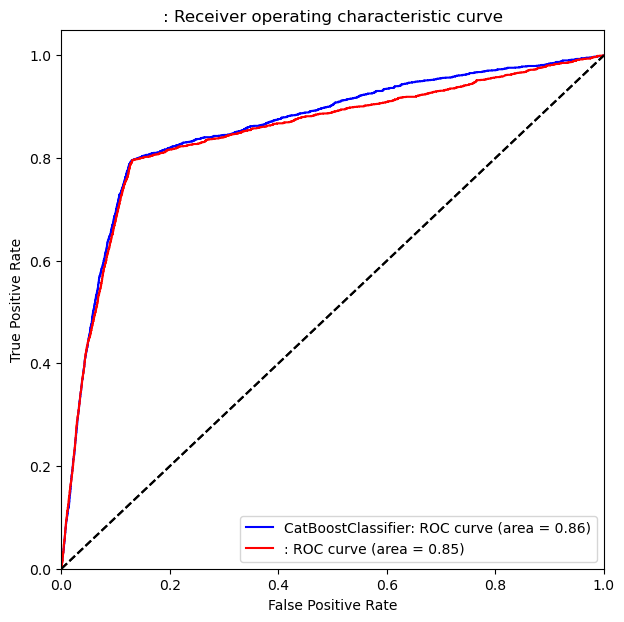

In [158]:
fpr, tpr, _ = roc_curve(y_valid_cat, cat_proba_1)
plt.figure(figsize=(7, 7))
plot_roc_curve(fpr, tpr, "CatBoostClassifier", color='b')
print("CatBoostClassifier: AUC_ROC = %.3f" % auc(fpr, tpr))

fpr, tpr, _ = roc_curve(y_valid, logreg_proba_1)
plot_roc_curve(fpr, tpr, "", color='r')
print("LogisticRegression: AUC_ROC = %.3f" % auc(fpr, tpr))

Catboost имеет чуть лучший показатель.

##### Precision-Recall-кривая

CatBoostClassifier: AUC_PR = 0.358
LogisticRegression: AUC_PR = 0.350


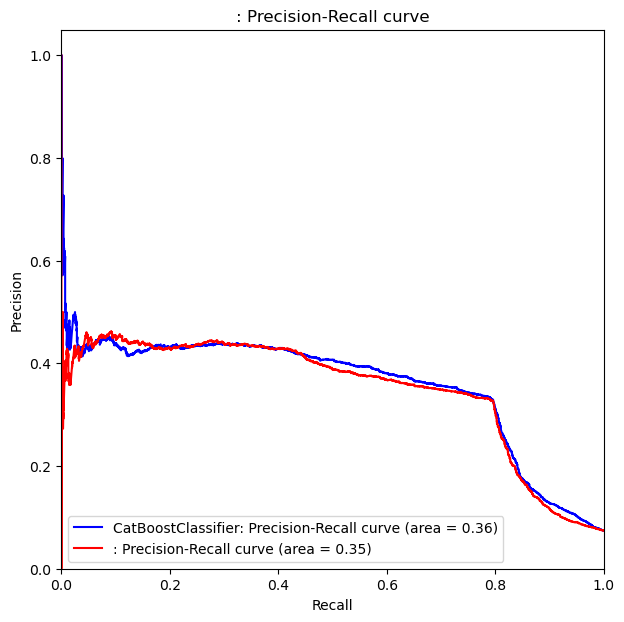

In [159]:
precision, recall, _ = precision_recall_curve(y_valid_cat, cat_proba_1)
plt.figure(figsize=(7, 7))    
plot_precision_recall_curve(precision, recall, "CatBoostClassifier", color='b')
print("CatBoostClassifier: AUC_PR = %.3f" % auc(recall, precision))

precision, recall, _ = precision_recall_curve(y_valid, logreg_proba_1) 
plot_precision_recall_curve(precision, recall, "", color='r')
print("LogisticRegression: AUC_PR = %.3f" % auc(recall, precision))

##### Матрица смежности

Confusion matrix, without normalization
[[22102  3310]
 [  415  1618]]


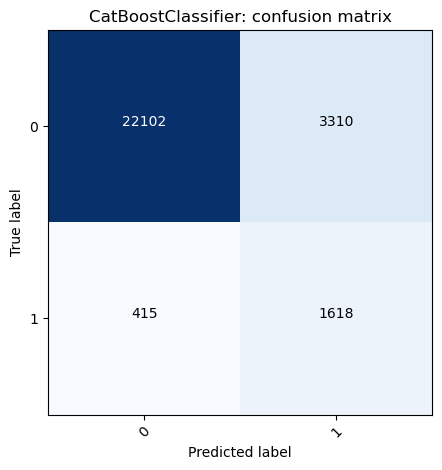

In [160]:
# print(confusion_matrix(y_valid,cat_pred))

# TN                FP(Type II error)
# 
# FN(Type I error)  TP

cm = confusion_matrix(y_valid_cat,cat_pred)
plot_confusion_matrix(cm, classes=["0", "1"], model_name="CatBoostClassifier");

##### classification_report

In [162]:
print('LogisticRegression')
print(classification_report(y_valid, logreg_pred > 0.5))
print()
print('CatBoostClassifier')
print(classification_report(y_valid_cat,cat_pred))

LogisticRegression
              precision    recall  f1-score   support

         0.0       0.98      0.87      0.92     25412
         1.0       0.33      0.80      0.46      2033

    accuracy                           0.86     27445
   macro avg       0.65      0.83      0.69     27445
weighted avg       0.93      0.86      0.89     27445


CatBoostClassifier
              precision    recall  f1-score   support

         0.0       0.98      0.87      0.92     25412
         1.0       0.33      0.80      0.46      2033

    accuracy                           0.86     27445
   macro avg       0.65      0.83      0.69     27445
weighted avg       0.93      0.86      0.89     27445



#### 7.4 Применение результата

При построении стратегии рассылки предложений необходимо учитывать следующее.

Прибыль оператора от положительного отклика клиента на услугу равна разнице Дохода от клиента и Затрат на рассылку предложения клиенту.

$$Прибыль = Доход - Затраты $$

Ошибка первого рода отражает доход, который оператор потерял, не отправив предложение. Ошибка второго рода отражает затраты оператора на рассылку предложения клиенту, которые оказались напрасными.

Итого реальная прибыль от кампании по рассылке предложений будет определяться формулой:

$$REAL = N_+ \cdot (Доход - Затраты) - N_{e2} \cdot Затраты$$
,

а упущенная прибыль

$$N_{e1} \cdot (Доход - Затраты)$$
,

максимально возможная прибыль определяется формулой:

$$MAX = (N_+ + N_{e1}) \cdot (Доход - Затраты)$$
где $N_+$ - количество положительных откликов на отправленное предложение

$N_{e1}$ - количество упущенных клиентов, готовых подключить услугу (ош. 1 рода)

$N_{e2}$ - количество напрастно отправленных предложений (ош. 2 рода)

Для получения максимальной выгоды необходимо минимизировать разницу $MAX - REAL$, то есть упрощая выражение

$$\frac{Доход - Затраты}{Затраты} \cdot N_{e1} + N_{e2} \rightarrow min$$
Так как Доход от подключения услуги, как правило, на несколько порядков превышает Затрату на рассылку предложения (например, услуга со стоимостью подключения 100 р., затрата на смс-рассылку 10 коп.), то $N_{e1}$ гораздо сильнее влияет, чем $N_{e2}$, на изменение выгоды. Максимально возможная выгода достигается лишь, когда $N_{e1}=N_{e2}=0$, то есть оператор абсолютно безошибочно разослал все предложения. Это практически невозможно и является идеальным случаем.

***Построим график количества ошибок 1 и 2 рода при разных порогах на предсказаниях модели***

Используя последнюю формулу и задавая конкретные значения Дохода income от услуги и Затрат expense на предложение найдем порог, при котором мы добъемся максимальной выгоды

In [163]:
def plot_fp_fn_curve(y_true, y_pred_proba, threshold, income_expense):
    
    plt.figure(figsize=(10, 5))  
    
    fp_fn_thr = list()
    for thr in threshold:
        y_pred = np.ones(y_pred_proba.shape)
        y_pred[y_pred_proba<thr] = 0
        fp, fn = confusion_matrix(y_true, y_pred).ravel()[1:3]
        fp_fn_thr.append([fp, fn, thr])
        
    vectors = np.array(fp_fn_thr)[:,0:2]
    thresholds = np.array(fp_fn_thr)[:,2]
    plt.plot(vectors[:,0], vectors[:,1], c='black', label='model FP-FN-curve', alpha=0.5)
    
    for income, expense in income_expense:
        coef = income / expense - 1
        ie_vectors = vectors.copy()
        ie_vectors[:,1] = ie_vectors[:,1] * coef        
        norms = np.linalg.norm(ie_vectors, axis=1)
        min_idx = np.where(norms == np.amin(norms))
        plt.scatter(vectors[min_idx,0],
                    vectors[min_idx,1],                   
                    label=f'income:{income}, expense:{expense}, threshold:{thresholds[min_idx][0]:.2f}')
    
    plt.legend(loc="upper right")
    plt.xlabel('False Positive')
    plt.ylabel('False Negative')
    plt.show()

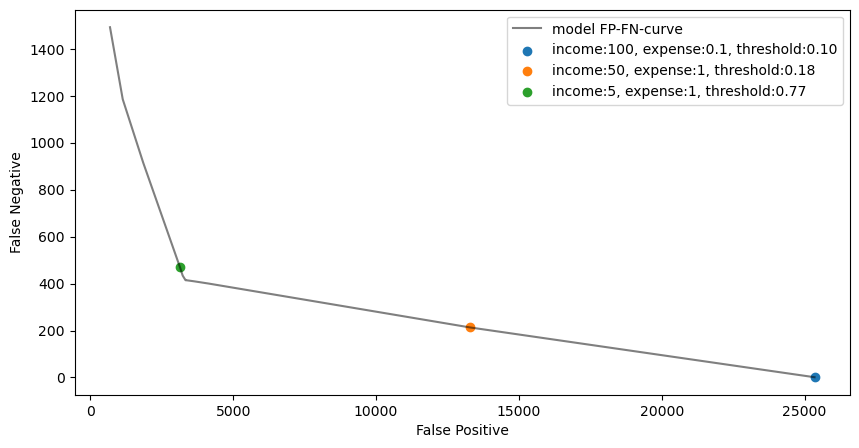

In [164]:
income_expense = [[100, 0.1],
                  [50, 1],
                  [5, 1]]

plot_fp_fn_curve(y_valid, logreg_proba_1, np.linspace(0.1,0.9,20), income_expense)

* доход 100 р., затраты 10 коп. - наиболее оптимальный порог для предсказаний с максимальной выгодой - 0.10
* доход 50 р., затраты 1 руб. - наиболее оптимальный порог для предсказаний с максимальной выгодой - 0.18
* доход 5 р., затраты 1 руб. - наиболее оптимальный порог для предсказаний с максимальной выгодой - 0.77

### 5 Финальная модель и предсказание на тестовых данных

#### Предобработка и селекция полной тренировочной выборки

In [165]:
selector = SelectPercentile()
X_cat_fin = selector.fit_transform(X[f_ok], y)
columns = X[f_ok].columns
support = selector.get_support()
selected_columns = columns[support]

for feat in f_categorical+f_weight:
    assert feat in selected_columns

X_cat_fin = pd.DataFrame(X_cat_fin, columns=selected_columns)

X_cat_fin[f_categorical] = X_cat_fin[f_categorical].astype('int').astype('category')

#### Обучение финальной модели Catboost

Лучшие гиперпараметры:
- bagging_temperature      1.50
- depth                   4.00
- l2_leaf_reg             10.00
- iterations             100.00
- learning_rate            0.1

In [166]:
fin_model = CatBoostClassifier(**frozen_params,
                               **best_cat_params)

In [167]:
fin_model.fit(X=X_cat_fin, y=y)

0:	learn: 0.8214011	total: 133ms	remaining: 13.2s
1:	learn: 0.8216184	total: 291ms	remaining: 14.3s
2:	learn: 0.8213931	total: 450ms	remaining: 14.6s
3:	learn: 0.8213920	total: 607ms	remaining: 14.6s
4:	learn: 0.8213931	total: 786ms	remaining: 14.9s
5:	learn: 0.8216184	total: 969ms	remaining: 15.2s
6:	learn: 0.8213931	total: 1.14s	remaining: 15.2s
7:	learn: 0.8213920	total: 1.29s	remaining: 14.9s
8:	learn: 0.8213920	total: 1.48s	remaining: 14.9s
9:	learn: 0.8213920	total: 1.62s	remaining: 14.6s
10:	learn: 0.8213920	total: 1.78s	remaining: 14.4s
11:	learn: 0.8216184	total: 1.93s	remaining: 14.2s
12:	learn: 0.8215512	total: 2.11s	remaining: 14.1s
13:	learn: 0.8215512	total: 2.26s	remaining: 13.9s
14:	learn: 0.8215512	total: 2.43s	remaining: 13.7s
15:	learn: 0.8215512	total: 2.59s	remaining: 13.6s
16:	learn: 0.8215512	total: 2.83s	remaining: 13.8s
17:	learn: 0.8215607	total: 3s	remaining: 13.7s
18:	learn: 0.8215679	total: 3.19s	remaining: 13.6s
19:	learn: 0.8216184	total: 3.34s	remaining:

#### сохранение финальной модели в pickle

In [169]:
import pickle
with open('final_model.pkl', 'wb') as file:
        pickle.dump(fin_model, file)

### Прогнозирование на тестовом датасете

#### Загрузка, предобработка и селекция тестовых данных

In [181]:
w_sc = StandardScaler().fit_transform(test_feat['time_delta'].values.reshape(-1,1))
w = 1 / (1 + np.exp(w_sc))

assert not np.isnan(w).any()

test_feat['time_delta'] = w

X_test = test_feat.drop(['id','buy_time_vas'], axis=1)

X_test.loc[X_test['252']>1,:] = X_test['252'].value_counts().argmax()

X_cat_test = selector.transform(X_test[f_ok])

X_cat_test = pd.DataFrame(X_cat_test, columns=selected_columns)

X_cat_test[f_categorical] = X_cat_test[f_categorical].astype('int').astype('category')

#### Предсказание на тестовых данных

In [182]:
test_pred_proba = fin_model.predict_proba(X_cat_test)[:,1]

#### Формирование отчетного файла с предсказаниями и его сохранение в answers_test.csv

In [185]:
answers_test = test_feat[['buy_time_vas', 'id', 'vas_id']].rename(columns={'buy_time_vas': 'buy_time'}).copy()

In [186]:
answers_test['target'] = test_pred_proba

In [187]:
answers_test.head()

,buy_time,id,vas_id,target
0,1548018000,3130519,2.0,0.134254
1,1548018000,2000860,4.0,0.776897
2,1546808400,1099444,2.0,0.158093
3,1547413200,1343255,5.0,0.139906
4,1546808400,1277040,2.0,0.165863


In [189]:
answers_test.to_csv('answers_test.csv')